# **Modélisation par régression linéaire**

**API SKL** : [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

**Guide SKL** : [**Ordinary Least Squares** (1.1.1)](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

**Résout** : $\min_{w} || X w - y||_2^2$

**Complexité** : $\mathcal{O}(n p^2)$

**Meilleur score $R^2$ au 14/11/2022** :

$R^2_{17} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$


## Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)
# display(data)

✔ _data loaded
✔ struct loaded


## Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

## Préparation des données pour la modélisation

Le premier `get_ml_data(data)` retournait la juxtaposition fixe suivante d'ensembles de données : `bid`, `pid`, `x`, `y`, `z`, `t`, `a_scale`, `ei_ad`, `u_ad`, `ies_wn`, `ies`, `ie_wn`, `ie`, `ie_e`, `ie_s`, `ie_g`, `_1000_ih`.

Ce sont 84 colonnes (trop) dont certaines biaisées, comme `bid` et `pid` qui sont de naïfs et *hérétiques* encodages de libellés de `BuildingType` et de `PrimaryPropertyType`.

Pour la nouvelle version, plus *flexible*, nous :
1. restons sur le même plan de spécification de noms de variables courts et proches de leur expression $\LaTeX$, avec éventuellement des variables synthétiques supplémentaires que le feature engineering pourrait faire émerger.
2. intégrons le hot-encoding systématique des variables catégorielles.
3. nous dotons d'un moyen pratique de définir divers sous-ensembles de variables (suivant un mode qui cherche à se rapprocher du langage de formules [`patsy`](https://patsy.readthedocs.io/en/latest/)).

### Version prototype obsolète

In [3]:
from seattle_commons import get_ml_data
ml_data = get_ml_data(data)             ; display(ml_data)
ml_nr_data = get_ml_data(nr_data)       ; display(ml_nr_data)
ml_r_data = get_ml_data(r_data)         ; display(ml_r_data)

bid  pid         x          y   z   t       a_sc      _a_i      _a_o  \
id                                                                            
1        0    7  47.61220 -122.33799  12  89  11.390012  1.000000  0.000000   
2        0    7  47.61317 -122.33393  11  20  11.547964  0.854547  0.145453   
3        0    7  47.61393 -122.33810  41  47  13.770628  0.794252  0.205748   
5        0    7  47.61412 -122.33664  10  90  11.023861  1.000000  0.000000   
8        0    7  47.61375 -122.34047  18  36  12.075850  0.646885  0.353115   
...    ...  ...       ...        ...  ..  ..        ...       ...       ...   
50221    4    3  47.54067 -122.37441   1  34   9.812523  1.000000  0.000000   
50223    4    3  47.59625 -122.32283   1  12   9.680344  1.000000  0.000000   
50224    4    3  47.63644 -122.35784   1  42   9.484709  1.000000  0.000000   
50225    4    5  47.52832 -122.32431   1  27   9.554001  1.000000  0.000000   
50226    4    5  47.53939 -122.29536   1  78   9.812359  1.000000  0.000000   

       s_u_0  ...  s_u_65  s_u_66      ies_wn         ies       ie_wn  \
id            ...                                                       
1        0.0  ...     0.0     0.0  189.000000  182.500000   84.321754   
2        0.0  ...     0.0     0.0  179.399994  176.100006   83.661424   
3        0.0  ...     0.0     0.0  244.100006  241.899994   77.331177   
5        0.0  ...     0.0     0.0  224.000000  216.199997  113.287679   
8        0.0  ...     0.0     0.0  215.600006  211.399994   83.474786   
...      ...  ...     ...     ...         ...         ...         ...   
50221    0.0  ...     0.0     0.0  136.600006  126.000000   56.154215   
50223    0.0  ...     0.0     0.0  118.900002  114.199997   65.856609   
50224    0.0  ...     0.0     0.0  767.799988  744.799988  460.117390   
50225    0.0  ...     0.0     0.0  110.800003  105.300003   55.516723   
50226    0.0  ...     0.0     0.0  123.900002  115.800003   70.857836   

               ie        ie_e       ie_s        ie_g         ig  
id                                                               
1       81.714753   44.621152  22.659633   14.433962   2.826741  
2       80.991184   31.311927   0.000000   49.679258   2.856729  
3       75.919114   51.800174  22.556561    1.562373   2.185188  
5      110.805349   45.155316  36.112953   29.537068   4.671070  
8       80.718795   30.576415   0.000000   50.142374   2.876239  
...           ...         ...        ...         ...        ...  
50221   51.042228   34.629101   0.000000   16.413121   1.113302  
50223   59.392262   24.784128   0.000000   34.608124   2.010625  
50224  438.238048  136.213328   0.000000  302.024706  16.990195  
50225   51.022707   24.740811   0.000000   26.281895   1.567974  
50226   63.144717   23.691217   0.000000   39.453499   2.260379  

[3193 rows x 84 columns]

bid  pid         x          y   z   t       a_sc      _a_i      _a_o  \
id                                                                            
1        0    3  47.61220 -122.33799  12  89  11.390012  1.000000  0.000000   
2        0    3  47.61317 -122.33393  11  20  11.547964  0.854547  0.145453   
3        0    3  47.61393 -122.33810  41  47  13.770628  0.794252  0.205748   
5        0    3  47.61412 -122.33664  10  90  11.023861  1.000000  0.000000   
8        0    3  47.61375 -122.34047  18  36  12.075850  0.646885  0.353115   
...    ...  ...       ...        ...  ..  ..        ...       ...       ...   
50221    1    1  47.54067 -122.37441   1  34   9.812523  1.000000  0.000000   
50223    1    1  47.59625 -122.32283   1  12   9.680344  1.000000  0.000000   
50224    1    1  47.63644 -122.35784   1  42   9.484709  1.000000  0.000000   
50225    1    4  47.52832 -122.32431   1  27   9.554001  1.000000  0.000000   
50226    1    4  47.53939 -122.29536   1  78   9.812359  1.000000  0.000000   

          s_u_0  ...  s_u_65  s_u_66      ies_wn         ies       ie_wn  \
id               ...                                                       
1      0.000000  ...     0.0     0.0  189.000000  182.500000   84.321754   
2      0.000000  ...     0.0     0.0  179.399994  176.100006   83.661424   
3      0.000000  ...     0.0     0.0  244.100006  241.899994   77.331177   
5      0.000000  ...     0.0     0.0  224.000000  216.199997  113.287679   
8      0.000000  ...     0.0     0.0  215.600006  211.399994   83.474786   
...         ...  ...     ...     ...         ...         ...         ...   
50221  0.000000  ...     0.0     0.0  136.600006  126.000000   56.154215   
50223  0.000000  ...     0.0     0.0  118.900002  114.199997   65.856609   
50224  0.000000  ...     0.0     0.0  767.799988  744.799988  460.117390   
50225  0.018261  ...     0.0     0.0  110.800003  105.300003   55.516723   
50226  0.024072  ...     0.0     0.0  123.900002  115.800003   70.857836   

               ie        ie_e       ie_s        ie_g         ig  
id                                                               
1       81.714753   44.621152  22.659633   14.433962   2.826741  
2       80.991184   31.311927   0.000000   49.679258   2.856729  
3       75.919114   51.800174  22.556561    1.562373   2.185188  
5      110.805349   45.155316  36.112953   29.537068   4.671070  
8       80.718795   30.576415   0.000000   50.142374   2.876239  
...           ...         ...        ...         ...        ...  
50221   51.042228   34.629101   0.000000   16.413121   1.113302  
50223   59.392262   24.784128   0.000000   34.608124   2.010625  
50224  438.238048  136.213328   0.000000  302.024706  16.990195  
50225   51.022707   24.740811   0.000000   26.281895   1.567974  
50226   63.144717   23.691217   0.000000   39.453499   2.260379  

[1538 rows x 84 columns]

bid  pid         x          y  z    t       a_sc      _a_i      _a_o  \
id                                                                            
13       0    0  47.60284 -122.33184  6  106  11.062128  0.976519  0.023481   
265      0    0  47.61316 -122.34153  7   13  11.669476  1.000000  0.000000   
280      0    0  47.61360 -122.32785  6  107  10.858537  1.000000  0.000000   
296      1    1  47.56379 -122.36301  4   99  10.944065  1.000000  0.000000   
297      0    0  47.72232 -122.29181  6    7  10.946323  1.000000  0.000000   
...    ...  ...       ...        ... ..  ...        ...       ...       ...   
50090    0    0  47.66366 -122.31450  7    1  11.063900  0.924011  0.075989   
50092    0    6  47.65577 -122.31702  7    1  12.691580  1.000000  0.000000   
50093    0    0  47.60189 -122.32182  6    1  11.362626  0.896473  0.103527   
50095    0    0  47.55976 -122.38320  7    1  12.245947  0.717406  0.282594   
50098    1    1  47.61791 -122.30230  4    2   9.915713  0.872567  0.127433   

          s_u_0  ...  s_u_38  s_u_39      ies_wn         ies      ie_wn  \
id               ...                                                      
13     0.881027  ...     0.0     0.0  187.399994  182.699997  75.459560   
265    0.698949  ...     0.0     0.0  178.800003  175.399994  89.294125   
280    0.968716  ...     0.0     0.0  162.899994  156.800003  86.203911   
296    1.000000  ...     0.0     0.0   88.400002   80.800003  38.602372   
297    0.769636  ...     0.0     0.0  138.500000  133.899994  45.371901   
...         ...  ...     ...     ...         ...         ...        ...   
50090  1.116193  ...     0.0     0.0   85.400002   78.599998  39.064293   
50092  0.000000  ...     0.0     0.0  113.000000  109.900002  53.631175   
50093  0.910675  ...     0.0     0.0   85.099998   85.099998  25.117558   
50095  0.808226  ...     0.0     0.0   46.900002   46.900002  17.066654   
50098  0.872567  ...     0.0     0.0  106.400002  106.099998  39.277444   

              ie       ie_e       ie_s       ie_g        ig  
id                                                           
13     71.788313  39.741571  16.319299  15.727430  2.371924  
265    85.851890  47.052314   0.000000  38.799576  2.388689  
280    80.605842  32.190838   0.000000  48.415018  2.795713  
296    35.088602  21.051963   0.000000  14.036632  0.892311  
297    43.597894  27.408124   0.000000  16.189761  1.050841  
...          ...        ...        ...        ...       ...  
50090  36.625950  23.563259   0.000000  13.062687  0.857971  
50092  50.669188  27.121788   0.000000  23.547394  1.439692  
50093  25.117558  25.117555   0.000000   0.000000  0.175141  
50095  17.066654   9.555156   0.000000   7.511497  0.465561  
50098  39.012506  24.692581   0.000000  14.319915  0.932530  

[1655 rows x 57 columns]

### Version flexible

In [4]:
from seattle_commons import new_get_ml_data
new_ml_data = new_get_ml_data(data, sel=['btype', 'lat.', 'ie'])
display(new_ml_data)

btype_Multifamily  btype_NonResidential  btype_School      lat.  \
id                                                                       
1                    0.0                   1.0           0.0  47.61220   
2                    0.0                   1.0           0.0  47.61317   
3                    0.0                   1.0           0.0  47.61393   
5                    0.0                   1.0           0.0  47.61412   
8                    0.0                   1.0           0.0  47.61375   
...                  ...                   ...           ...       ...   
50221                0.0                   1.0           0.0  47.54067   
50223                0.0                   1.0           0.0  47.59625   
50224                0.0                   1.0           0.0  47.63644   
50225                0.0                   1.0           0.0  47.52832   
50226                0.0                   1.0           0.0  47.53939   

               ie  
id                 
1       81.714753  
2       80.991184  
3       75.919114  
5      110.805349  
8       80.718795  
...           ...  
50221   51.042228  
50223   59.392262  
50224  438.238048  
50225   51.022707  
50226   63.144717  

[3193 rows x 5 columns]

# Expérimentation

## Config 1 : $e = f(a)$

Ensemble minimal.

$\{a : e\}$

Cela nous donne une première performance *baseline* :

$R^2_{1, \text{OLS}} \left(\{a : e\}\right)$ :
* $\mu = 0.34612468985020617$
* $\sigma = 0.15269182507734183$

#### Jeu de données

In [2]:
config_name = "{a : e}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name)
# display(ml_data)

#### Visualisation

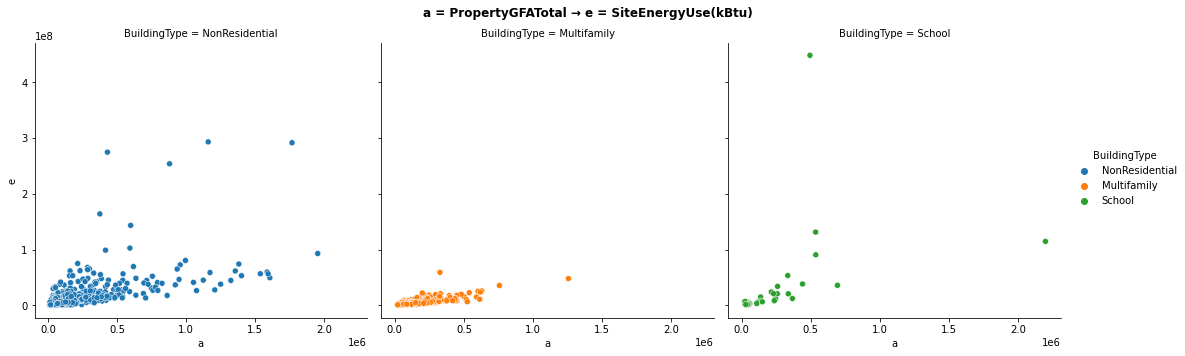

In [13]:
from seattle_commons import get_abstract_btype, plot_ml_data
btype = get_abstract_btype(data)   # hue labels
plot_ml_data(ml_data, btype=btype,
             x='a', y='e',
             title="a = PropertyGFATotal → e = SiteEnergyUse(kBtu)"
)

#### Vérifications

L'ensemble des valeurs des $a$ et de $e$ sont positives, on peut donc appliquer la régression NNLS ([**Non-negative least squares**](https://scikit-learn.org/stable/auto_examples/linear_model/plot_nnls.html#sphx-glr-auto-examples-linear-model-plot-nnls-py)).

In [14]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [6]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.311890342263197
 OLS R2 score 0.3118903422631967
features : ['a']
intercept (ols) : [-1438528.31895339]
intercept (nnls) : [-1438528.31895338]
coefficients (ols) : [[70.15004307]]
coefficients (nnls) : [[70.15004307]]


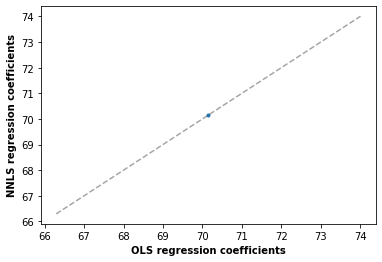

In [17]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [18]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.51352762451025
SM OLS R2 score 0.3118903422631969
                            OLS Regression Results                            
Dep. Variable:                      e   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     840.3
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          1.11e-126
Time:                        09:52:29   Log-Likelihood:                -14021.
No. Observations:                 798   AIC:                         2.805e+04
Df Residuals:                     796   BIC:                         2.806e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

#### Validation croisée du score OLS

In [19]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.28803575 0.55528425 0.19505406]
mean scores : 0.34612468985020617
std scores : 0.15269182507734183


## Config 2 : $e = f(a, \tilde{a_i}, \tilde{a_o})$

$\{\tilde{a_i}, \tilde{a_o}, a : e\}$

Premier élargissement avec l'ajout des proportions relatives de surface intérieure / extérieure.

On vérifie :
* qu'il n'y a pas de NA,
* que les coefficients sont tous positifs.

Les performances se dégradent légèrement de 0,00502634837.

$R^2_{2, \text{OLS}} \left(\tilde{a_i}, \tilde{a_o}, \{a : e\}\right)$ :
* $\mu = 0.341098341484052$
* $\sigma = 0.153097888182222$

Pour comparaison :

$R^2_{1, \text{OLS}} \left(\{a : e\}\right)$ :
* $\mu = 0.34612468985020617$
* $\sigma = 0.15269182507734183$

#### Jeu de données

In [18]:
config_name = "{_a_i, _a_o, a : e}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

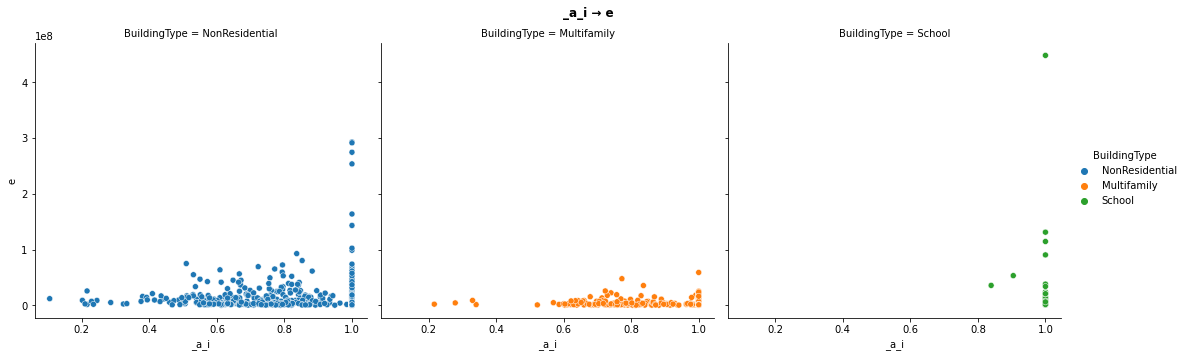

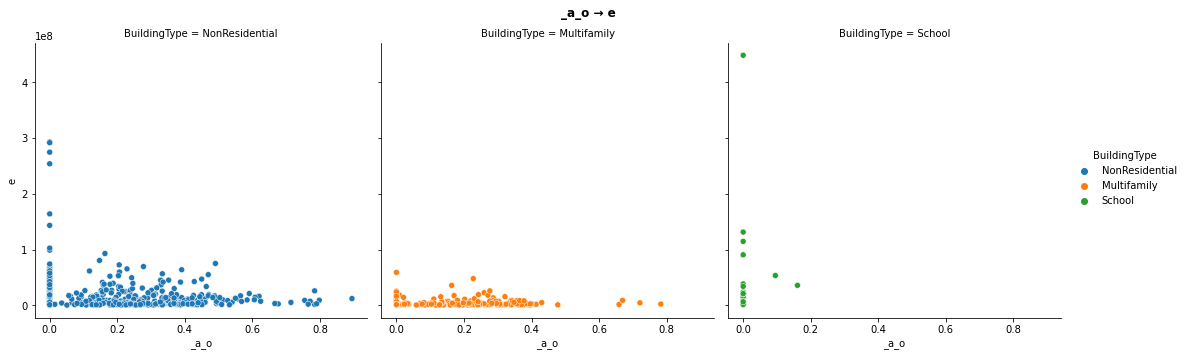

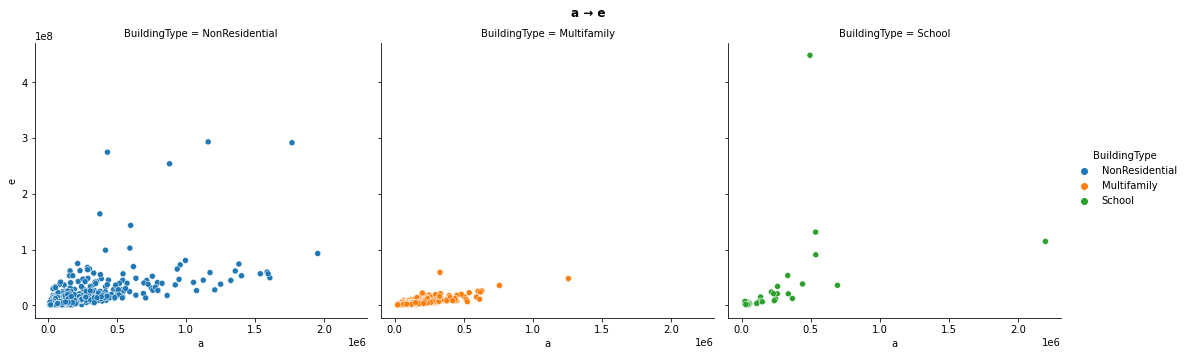

In [5]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [6]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [7]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.31047875998244756
 OLS R2 score 0.31047875998244745
features : ['a' '_a_i' '_a_o']
intercept (ols) : [-6768450.35624903]
intercept (nnls) : [-12321311.05969209]
coefficients (ols) : [[ 7.24934873e+01  5.55286070e+06 -5.55286070e+06]]
coefficients (nnls) : [[7.24934873e+01 1.11057214e+07 0.00000000e+00]]


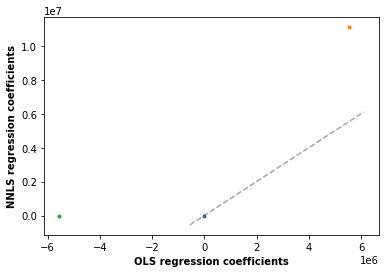

In [26]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

* même $\beta_1$ (`a`), à 5 chiffres significatifs
* $\beta_0$ (`intercept_`) de même signe et ordre de grandeur, mais avec décalé de 50 %
* idem avec $\beta_2$ (`_a_i`) et $\beta_3$ (`_a_e`)
* des $p$-values $\le$ à 0,05, et =0,05 pour le seul $\beta_2$ (`_a_i`)
* je ne sais pas interpréter $t$, ni les autres indicateurs (sauf le $R^2$)
* La plus petite valeur propre est 2,56e-30. Cela pourrait indiquer qu'il y a de forts problèmes de multicolinéarité ou que la matrice de conception est singulière ⇒ il me semble que la cause principale est que les coefficients (`a`) dominent les deux autres.

C'est cette dernière conclusion qui motive de basculer sur l'intensité de la consommation plutôt que la consommation en volume. Dans un premier temps, on ne travaille qu'avec les deux surfaces relatives `_a_i` et `_a_e`, puis on réintroduit le facteur d'échelle `asc` qui est le logarithme de `a`.

In [27]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.5199772288460973
SM OLS R2 score 0.3104787599816662
                            OLS Regression Results                            
Dep. Variable:                      e   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     430.6
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          2.00e-127
Time:                        09:55:00   Log-Likelihood:                -14016.
No. Observations:                 798   AIC:                         2.804e+04
Df Residuals:                     795   BIC:                         2.805e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [28]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.2888653  0.54918252 0.18524721]
mean scores : 0.341098341484052
std scores : 0.153097888182222


## Config 3 : $ie = f(\tilde{a_i}, \tilde{a_o})$

Intensité de la consommation en fonction des proportions relatives de surfaces intérieure et extérieure.

$\{\tilde{a_i}, \tilde{a_o} : ie\}$

Sans intérêt, la performance est moindre que celle d'un tirage aléatoire.

$R^2_{1, \text{OLS}} \left(\{\tilde{a_i}, \tilde{a_o} :ie\}\right)$ :
* $\mu = -0.01777427213941755$
* $\sigma = 0.0052747752634359595$

#### Jeu de données

In [2]:
config_name = "{_a_i, _a_o : ie}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

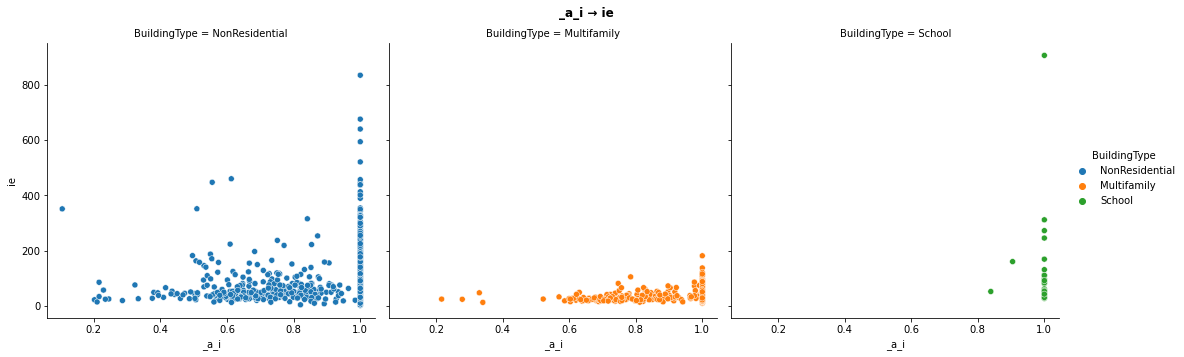

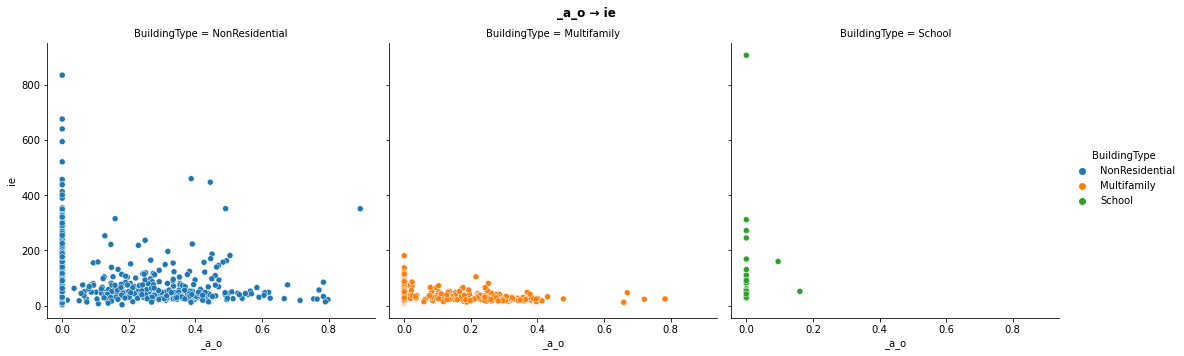

In [3]:
# title="_a_i = Building's relative inner floor area → ie = SiteEUI(kBtu/sf)"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [4]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [5]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score -0.004858865866155471
 OLS R2 score -0.00479426934522631
features : ['_a_i' '_a_o']
intercept (ols) : [1.25220242e+14]
intercept (nnls) : [48.13346071]
coefficients (ols) : [[-1.25220242e+14 -1.25220242e+14]]
coefficients (nnls) : [[0.         4.32782736]]


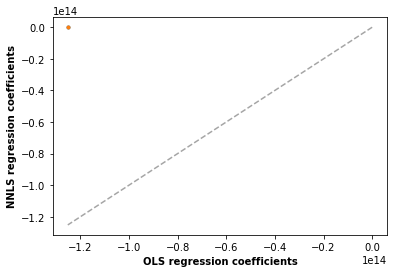

In [8]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [9]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.00012606963359385048
SM OLS R2 score -0.004858865866155471
                            OLS Regression Results                            
Dep. Variable:                     ie   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1004
Date:                Thu, 10 Nov 2022   Prob (F-statistic):              0.751
Time:                        09:25:02   Log-Likelihood:                -4136.0
No. Observations:                 798   AIC:                             8276.
Df Residuals:                     796   BIC:                             8285.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

#### Validation croisée du score OLS

In [10]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [-0.02408081 -0.01807145 -0.01117056]
mean scores : -0.01777427213941755
std scores : 0.0052747752634359595


## Config 4 : $\ln{e} = f(\ln{a})$

Passage au log.

$\{\log(a):\log(e)\}$

Gain significatif de 0,222145739.

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

Rappel pour comparaison :

$R^2_{1, \text{OLS}} \left(\{a : e\}\right)$
* $\mu = 0.34612468985020617$
* $\sigma = 0.15269182507734183$


#### Jeu de données

In [16]:
config_name = "{log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

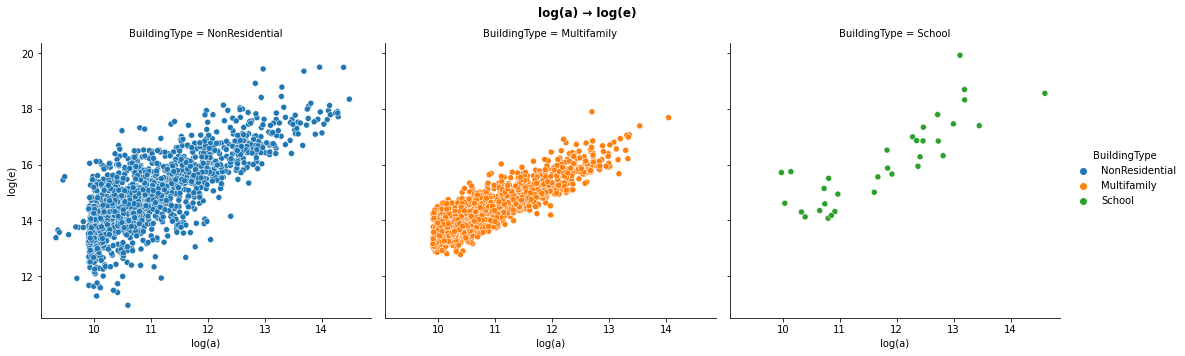

In [14]:
# title="log(a = PropertyGFATotal) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [15]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [16]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6366700733275806
 OLS R2 score 0.6366700733275806
features : ['log(a)']
intercept (ols) : [3.09980242]
intercept (nnls) : [3.09980242]
coefficients (ols) : [[1.05040999]]
coefficients (nnls) : [[1.05040999]]


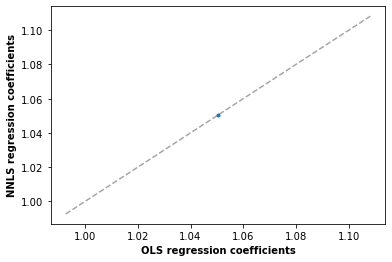

In [18]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [43]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.671927673110738
SM OLS R2 score 0.6366700733275807
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     1630.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          7.82e-195
Time:                        09:58:05   Log-Likelihood:                -770.95
No. Observations:                 798   AIC:                             1546.
Df Residuals:                     796   BIC:                             1555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

#### Validation croisée du score OLS

In [44]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.64150224 0.4918239  0.57148515]
mean scores : 0.5682704287868149
std scores : 0.06114819172081779


## Config 5 : $\ln{e} = f(\ln{a_i})$

$\{\log(a_i):\log(e)\}$

Le but est de confirmer l'intuition que la surface totale est moins pertinente que la surface intérieure prise seule.

Cette intuition était trompeuse : la surface totale est plus pertinente que la seule surface intérieure.

$R^2_4 \left(\{\log(a_i):\log(e)\}\right)$:
* $\mu = 0.5358488752194961$
* $\sigma = 0.048844016950912963$

Pour comparaison :

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [3]:
config_name = "{log(a_i) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

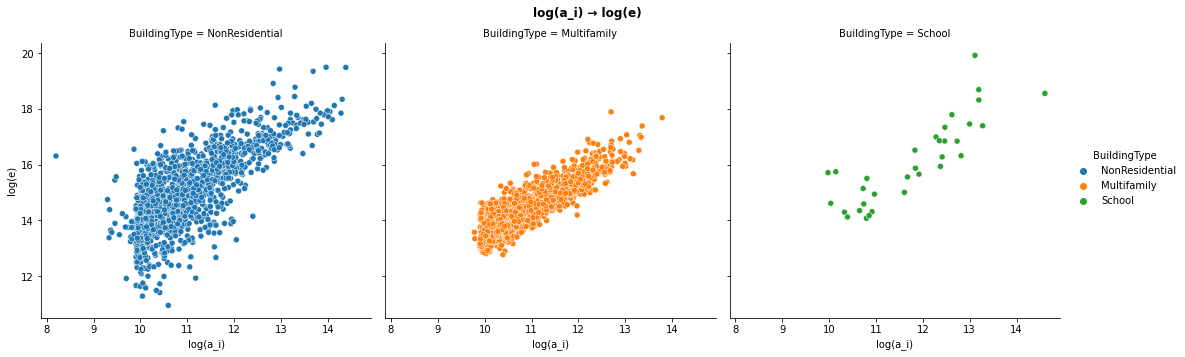

In [4]:
# title="log(a_i = PropertyGFABuilding(s)) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [5]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [6]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6095974540485978
 OLS R2 score 0.6095974540485977
features : ['log(a_i)']
intercept (ols) : [2.79836832]
intercept (nnls) : [2.79836832]
coefficients (ols) : [[1.0830286]]
coefficients (nnls) : [[1.0830286]]


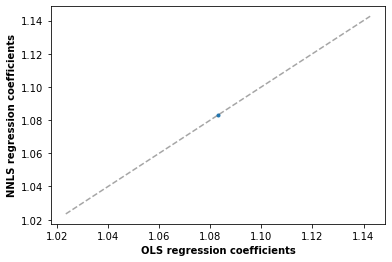

In [50]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [51]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.6478240068995604
SM OLS R2 score 0.6095974540485981
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     1464.
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          1.43e-182
Time:                        09:59:11   Log-Likelihood:                -799.23
No. Observations:                 798   AIC:                             1602.
Df Residuals:                     796   BIC:                             1612.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [53]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.59003133 0.47165235 0.54586295]
mean scores : 0.5358488752194961
std scores : 0.048844016950912963


## Config 6 : $\ln{e} = f(\ln{a}, \ln{n_l})$ 

Evaluation de la contribution du nombre de niveaux `n_l` (nombres d'étages + 1).

$\{\log(n_l), \log(a) :\log(e)\}$

L'amélioration du score est marginale (gain < 0,01).

$R^2_6 \left(\{\log(n_l), \log(a) : \log(e)\}\right)$:
* $\mu = 0.5709443493325117$
* $\sigma = 0.05596336278625848$

Pour comparaison :

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [9]:
config_name = "{log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

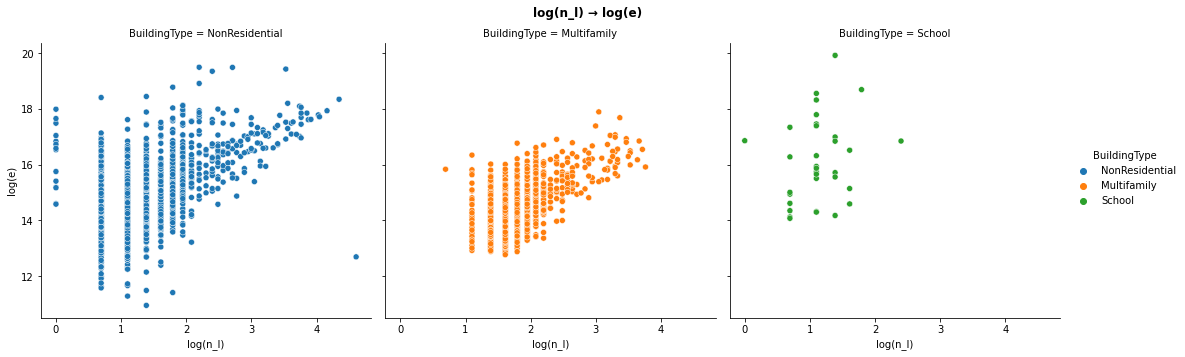

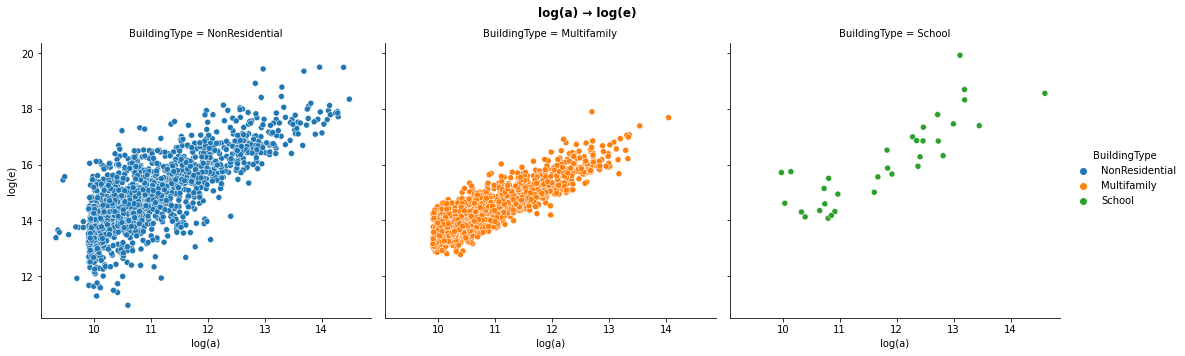

In [10]:
# title="log(n_l = 1 + NumberofFloors) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [11]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [12]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6366700733275806
 OLS R2 score 0.6398364230632547
features : ['log(n_l)' 'log(a)']
intercept (ols) : [2.79827944]
intercept (nnls) : [3.09980242]
coefficients (ols) : [[-0.10612503  1.09331679]]
coefficients (nnls) : [[0.         1.05040999]]


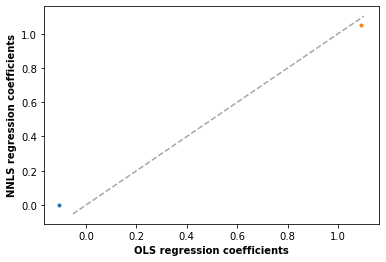

In [14]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [60]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.6738297792447475
SM OLS R2 score 0.6398364230632547
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     821.2
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          3.93e-194
Time:                        10:00:32   Log-Likelihood:                -768.63
No. Observations:                 798   AIC:                             1543.
Df Residuals:                     795   BIC:                             1557.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [61]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.63572027 0.49917483 0.57793794]
mean scores : 0.5709443493325117
std scores : 0.05596336278625848


## Config 7 : $\ln{e} = f(\ln{a}, n_l)$

Evaluation de la contribution du nombre de niveaux `n_l` (nombres d'étages + 1).

$\{n_l, \log(a) : \log(e)\}$

Dégradation marginale de la performance en ne passant pas au log.

Mieux vaut rester au log, ce qui semble logique si l'on considère que :
$\log(S) = \log(n s) = \log(n) + \log(s)$

$R^2_7 \left(\{n_l, \log(a) : \log(g)\}\right)$:
* $\mu = 0.5674455009103052$
* $\sigma = 0.06024099621497478$

Pour comparaison :

$R^2_6 \left(\{\log(n_l), \log(a) : \log(e)\}\right)$:
* $\mu = 0.5709443493325117$
* $\sigma = 0.05596336278625848$

#### Jeu de données

In [16]:
config_name = "{n_l, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

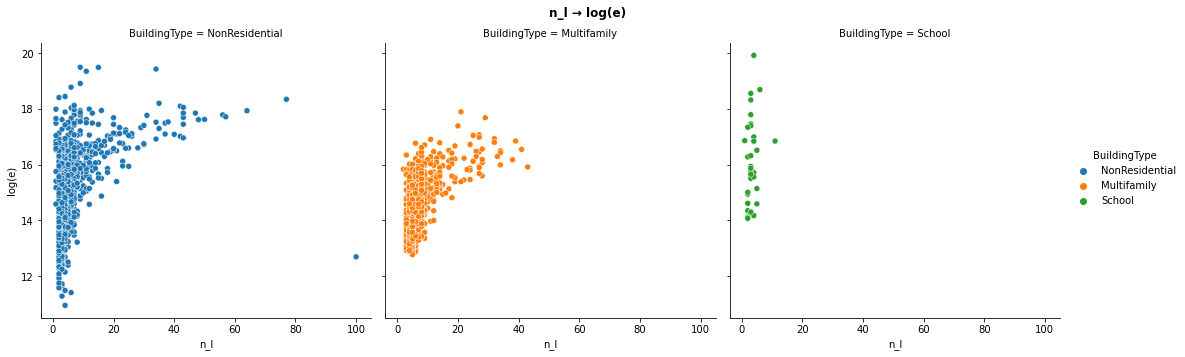

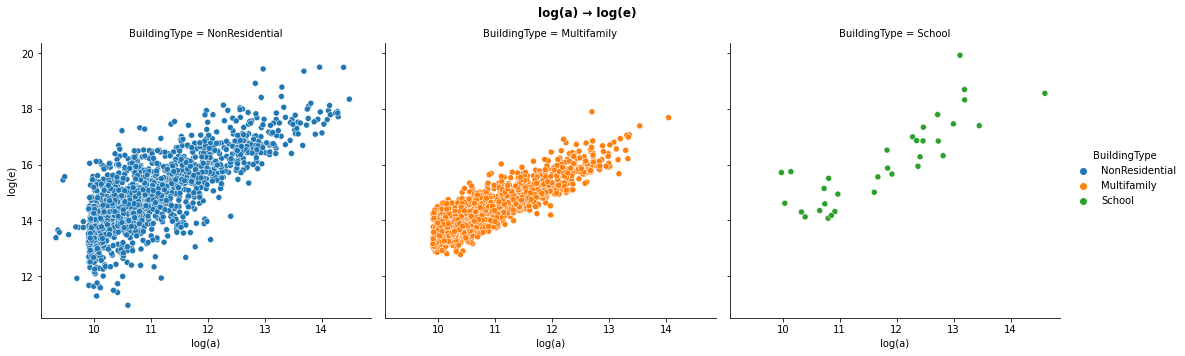

In [17]:
# title="n_l = 1 + NumberofFloors → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [18]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [19]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6365168206035863
 OLS R2 score 0.6365168206035863
features : ['n_l' 'log(a)']
intercept (ols) : [3.14252782]
intercept (nnls) : [3.14252782]
coefficients (ols) : [[0.00125107 1.04582249]]
coefficients (nnls) : [[0.00125107 1.04582249]]


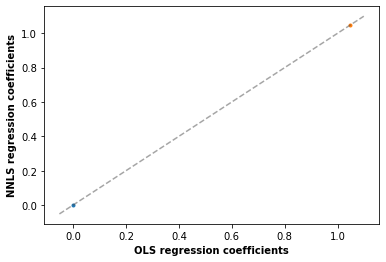

In [13]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [14]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.6719480105517672
SM OLS R2 score 0.6365168206035865
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     814.2
Date:                Wed, 09 Nov 2022   Prob (F-statistic):          3.87e-193
Time:                        16:31:23   Log-Likelihood:                -770.92
No. Observations:                 798   AIC:                             1548.
Df Residuals:                     795   BIC:                             1562.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [15]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.6392655  0.49185071 0.57122029]
mean scores : 0.5674455009103052
std scores : 0.060240996214974786


## Config 8 : $\ln{e} = f(\ln{a}, T)$

Contribution de l'âge du bâtiment `T`.

$\{T, \log(a) :\log(e)\}$

Gain de l'ordre de 0,012.

$R^2_8 \left(\{T, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.5808945020768737$
* $\sigma = 0.06343508702165074$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$


#### Jeu de données

In [21]:
config_name = "{T, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

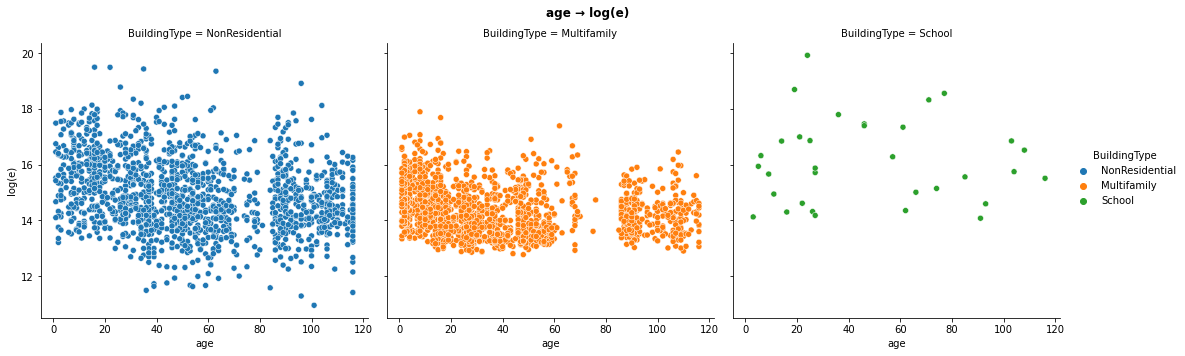

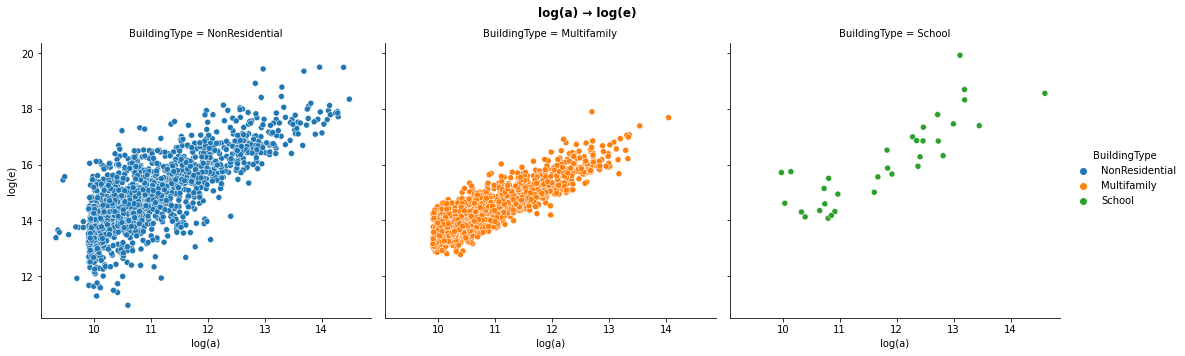

In [22]:
# title="T = (2016 - `YearBuilt`) → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [23]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [24]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6438737371486447
 OLS R2 score 0.6438737371486447
features : ['age' 'log(a)']
intercept (ols) : [2.58141499]
intercept (nnls) : [2.58141499]
coefficients (ols) : [[0.00284978 1.08576786]]
coefficients (nnls) : [[0.00284978 1.08576786]]


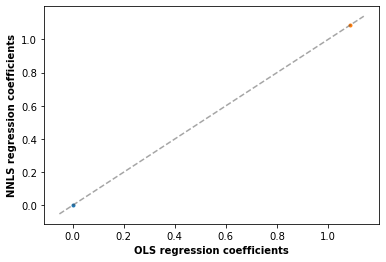

In [26]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [ ]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.6783513842860354
SM OLS R2 score 0.6438737371486447
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     838.3
Date:                Wed, 09 Nov 2022   Prob (F-statistic):          1.53e-196
Time:                        16:42:01   Log-Likelihood:                -763.06
No. Observations:                 798   AIC:                             1532.
Df Residuals:                     795   BIC:                             1546.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [ ]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.65605978 0.50090136 0.58572236]
mean scores : 0.5808945020768737
std scores : 0.06343508702165074


## Config 9 : $\ln{e} = f(\ln{a}, n_\star)$

Contribution du score ENERGYSTAR.

$\{n_\star, \log(a) :\log(e)\}$

**Gain** : 0.0483976384

$R^2_9 \left(\{n_\star, \log(a) :\log(e)\}\right)$:
* $\mu = 0.616668067176413$
* $\sigma = 0.059980161457964365$

Pour comparaison :

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [3]:
config_name = "{n_★, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

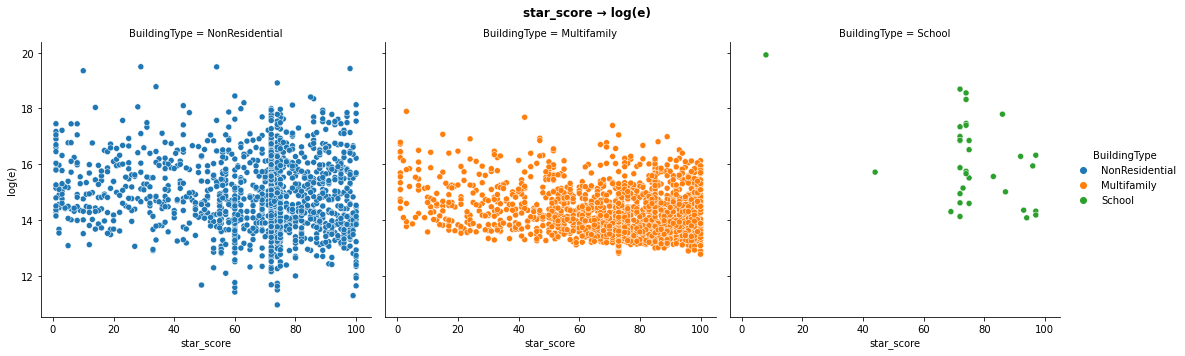

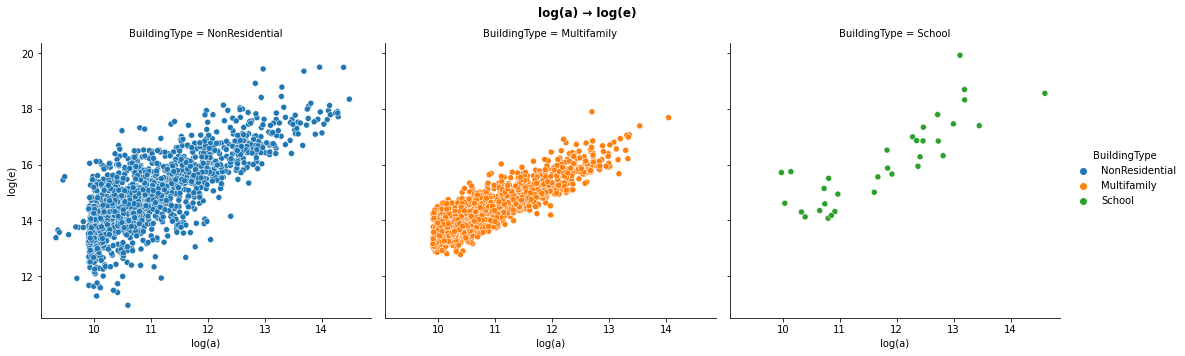

In [4]:
# title="star_score = ENERGYSTARScore → log(e = SiteEnergyUse(kBtu))"
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [5]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [7]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6366700733275806
 OLS R2 score 0.6786346815007966
features : ['log(a)' 'star_score']
intercept (ols) : [3.5785893]
intercept (nnls) : [3.09980242]
coefficients (ols) : [[ 1.06114907 -0.00860948]]
coefficients (nnls) : [[1.05040999 0.        ]]


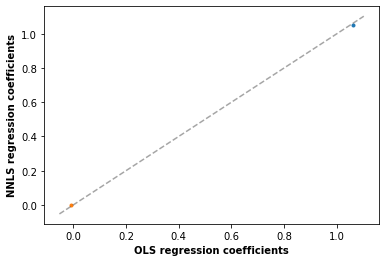

In [76]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [77]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.70627009944385
SM OLS R2 score 0.6786346815007968
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     955.8
Date:                Sat, 05 Nov 2022   Prob (F-statistic):          3.23e-212
Time:                        10:03:04   Log-Likelihood:                -726.83
No. Observations:                 798   AIC:                             1460.
Df Residuals:                     795   BIC:                             1474.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

#### Validation croisée du score OLS

In [78]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.68387037 0.5382415  0.62789233]
mean scores : 0.616668067176413
std scores : 0.059980161457964365


## Config 10 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, T)$

Premier test d'intégration de ce qui a précédemment contribué.

$\{T, n_\star, \log(n_l), \log(a) : \log(e)\}$

$R^2_{10} \left(\{T, n_\star, \log(n_l), \log(a) : \log(e)\}\right)$ :
* $\mu = 0.627354265583291$
* $\sigma = 0.05753899421598054$

#### Jeu de données

In [9]:
config_name = "{n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

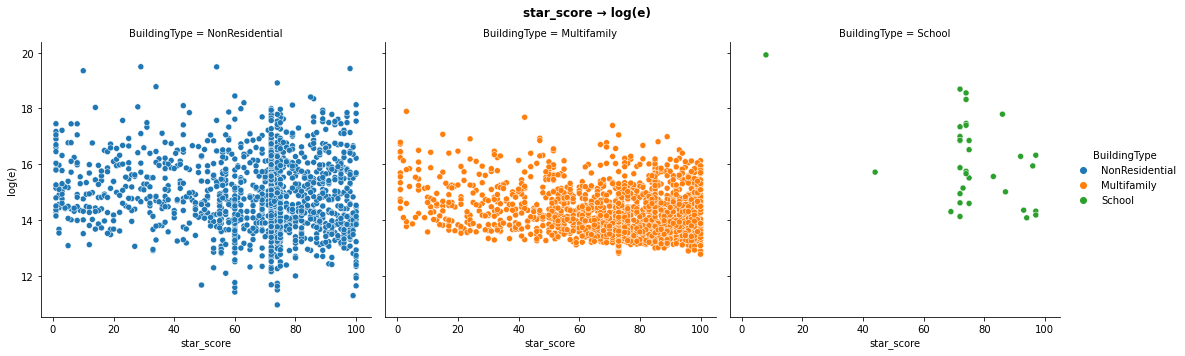

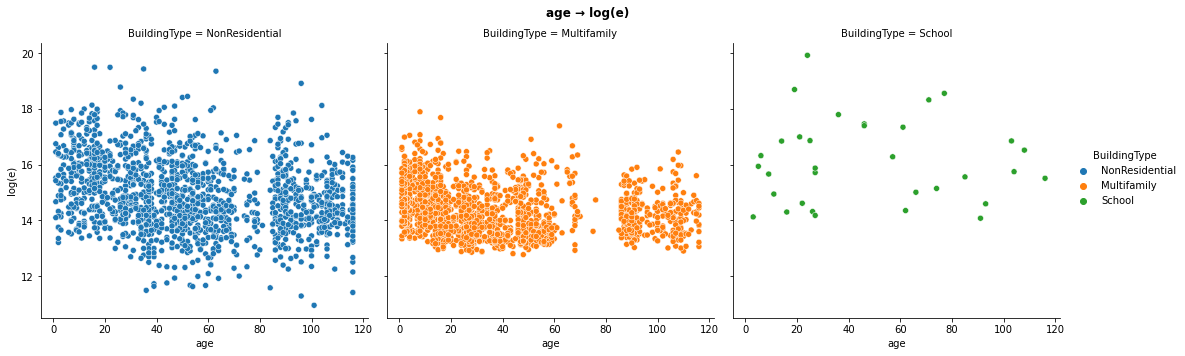

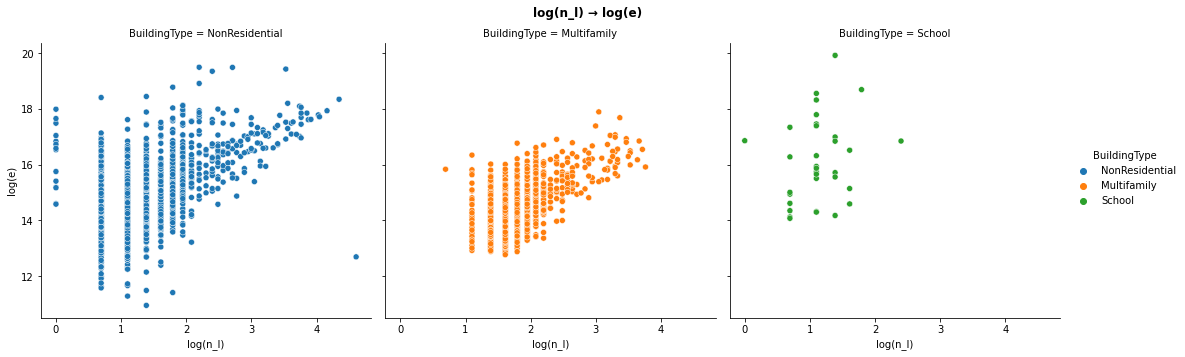

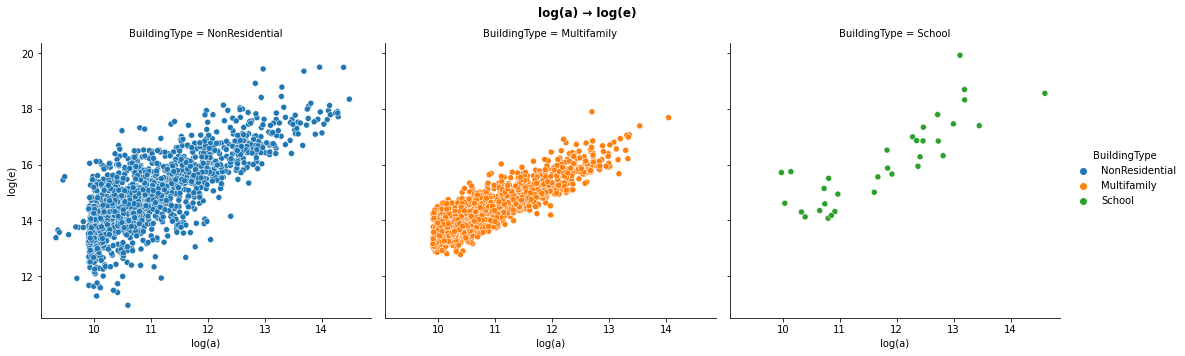

In [10]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [11]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [12]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6438737371486447
 OLS R2 score 0.6863841571685196
features : ['star_score' 'age' 'log(n_l)' 'log(a)']
intercept (ols) : [2.90416883]
intercept (nnls) : [2.58141499]
coefficients (ols) : [[-0.00848542  0.0026545  -0.06499217  1.1202059 ]]
coefficients (nnls) : [[0.         0.00284978 0.         1.08576786]]


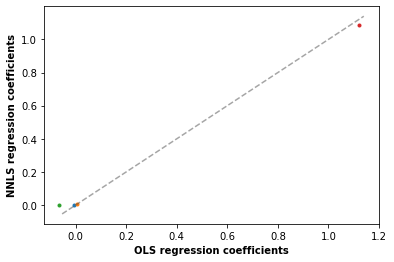

In [14]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [22]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.7129236092604816
SM OLS R2 score 0.6863841571685199
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     492.3
Date:                Wed, 09 Nov 2022   Prob (F-statistic):          3.54e-213
Time:                        16:47:57   Log-Likelihood:                -717.68
No. Observations:                 798   AIC:                             1445.
Df Residuals:                     793   BIC:                             1469.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

#### Validation croisée du score OLS

In [23]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.6907595  0.55148225 0.63982106]
mean scores : 0.627354265583291
std scores : 0.05753899421598054


## Config 11 : $\ln{e} = f(\ln{a}, t_b)$

Contribution de `btype`.

$\{t_b, \log(a) : \log(e)\}$

Gain significatif : 0,0623487977.

$R^2_{11} \left(\{t_b, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.6306192265111306$
* $\sigma = 0.06192790341106927$

Pour comparaison :

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [4]:
config_name = "{t_b, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

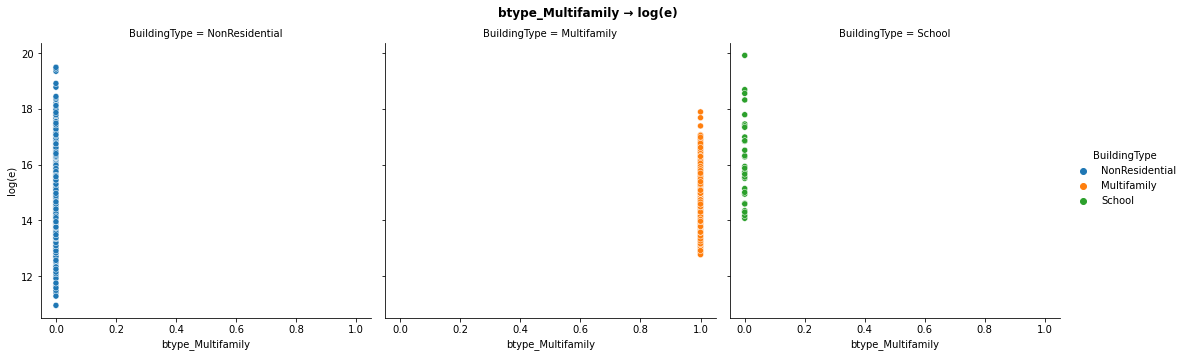

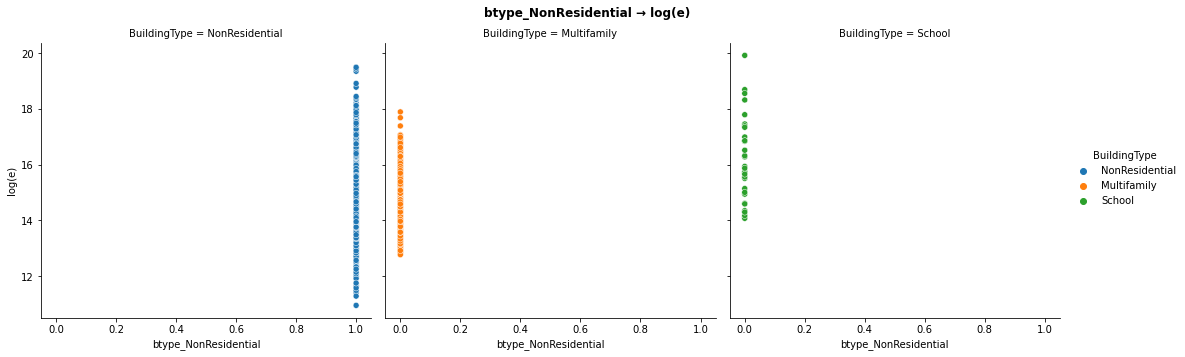

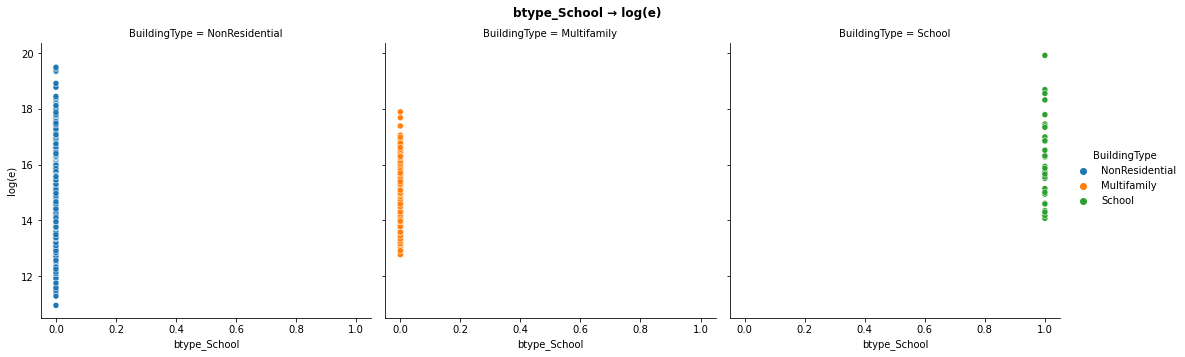

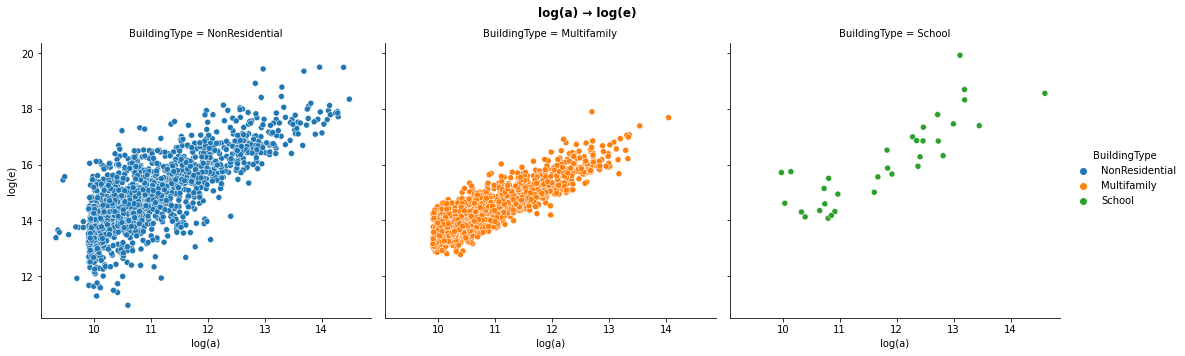

In [5]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [6]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [7]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6787330488811951
 OLS R2 score 0.678733048881195
features : ['btype_Multifamily' 'btype_NonResidential' 'btype_School' 'log(a)']
intercept (ols) : [3.55049406]
intercept (nnls) : [3.16456116]
coefficients (ols) : [[-0.3859329   0.03991235  0.34602055  1.02587285]]
coefficients (nnls) : [[0.         0.42584525 0.73195345 1.02587285]]


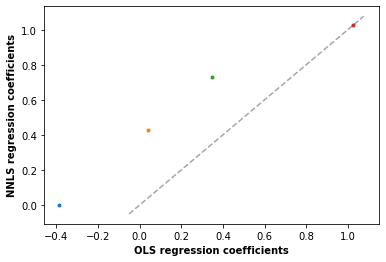

In [9]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [10]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.709864280243153
SM OLS R2 score 0.6787330488811951
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     647.6
Date:                Thu, 10 Nov 2022   Prob (F-statistic):          8.53e-213
Time:                        10:44:27   Log-Likelihood:                -721.91
No. Observations:                 798   AIC:                             1452.
Df Residuals:                     794   BIC:                             1471.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

#### Validation croisée du score OLS

0,63 contre 0,56 sans `btype`

In [11]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.69833914 0.54866449 0.64485405]
mean scores : 0.6306192265111306
std scores : 0.06192790341106927


## Config 12 : $\ln{e} = f(\ln{a}, t_p)$

Contribution de `ptype`.

$\{t_p, \log(a) : \log(e)\}$

Gain significatif : 0,152773309.

$R^2_{12} \left(\{t_p, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.7210437373349693$
* $\sigma = 0.04229253973342958$

Pour comparaison :

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

$R^2_{11} \left(\{t_b, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.6306192265111306$
* $\sigma = 0.06192790341106927$

#### Jeu de données

In [17]:
config_name = "{t_p, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

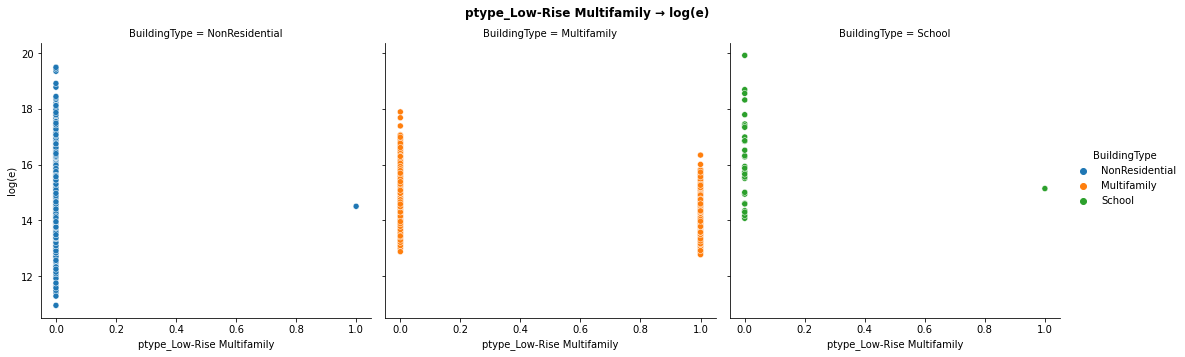

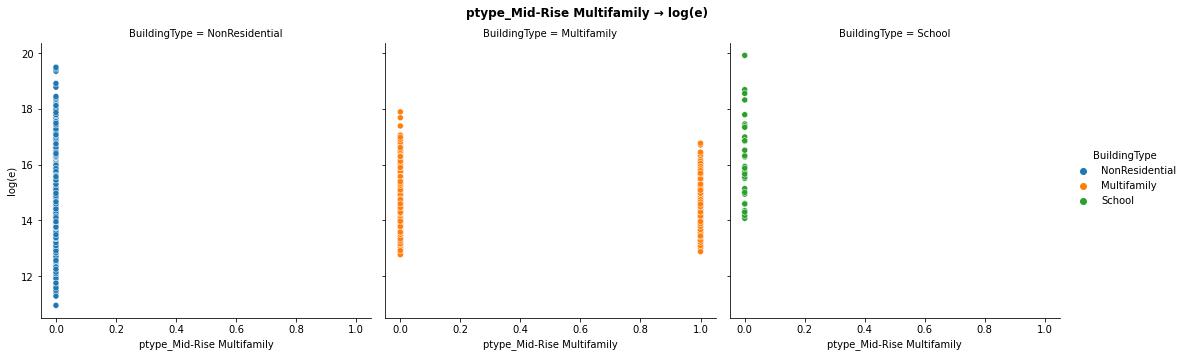

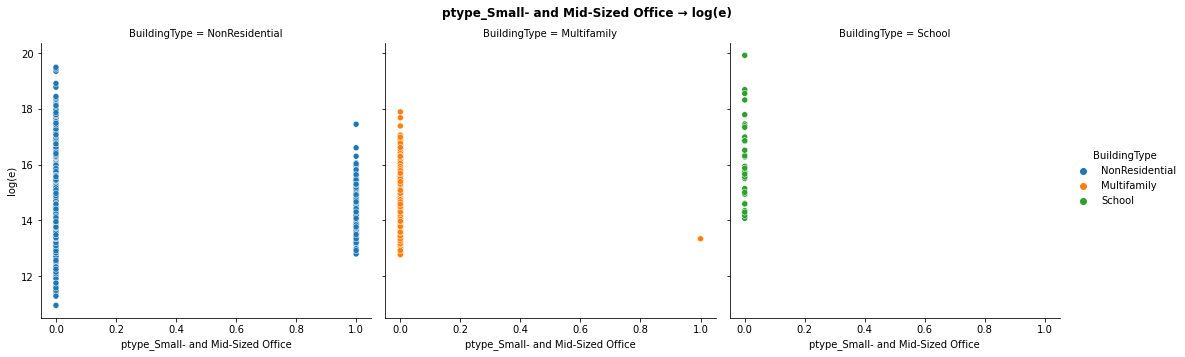

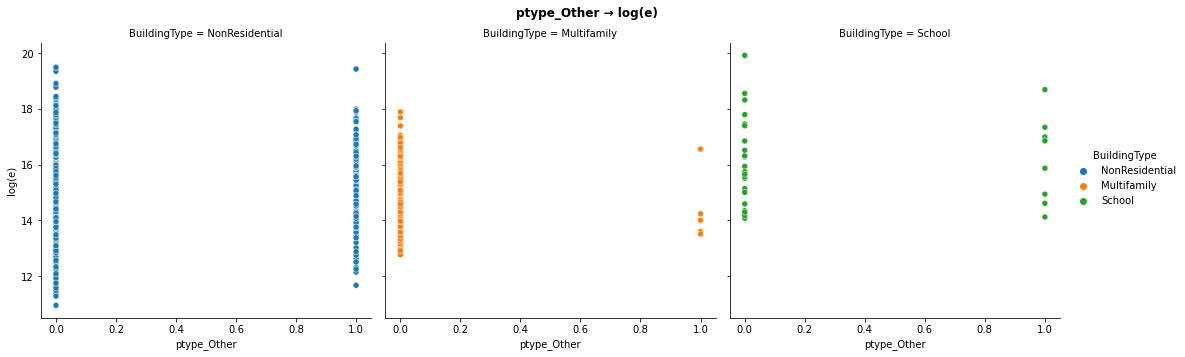

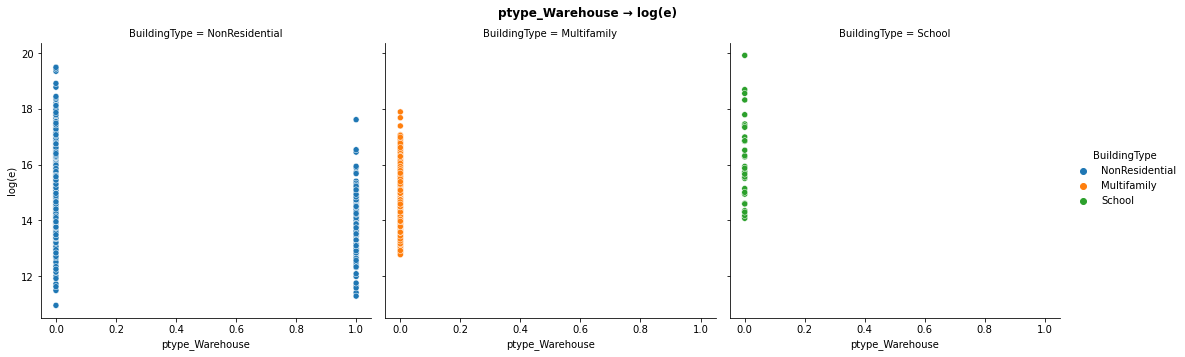

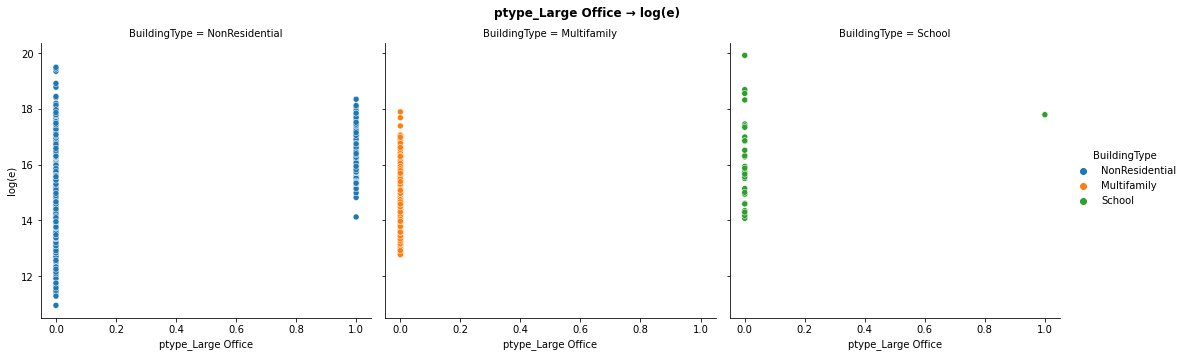

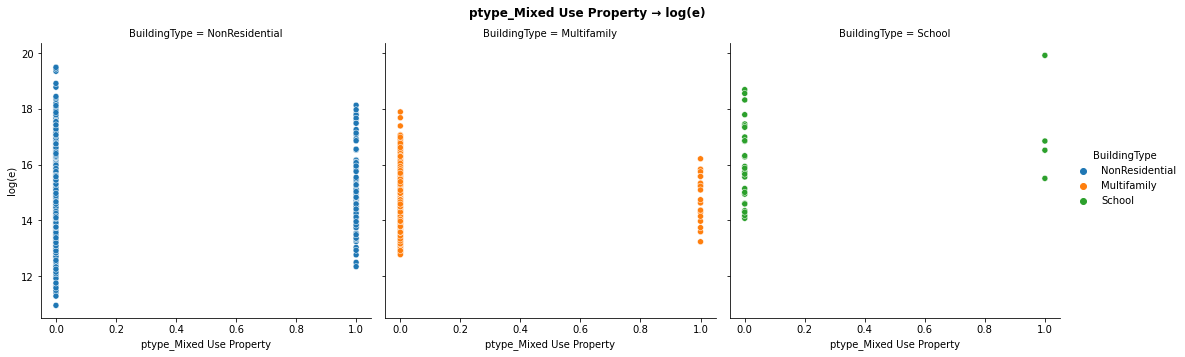

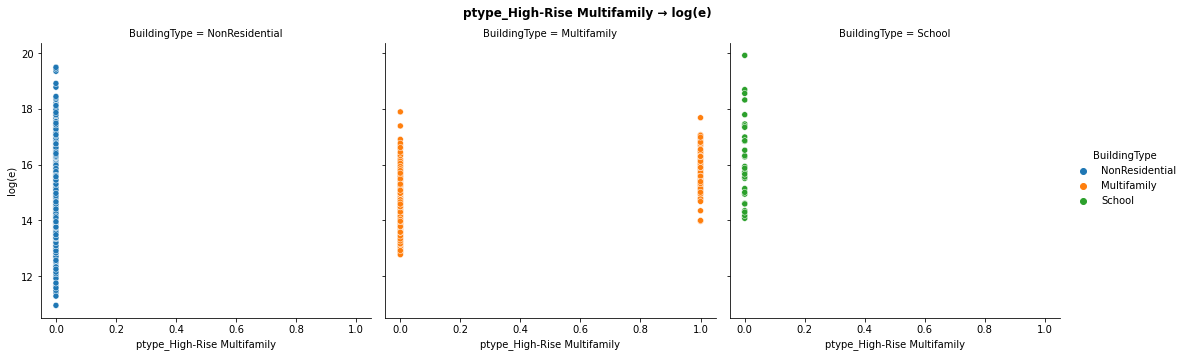

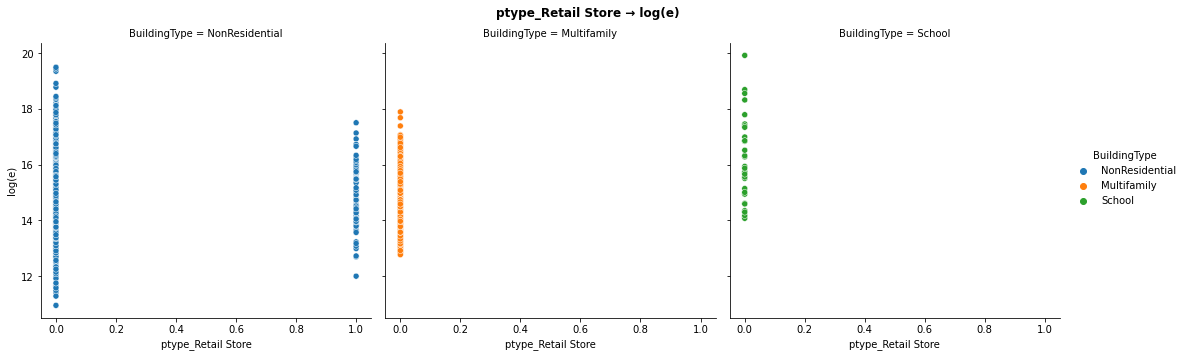

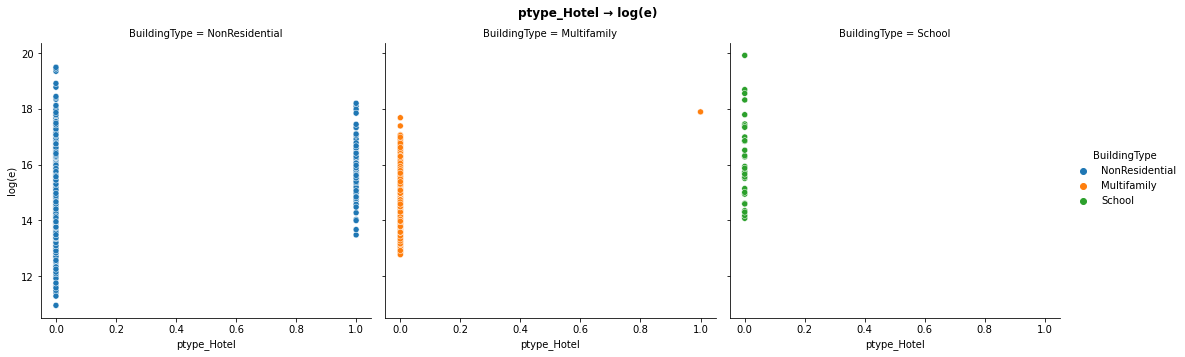

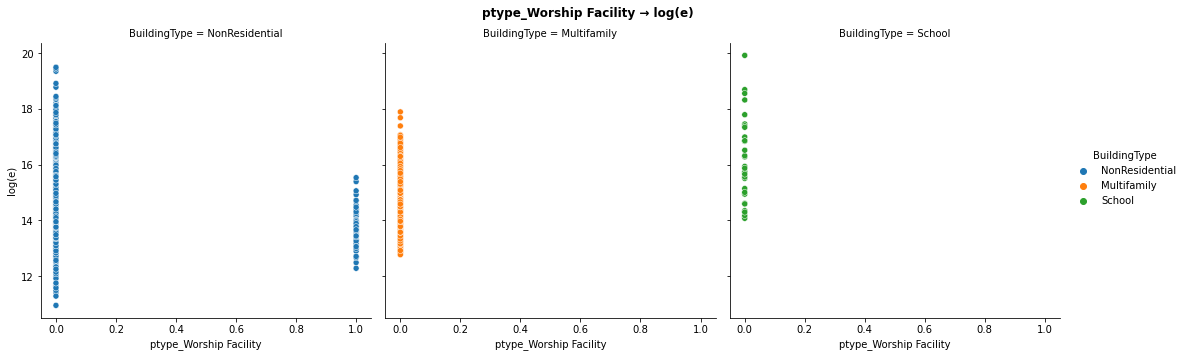

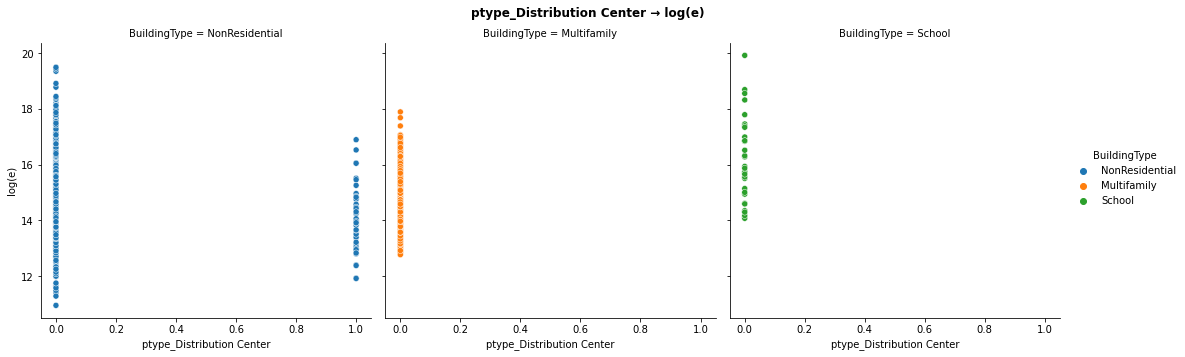

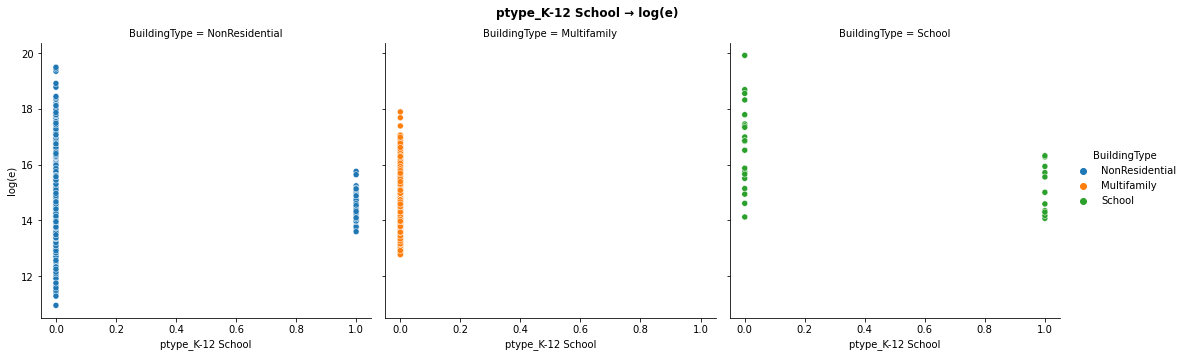

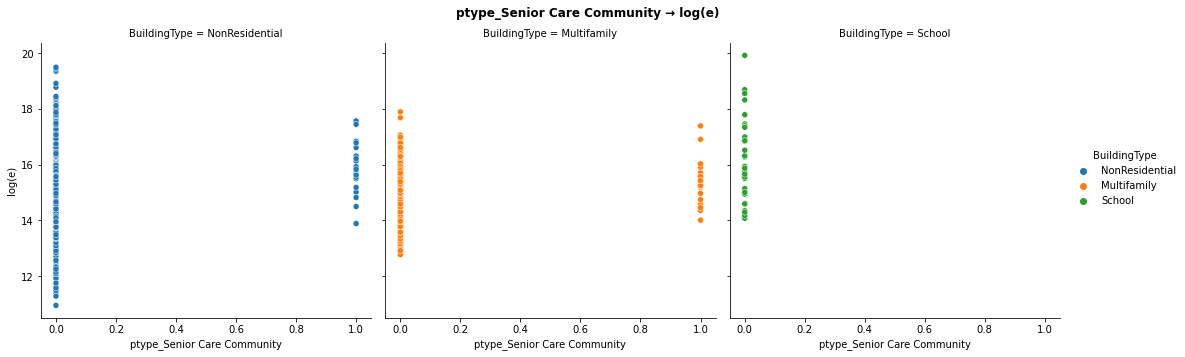

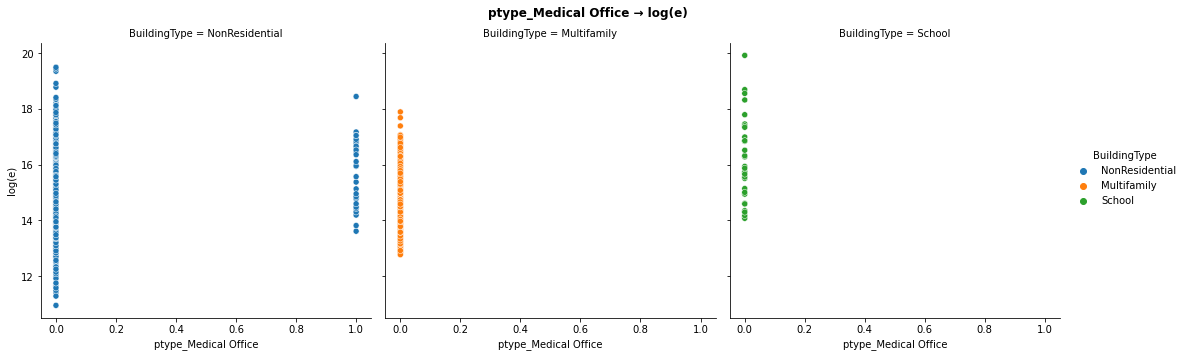

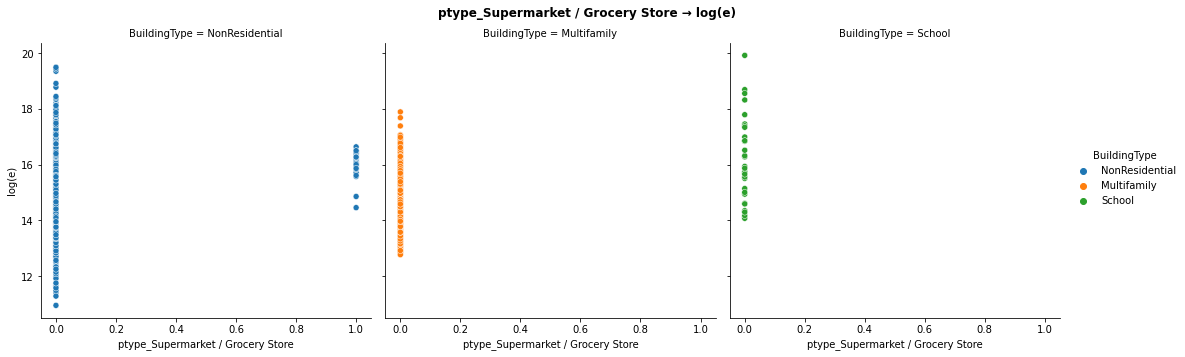

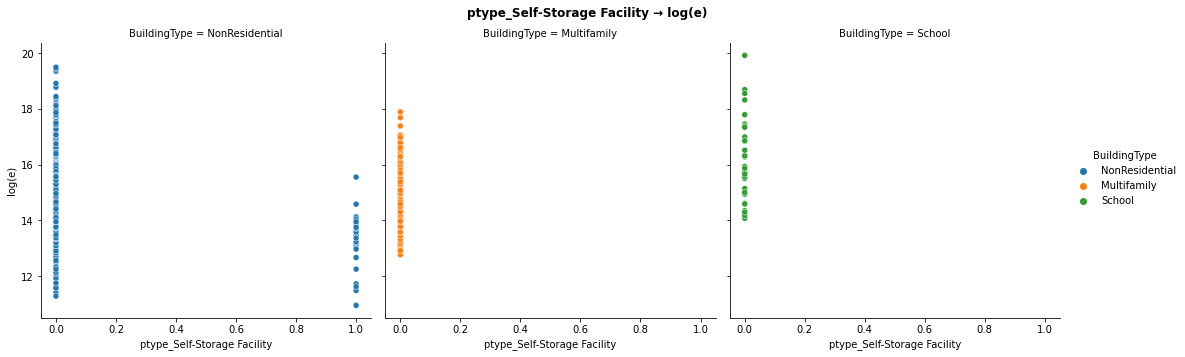

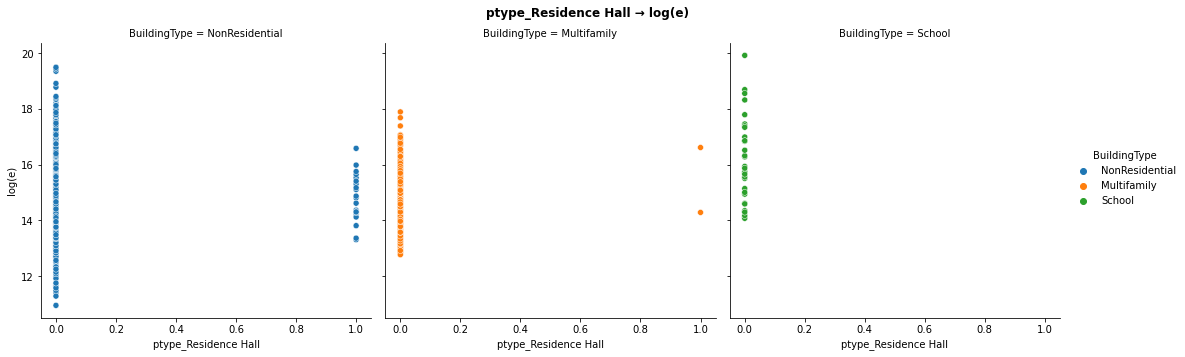

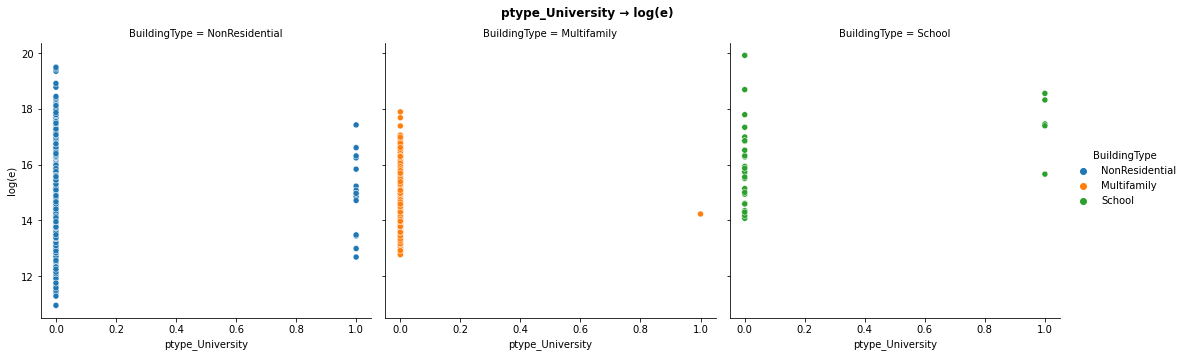

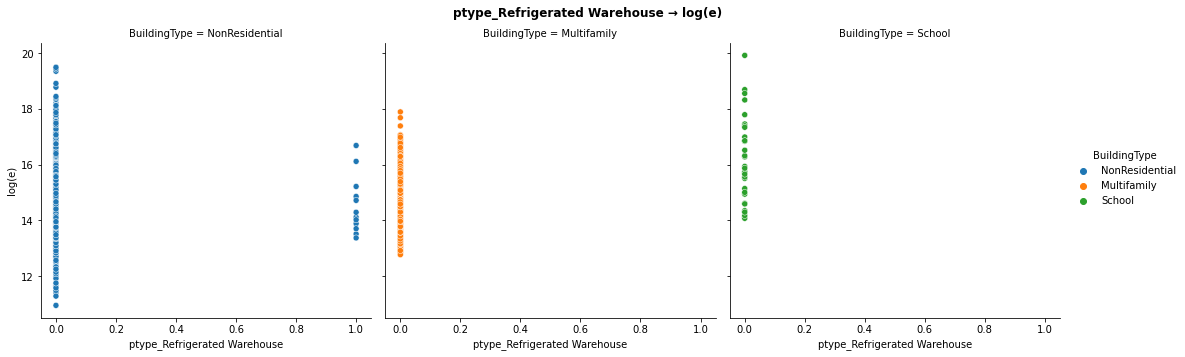

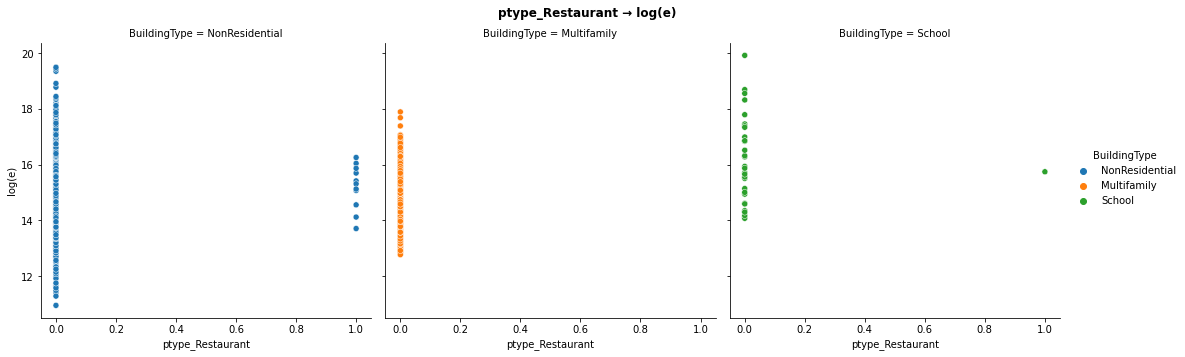

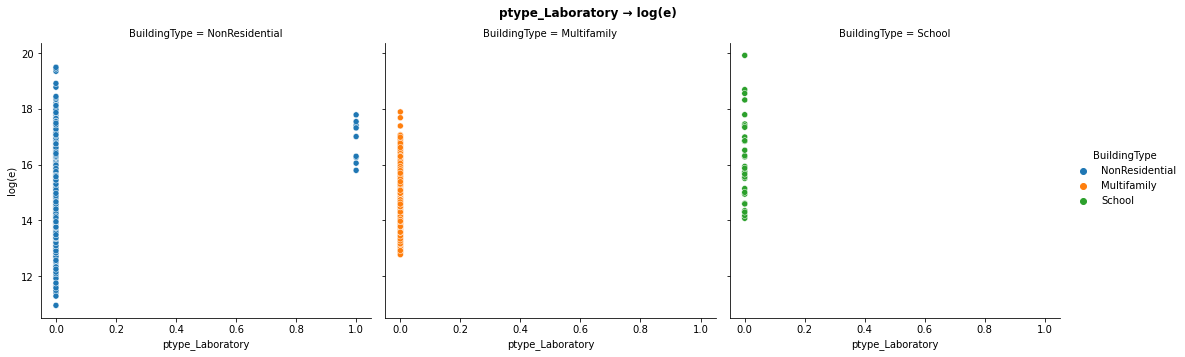

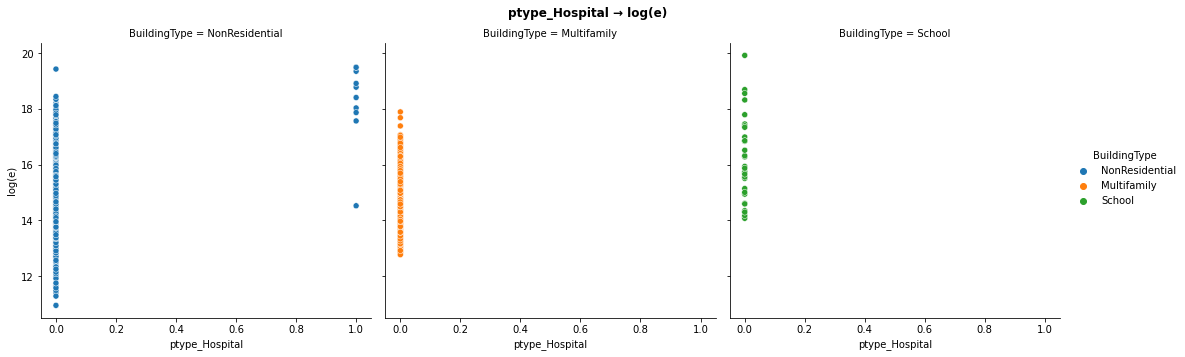

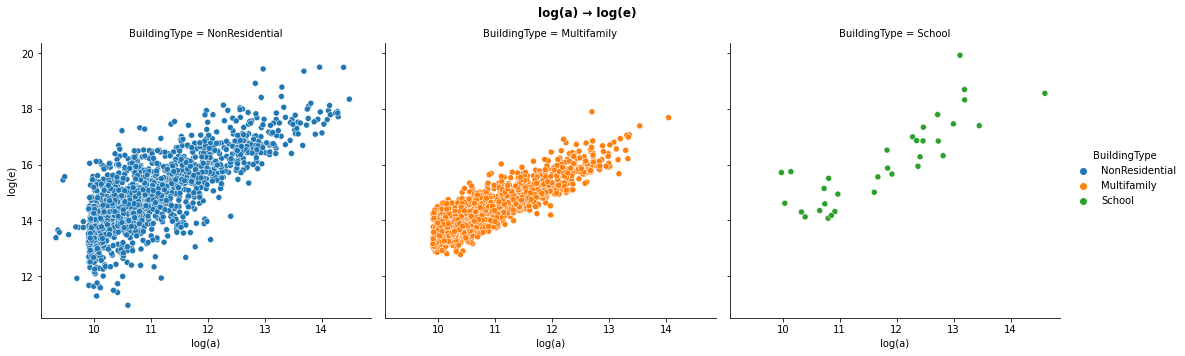

In [24]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [14]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [18]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.7576427878881438
 OLS R2 score 0.7576427878881438
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'log(a)']
intercept (ols) : [4.57146017]
intercept (nnls) : [3.00158984]
coefficients (ols) : [[-0.56821141 -0.49619337 -0.06300165  0.16965967 -0.68012616 -0.01241079
  -0.27846067 -0.08182841 -0.09306079  0.24448327 -0.40648718 -0.90657835
  -0.15865932 -0.05038772  0.29331281  1.28717162 -1.56987033 -0.11495027
  -0.04878346  0.07005635  0.9577355   

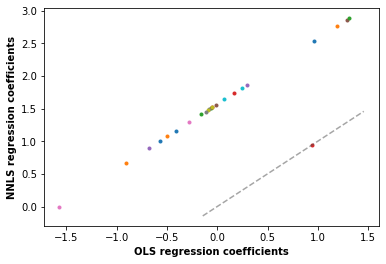

In [19]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

In [20]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.7901116923175011
SM OLS R2 score 0.7576427878881435
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     126.7
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          5.02e-244
Time:                        15:56:55   Log-Likelihood:                -592.73
No. Observations:                 798   AIC:                             1233.
Df Residuals:                     774   BIC:                             1346.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

#### Validation croisée du score OLS

In [19]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.76598086 0.66439215 0.7327582 ]
mean scores : 0.7210437373349693
std scores : 0.04229253973342958


## Config 13 : $\ln{e} = f(\ln{a}, t_p, t_b)$

Contribution de `btype` + `ptype`.

$\{t_b, t_p, \log(a):\log(e)\}$

Amélioration marginale de l'ordre de 0,004 par rapport à `ptype` seul.

$R^2_{13} \left(\{t_b, t_p, \log(a):\log(e)\}\right)$ :
* $\mu = 0.7249152370998896$
* $\sigma = 0.04175007296498173$

Pour comparaison :

$R^2_{12} \left(\{t_p, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.7210437373349693$
* $\sigma = 0.04229253973342958$

$R^2_{11} \left(\{t_b, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.6306192265111306$
* $\sigma = 0.06192790341106927$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [21]:
config_name = "{t_b, t_p, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation

#### Vérifications

In [22]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [23]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

La NNLS est manifestement en saturation.

NNLS R2 score 0.7620086446398169
 OLS R2 score 0.7621910805670967
features : ['btype_Multifamily' 'btype_NonResidential' 'btype_School'
 'ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'log(a)']
intercept (ols) : [4.55066386]
intercept (nnls) : [-5.61855185e+12]
coefficients (ols) : [[-0.30283406  0.04744814  0.25538592 -0.2717149  -0.20153784 -0.11205081
   0.11200776 -0.73454069 -0.07187653 -0.25469757  0.21005054 -0.14790204
   0.18726911 -0.45979387 -0.96089506 -0.26510418

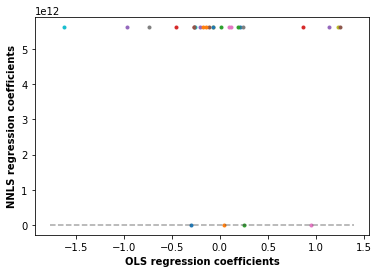

In [25]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives

On pourra raffiner en éliminant ces variables peu pertinentes.

In [26]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.7915382617990652
SM OLS R2 score 0.7621910805670971
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     117.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):          4.67e-243
Time:                        10:49:51   Log-Likelihood:                -590.01
No. Observations:                 798   AIC:                             1232.
Df Residuals:                     772   BIC:                             1354.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

#### Validation croisée du score OLS

`btype` est redondant avec `ptype` : l'ajouter n'apporte aucun de gain de performance.

In [27]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.77110738 0.66997081 0.73366752]
mean scores : 0.7249152370998896
std scores : 0.04175007296498173


## Config 14 : $\ln{e} = f(\ln{a}, (\tilde{a}_{u_k}))$

Contribution de la ventilation de la surface suivant les usages.

$\{(\tilde{a}_{u_k}), \log(a):\log(e)\}$

$R^2_{14} \left(\{(\tilde{a}_{u_k}), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6225481013361372$
* $\sigma = 0.08228628334571318$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [21]:
config_name = "{(_a_u_k)_k, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

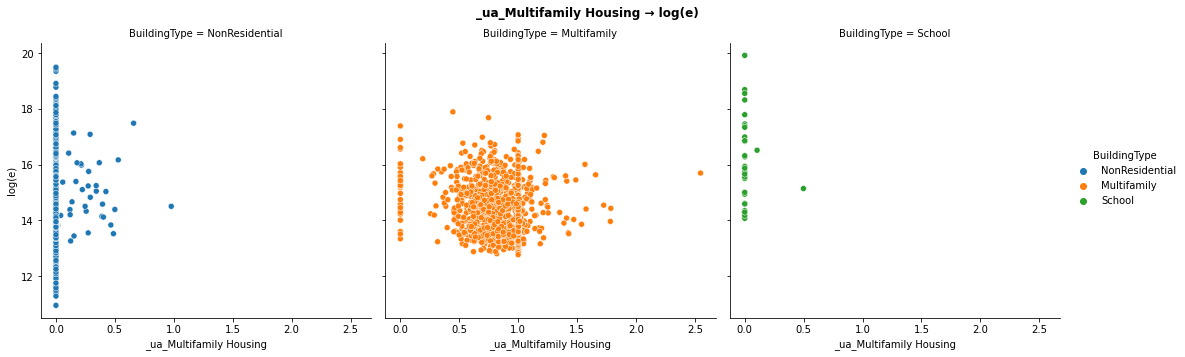

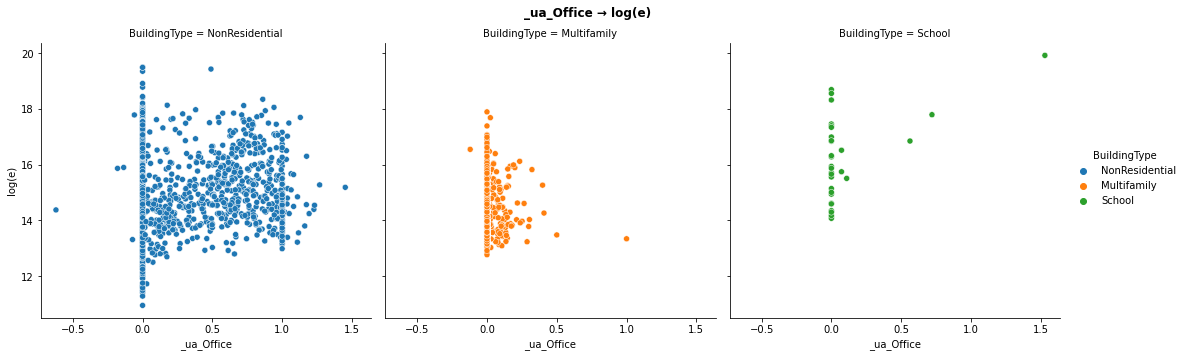

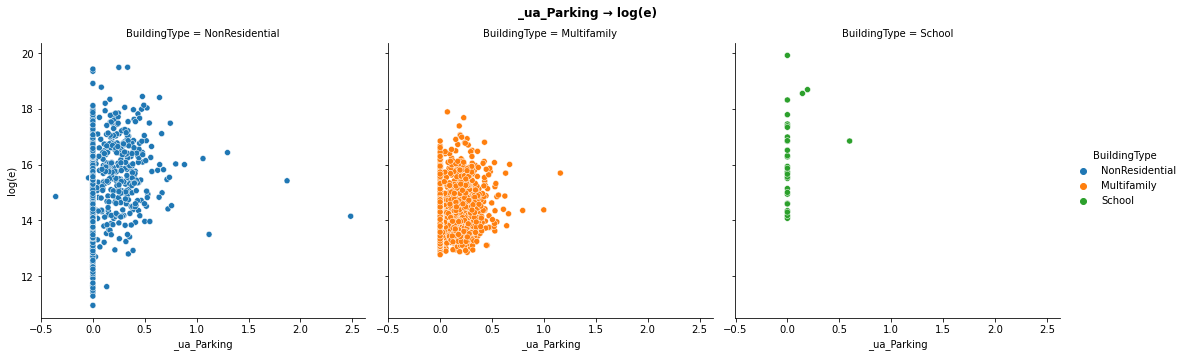

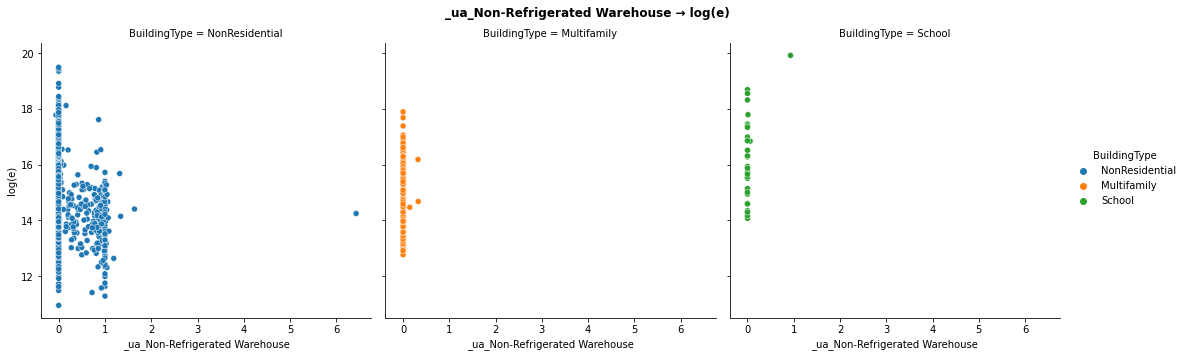

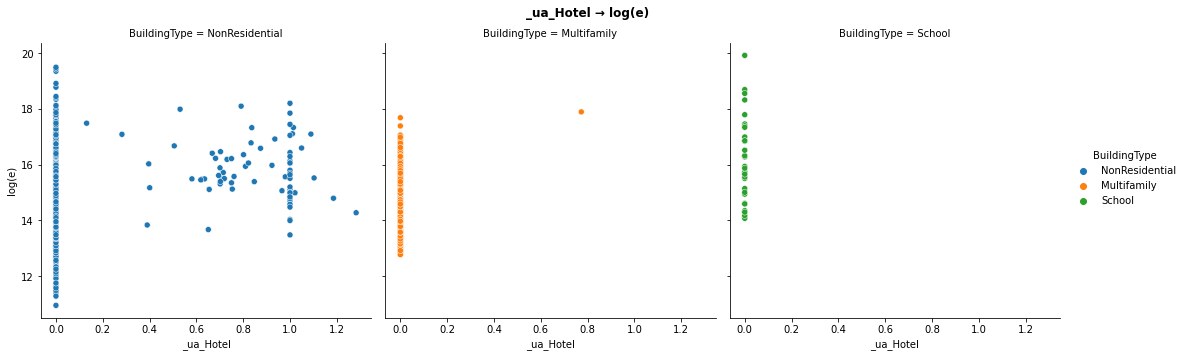

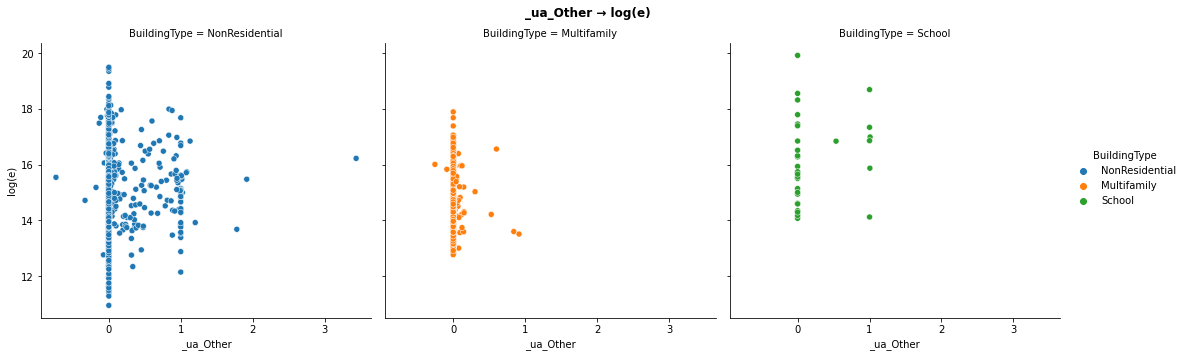

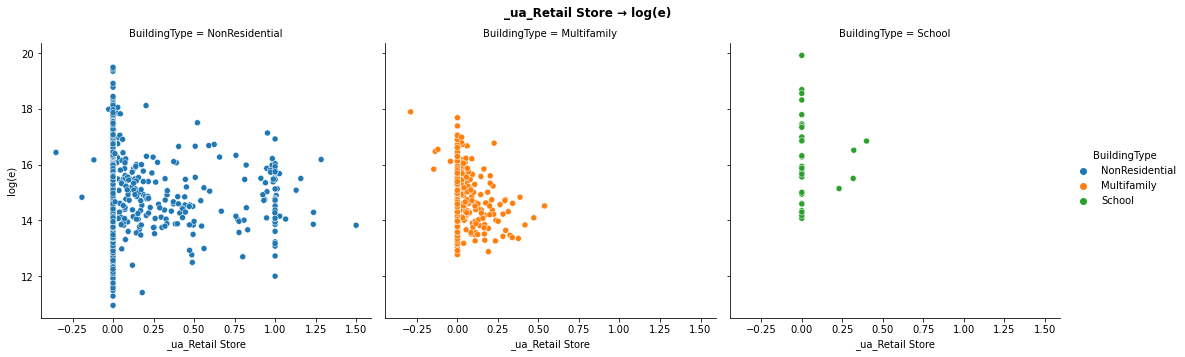

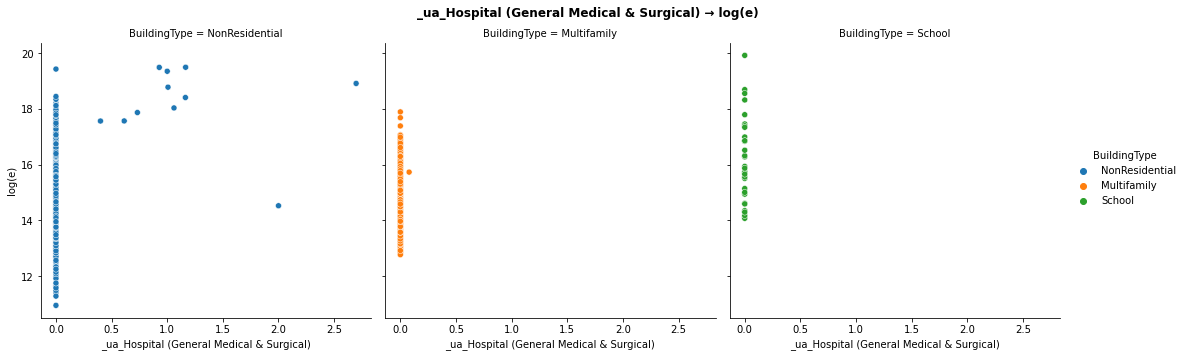

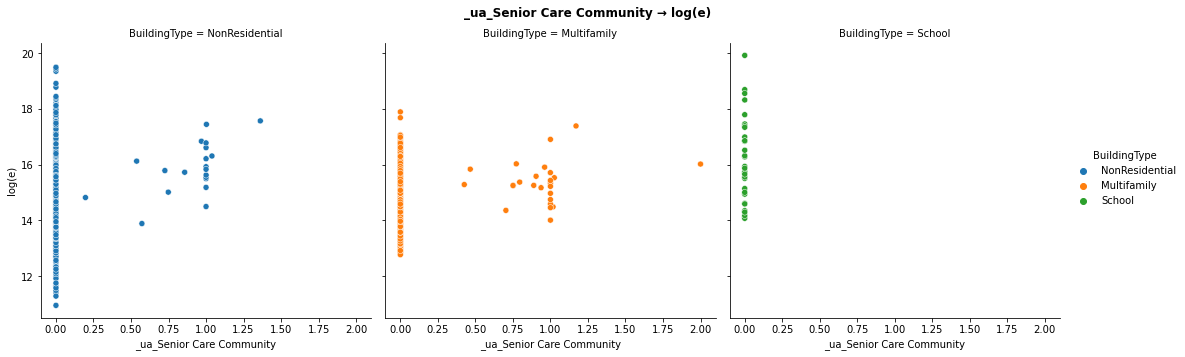

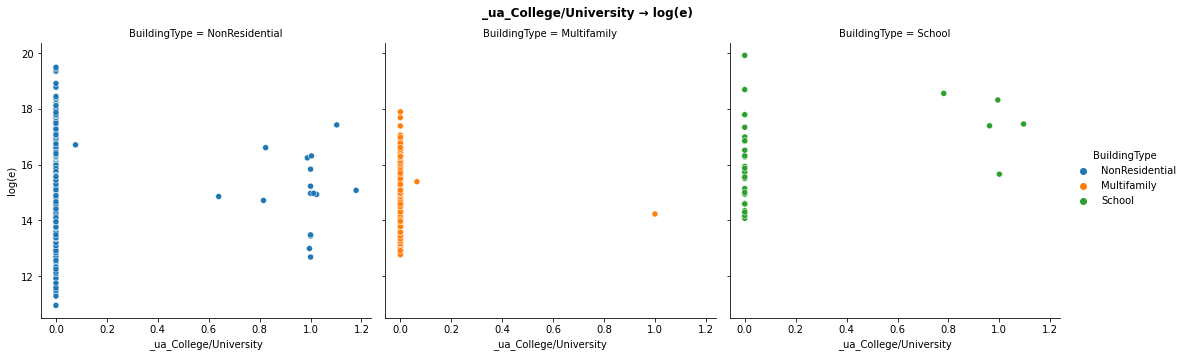

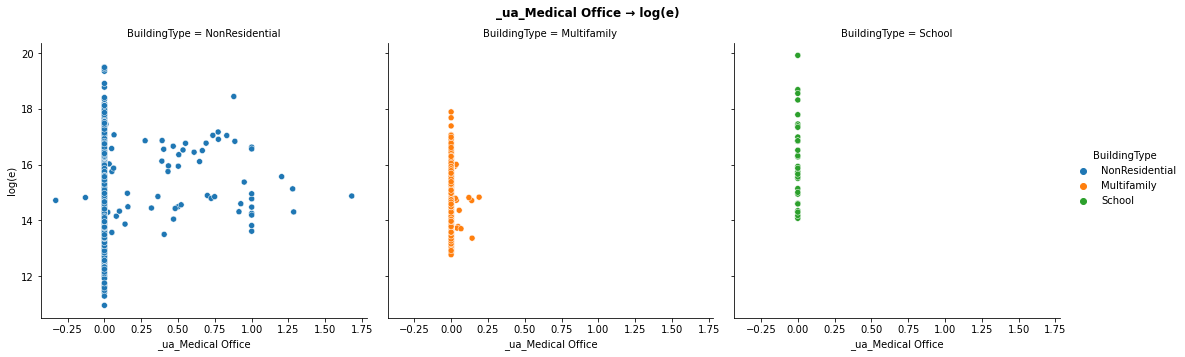

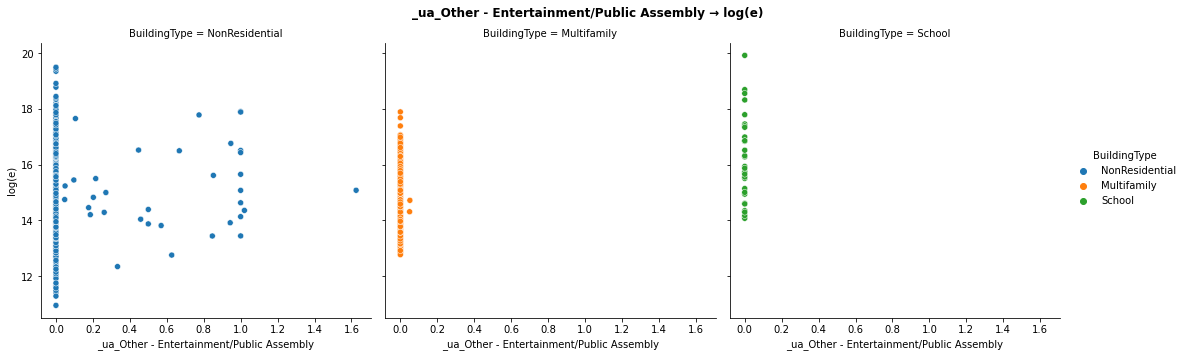

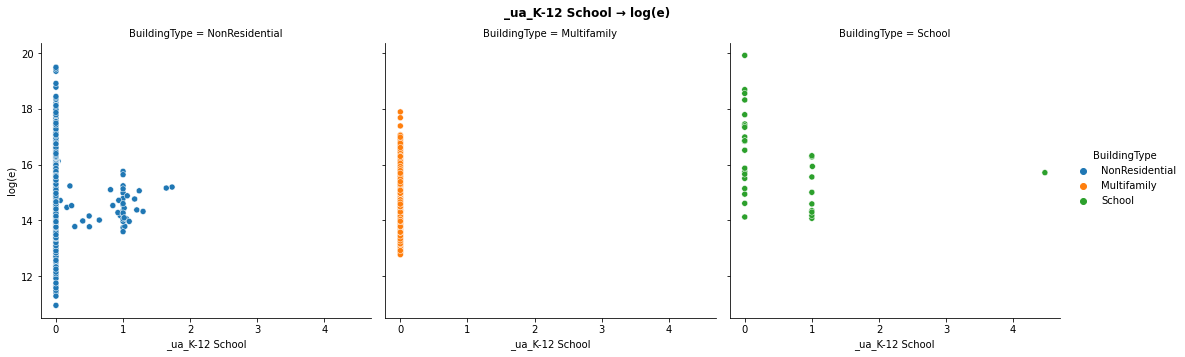

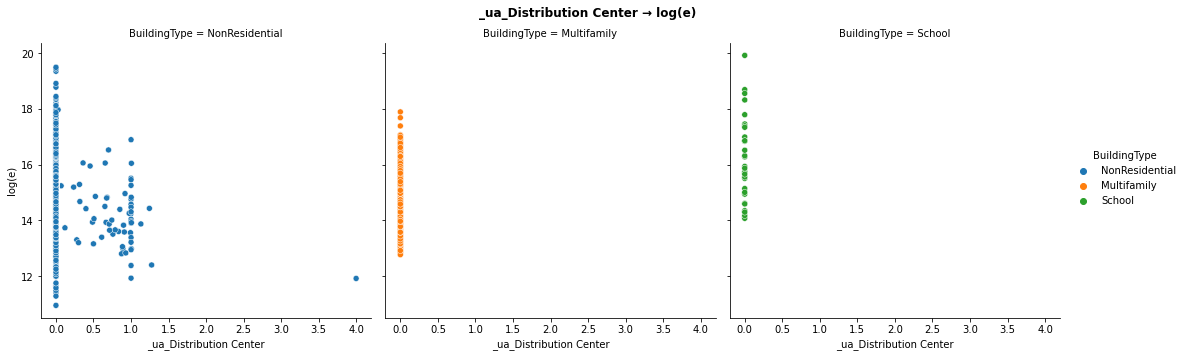

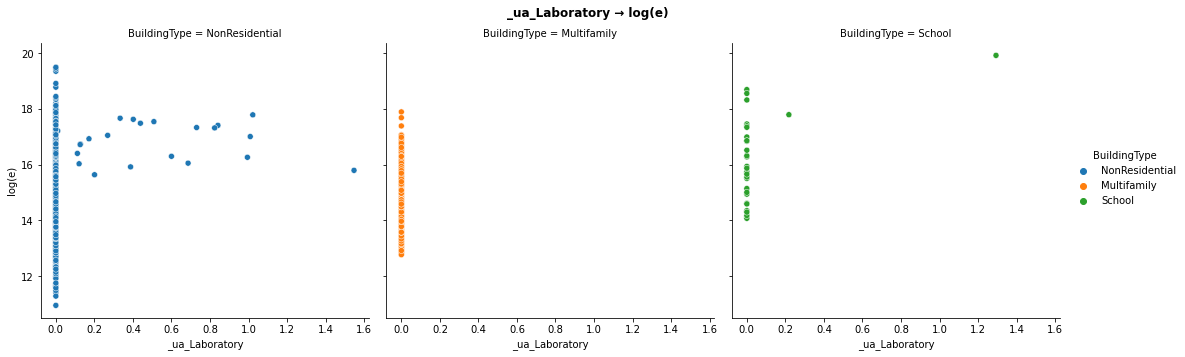

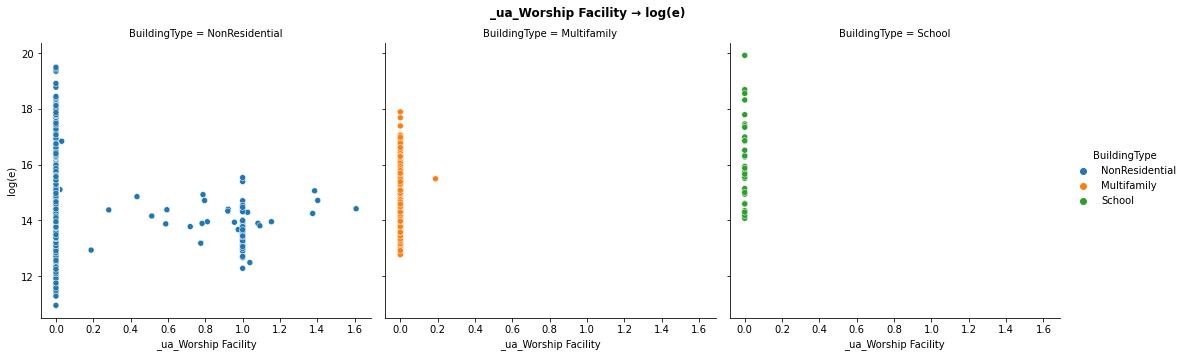

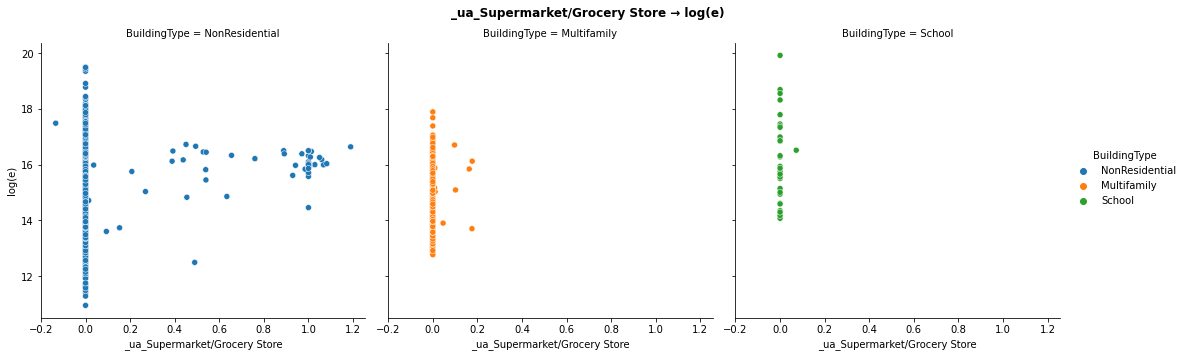

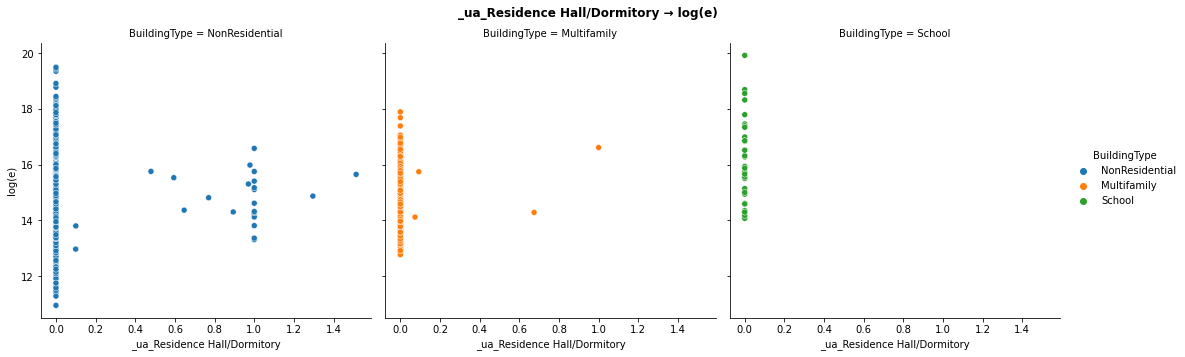

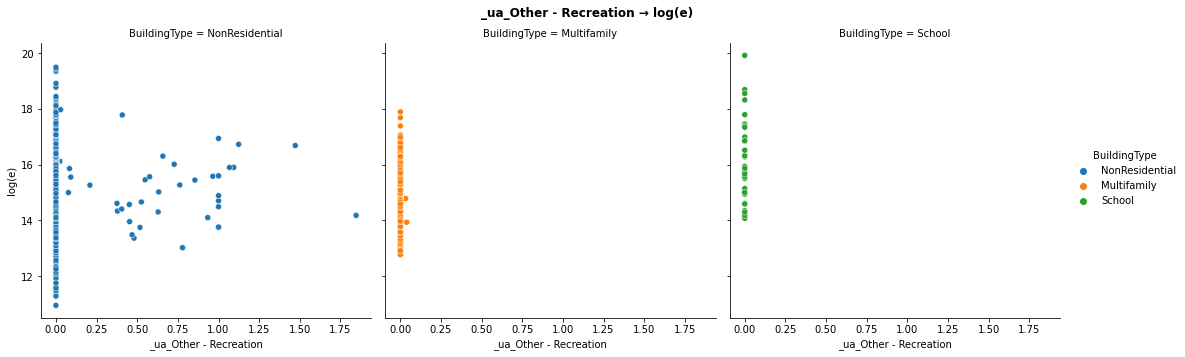

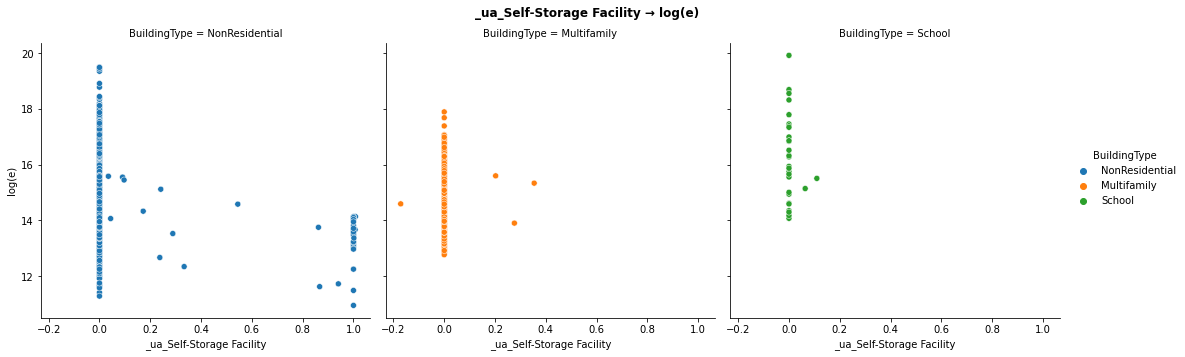

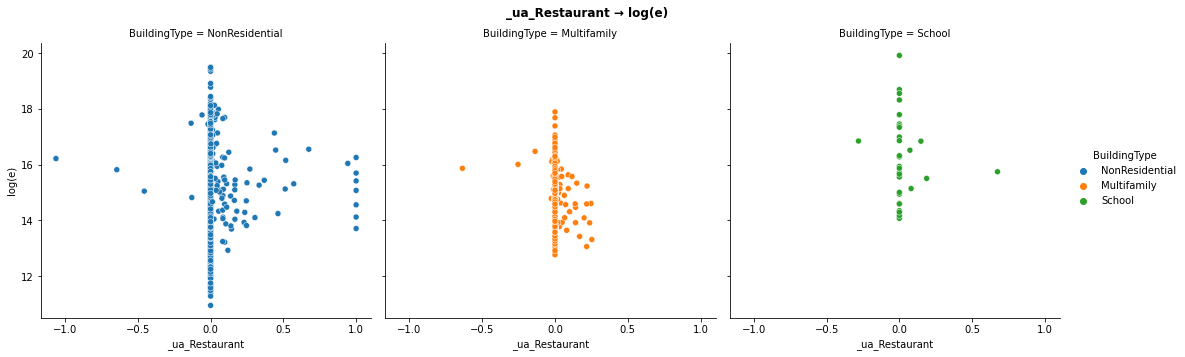

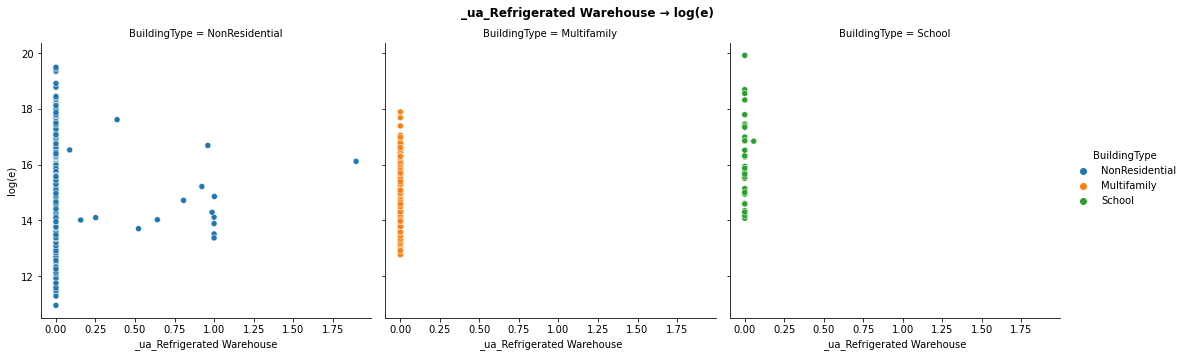

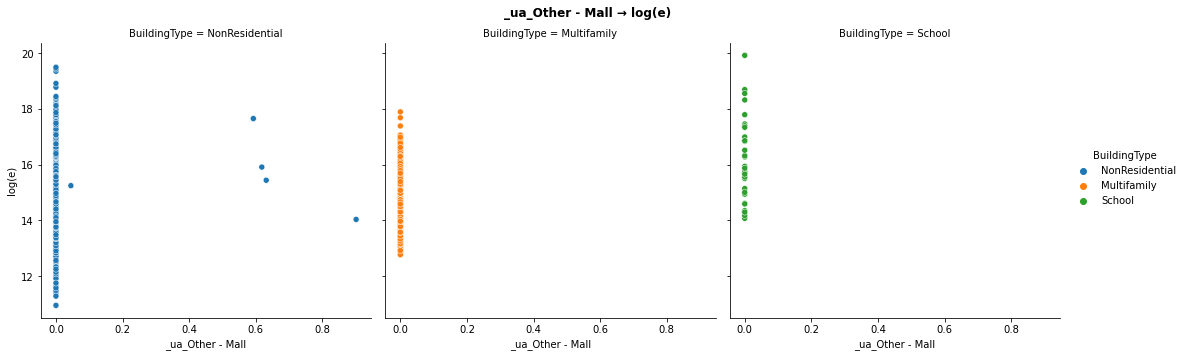

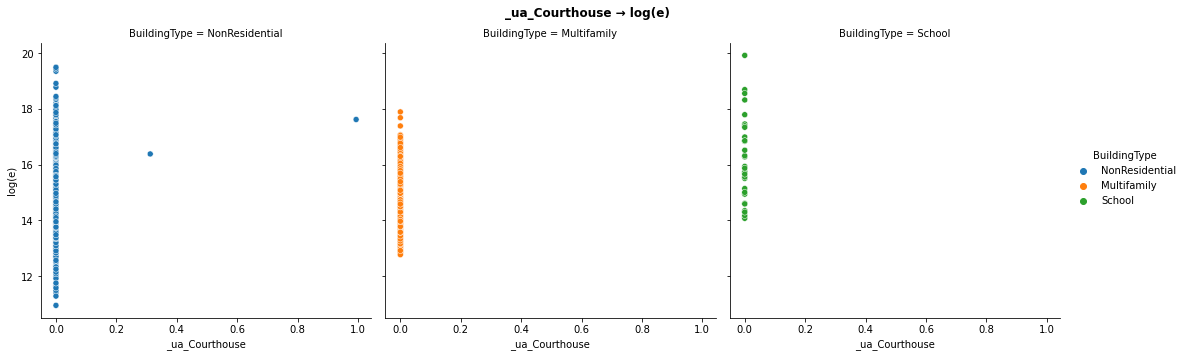

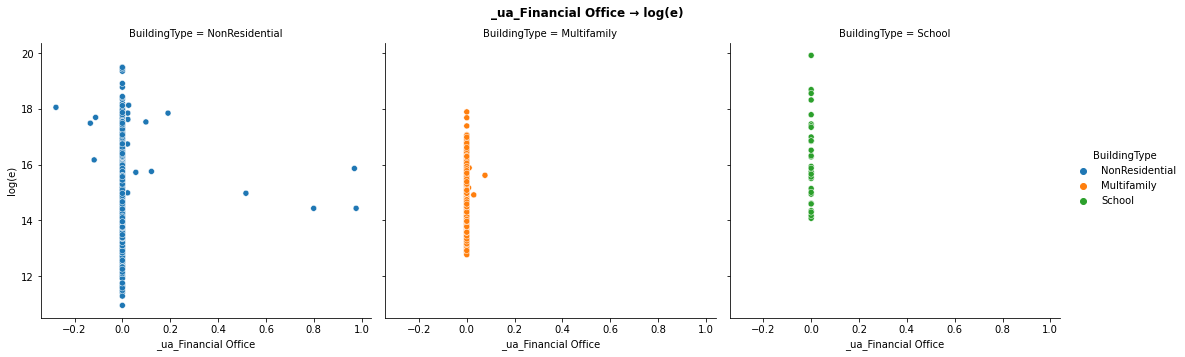

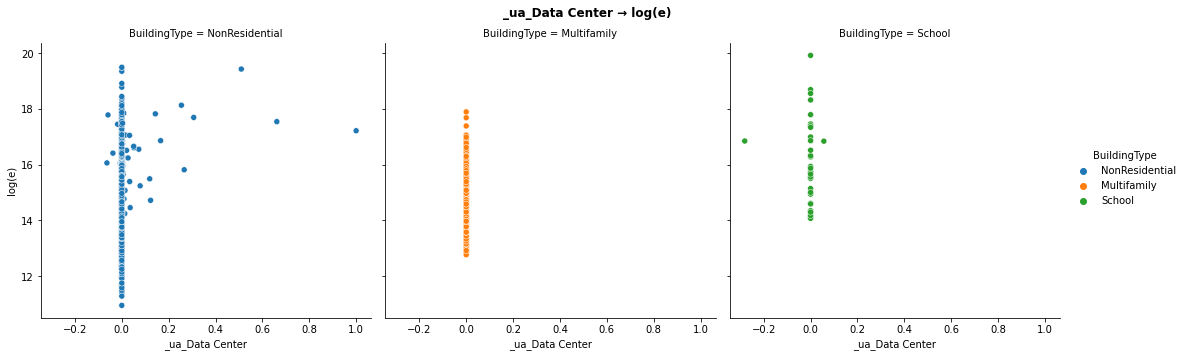

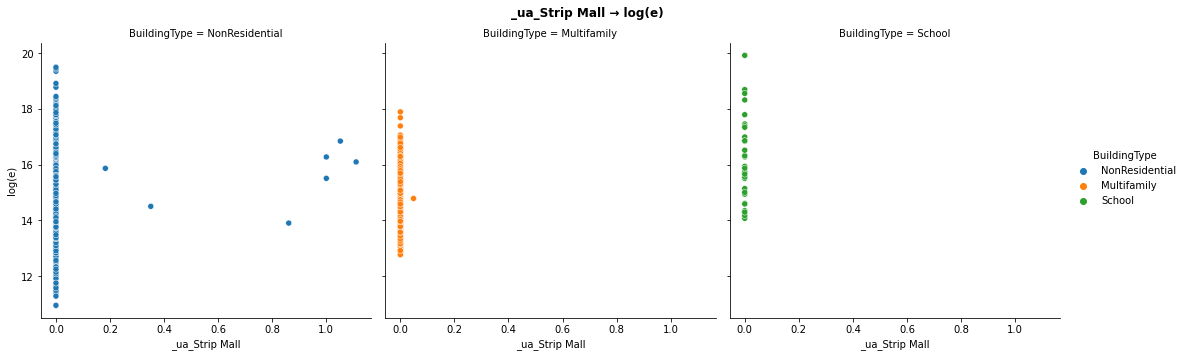

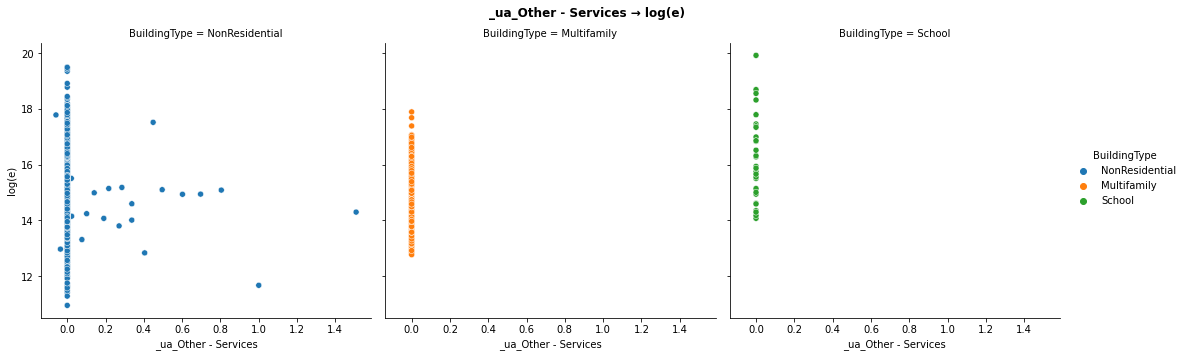

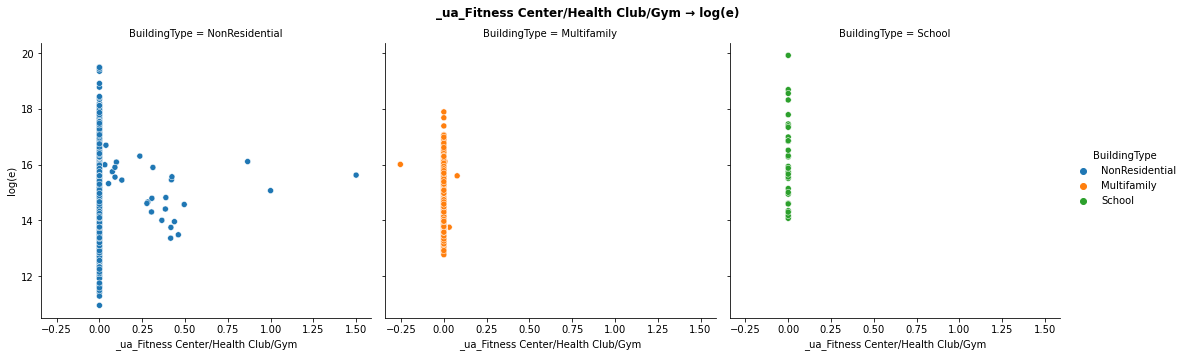

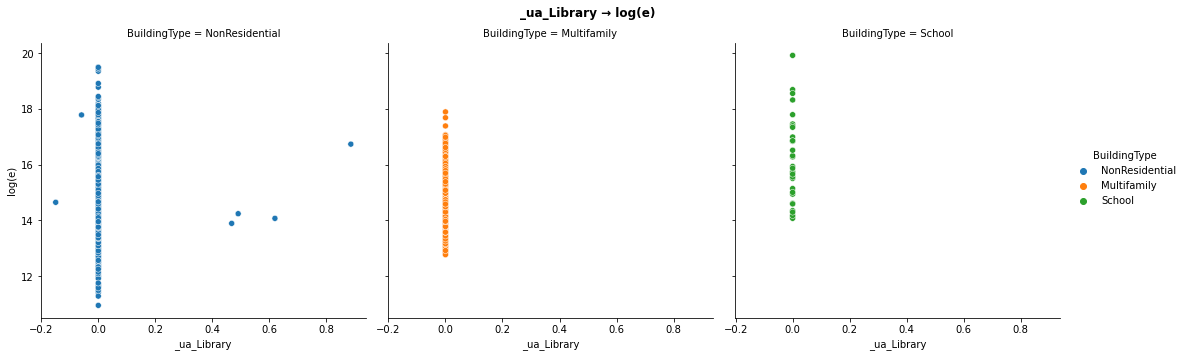

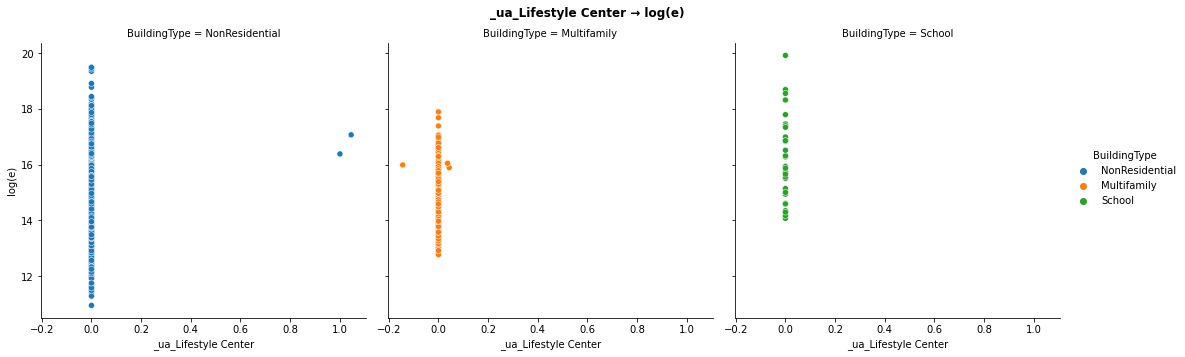

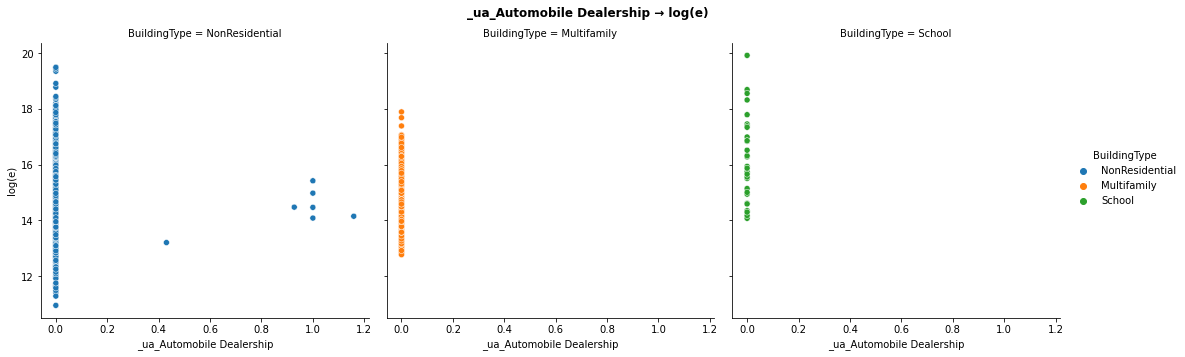

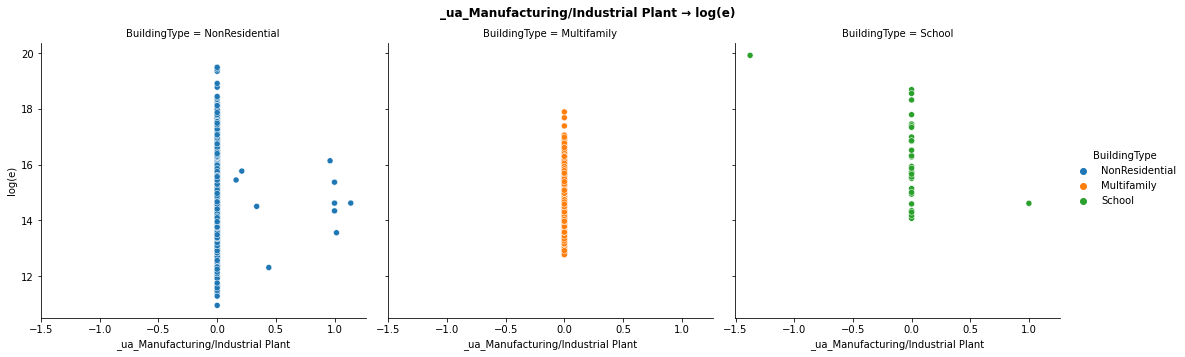

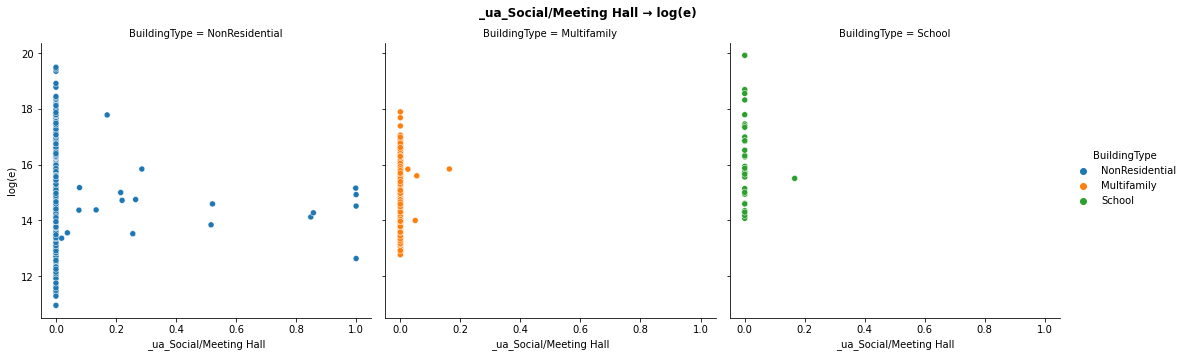

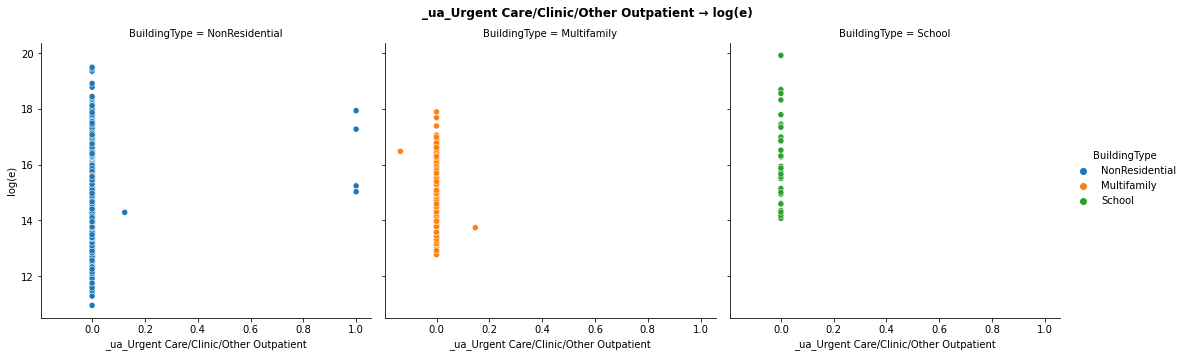

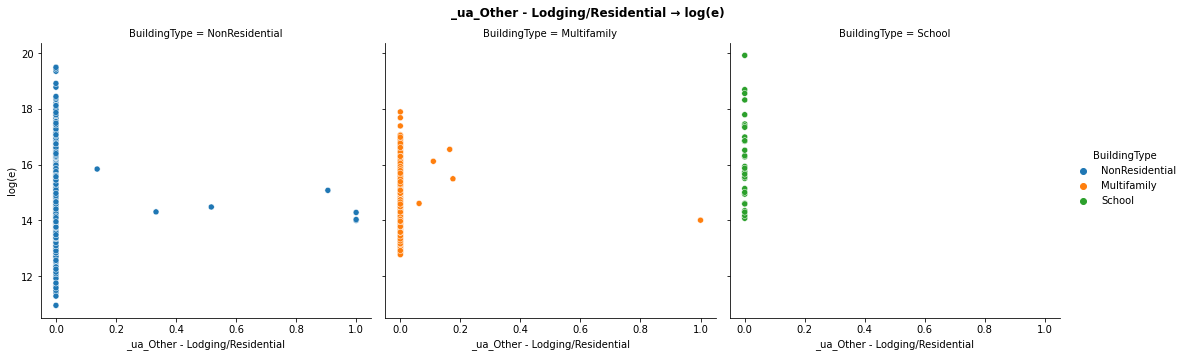

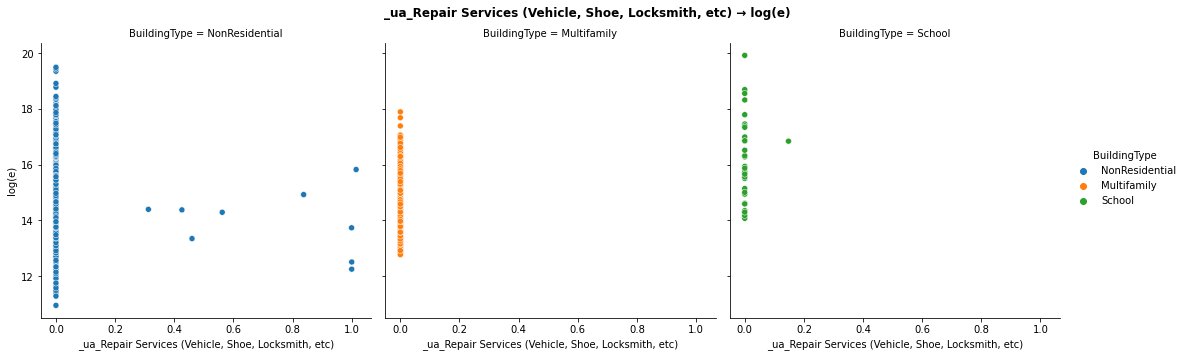

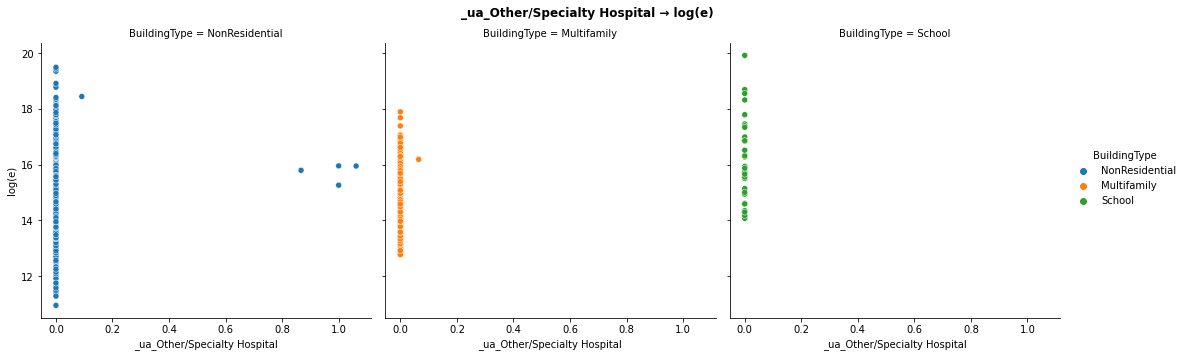

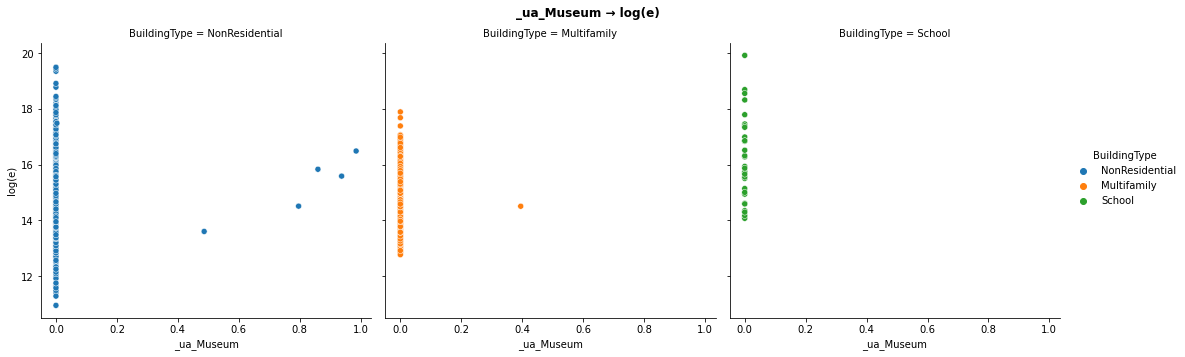

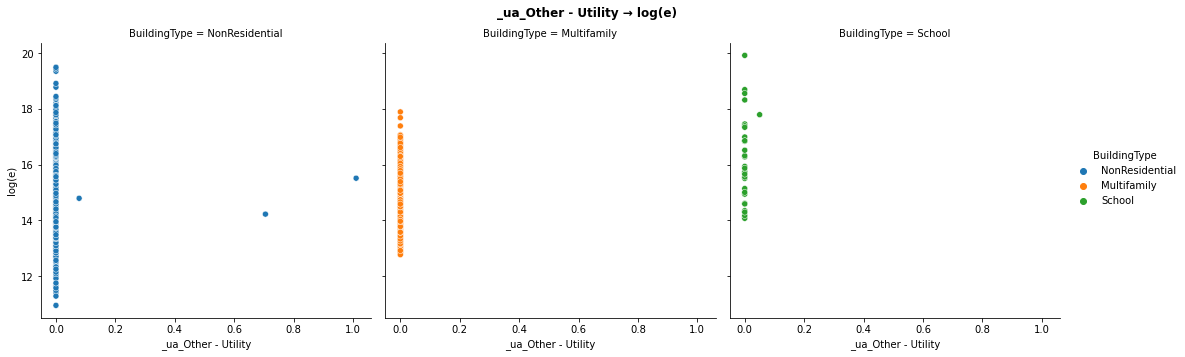

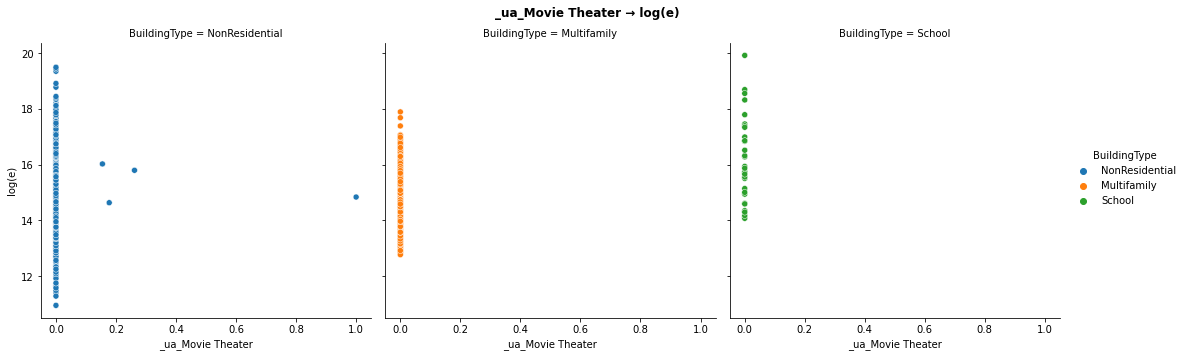

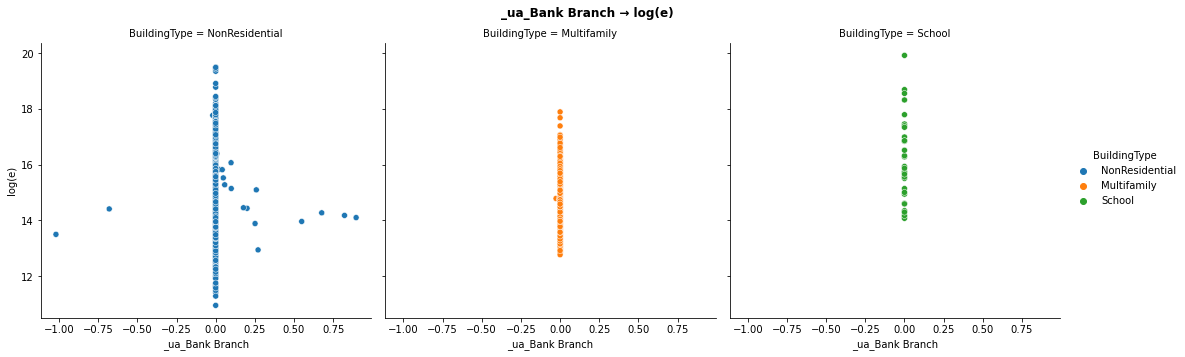

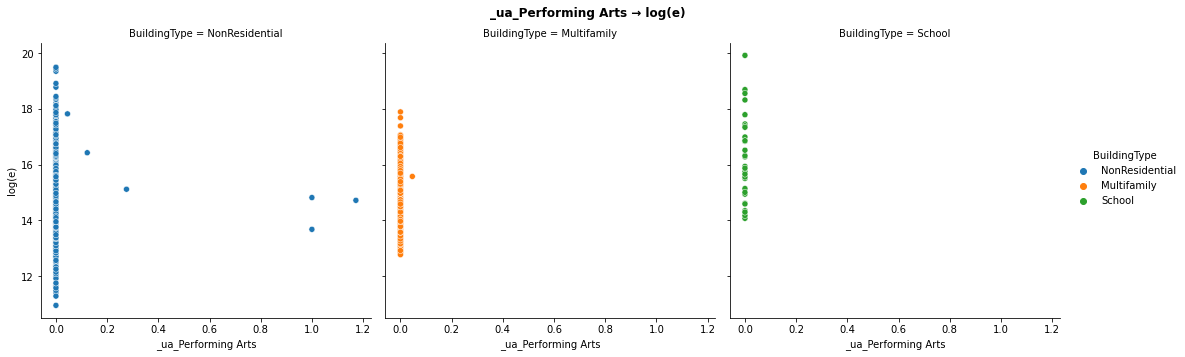

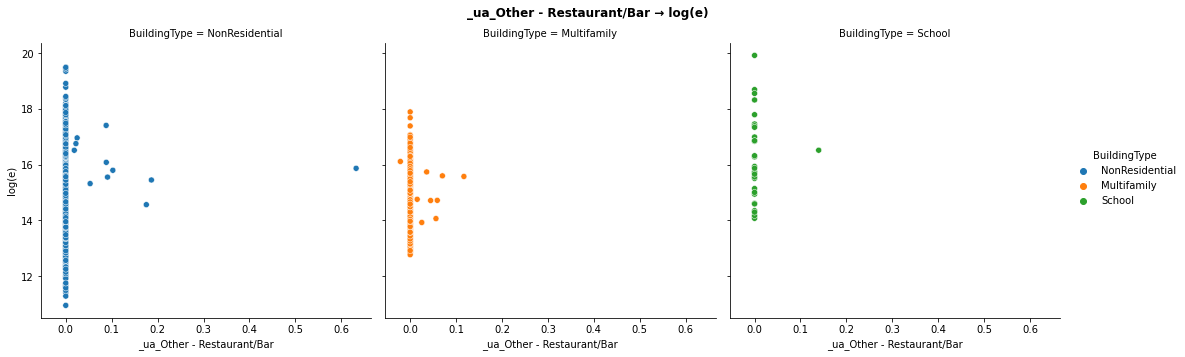

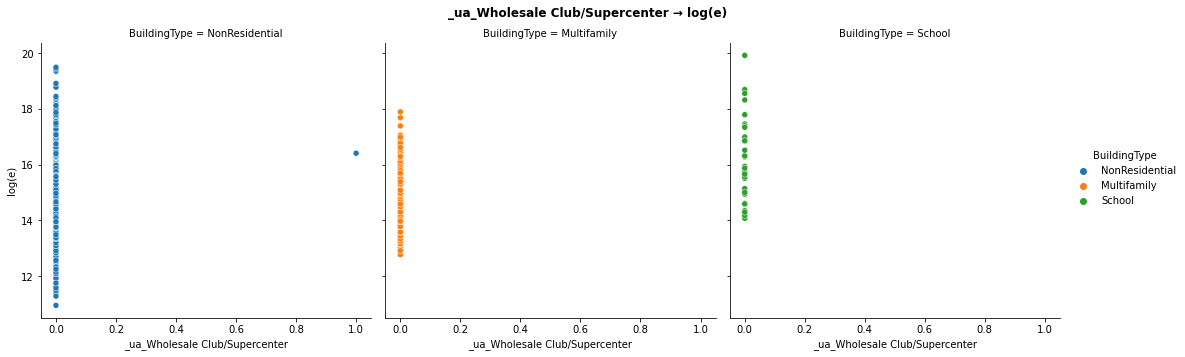

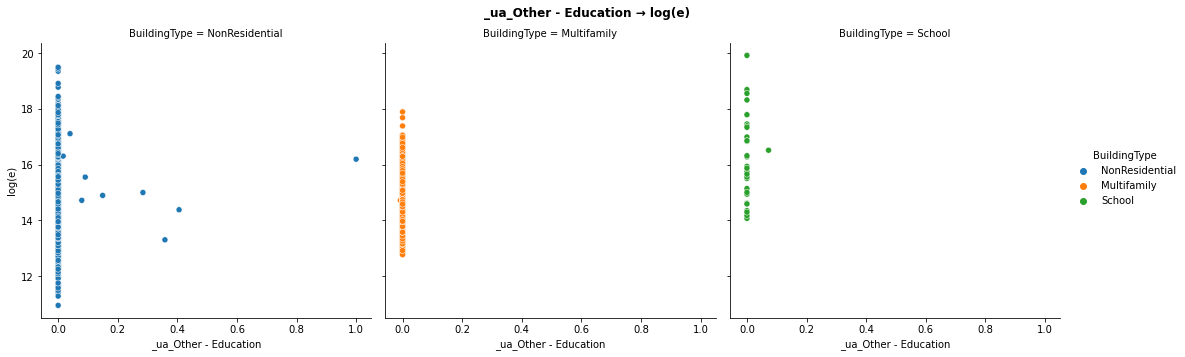

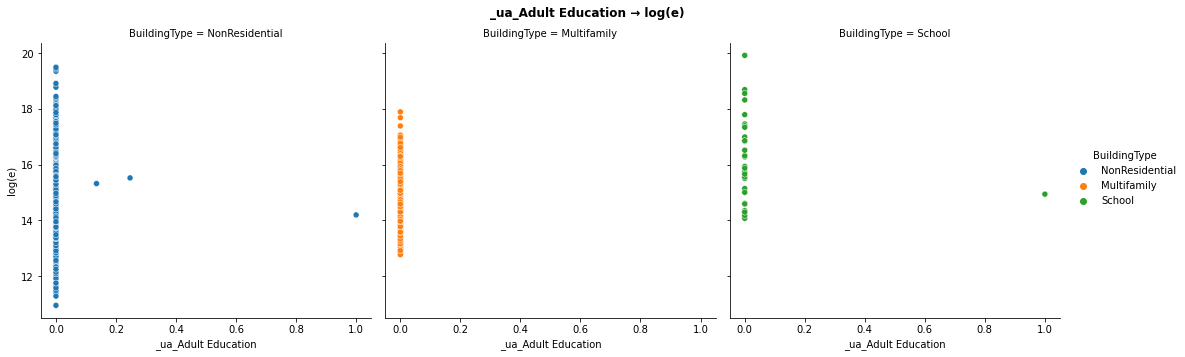

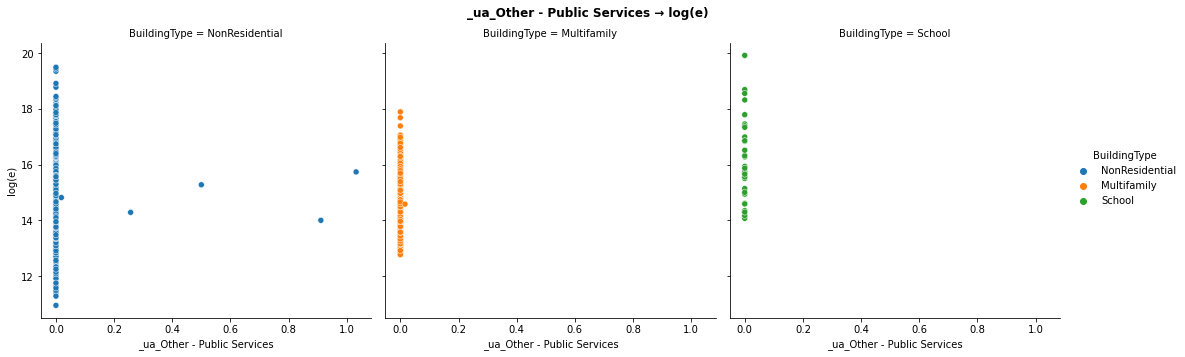

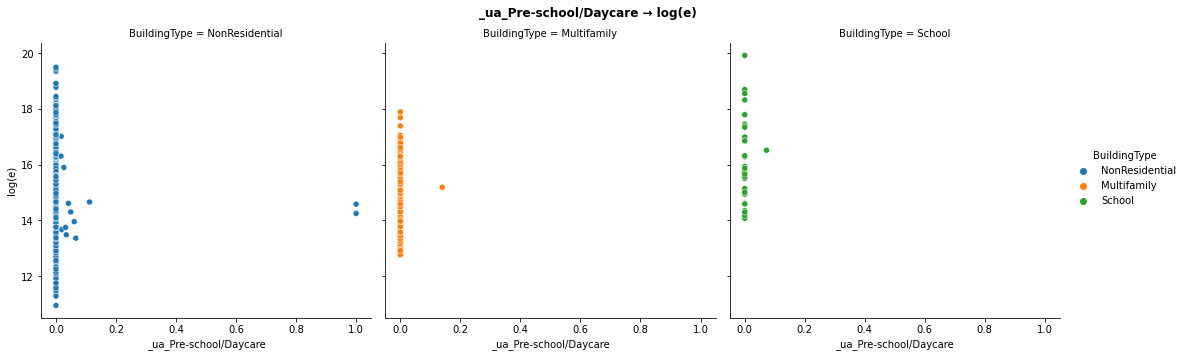

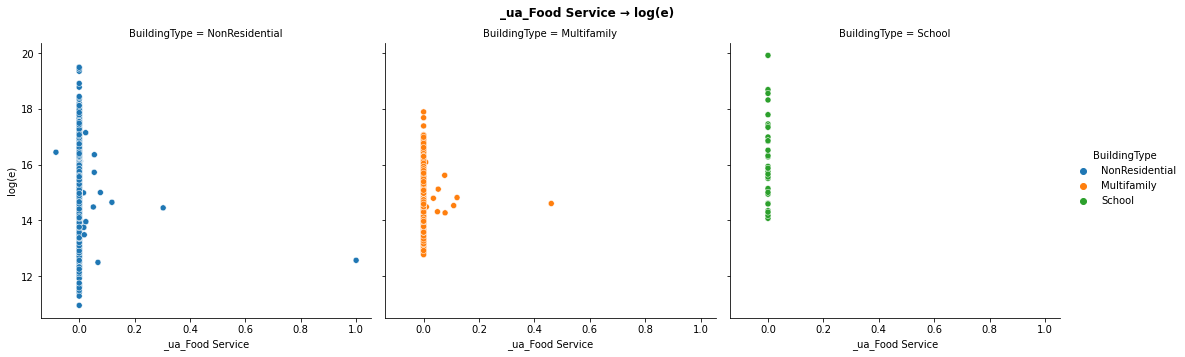

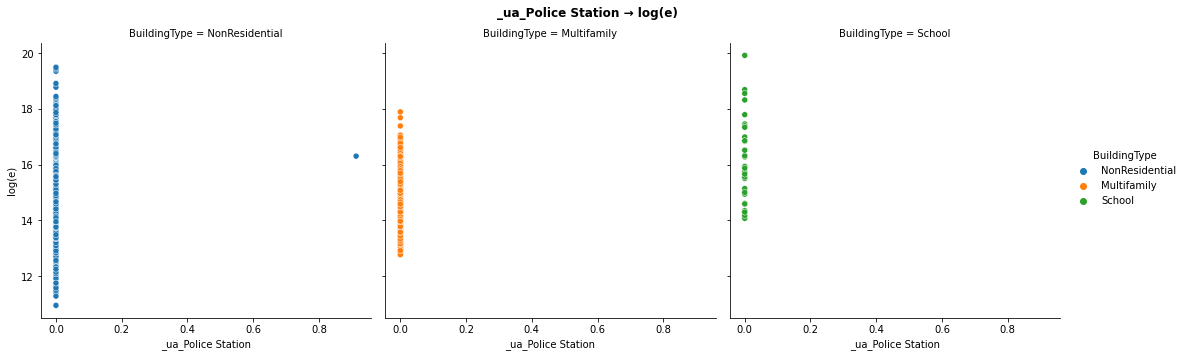

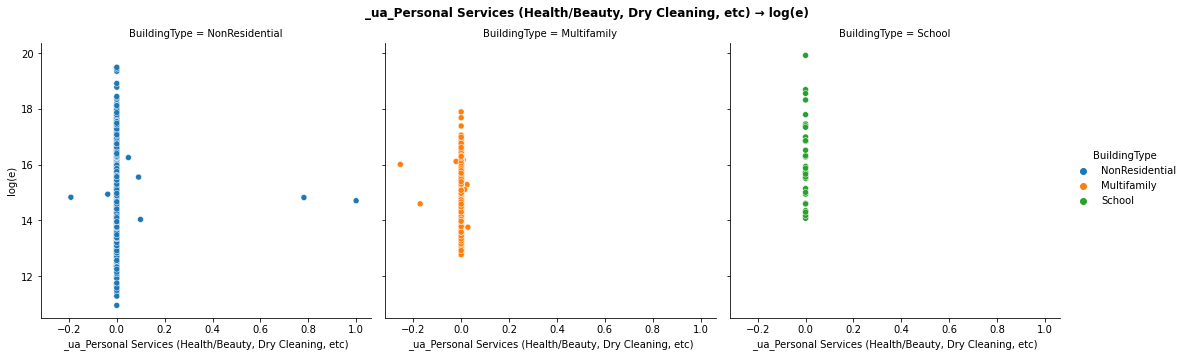

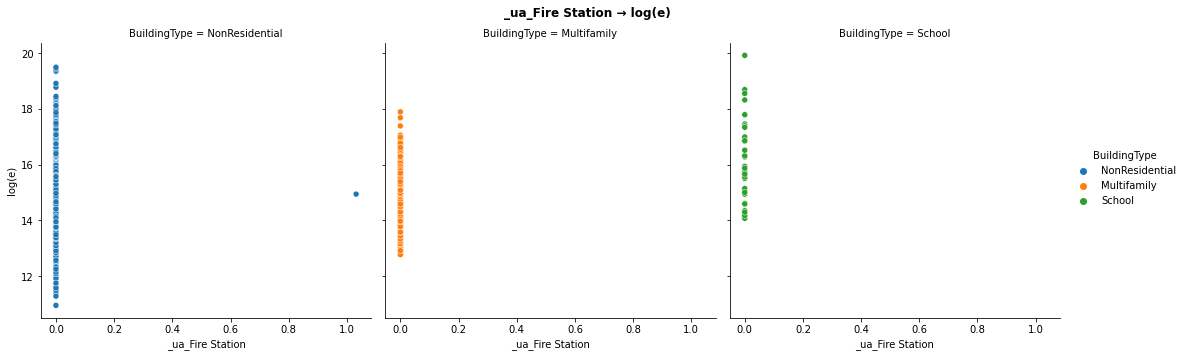

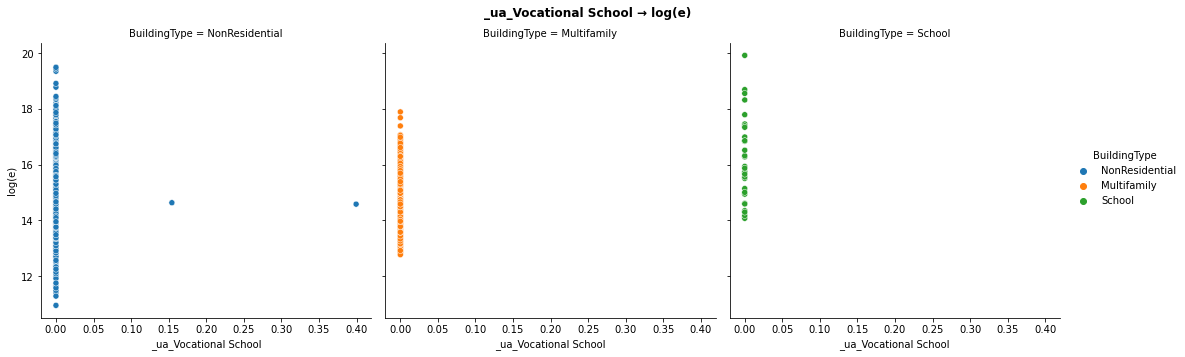

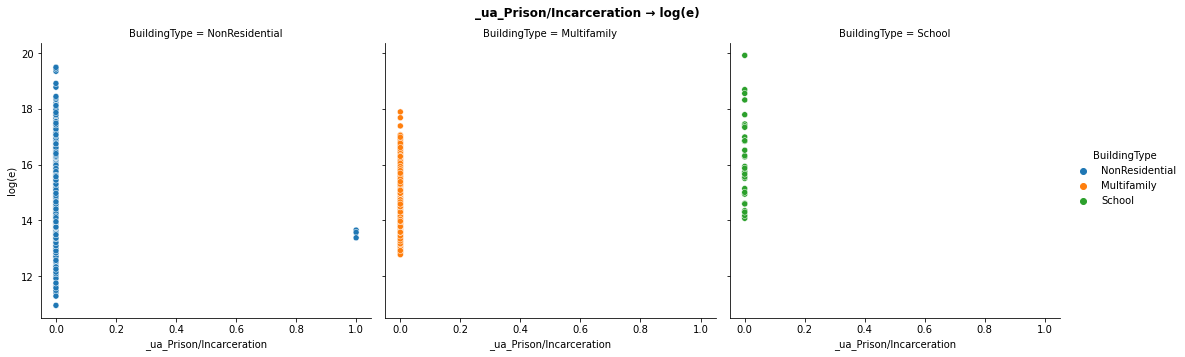

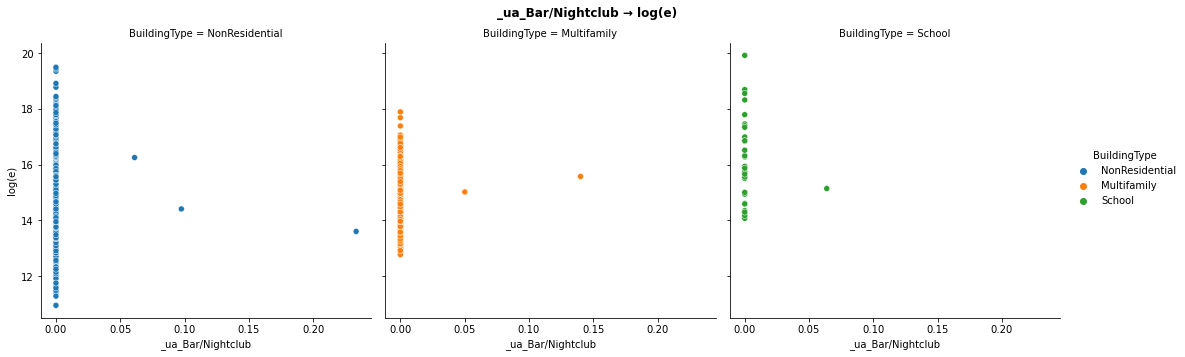

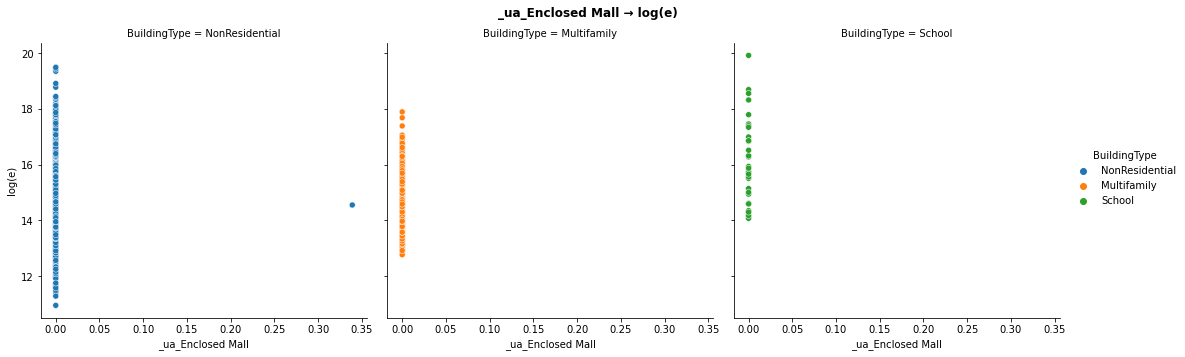

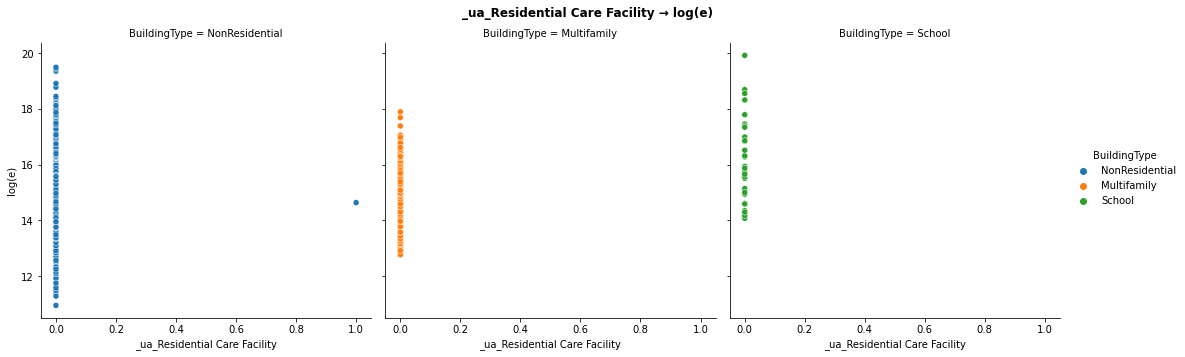

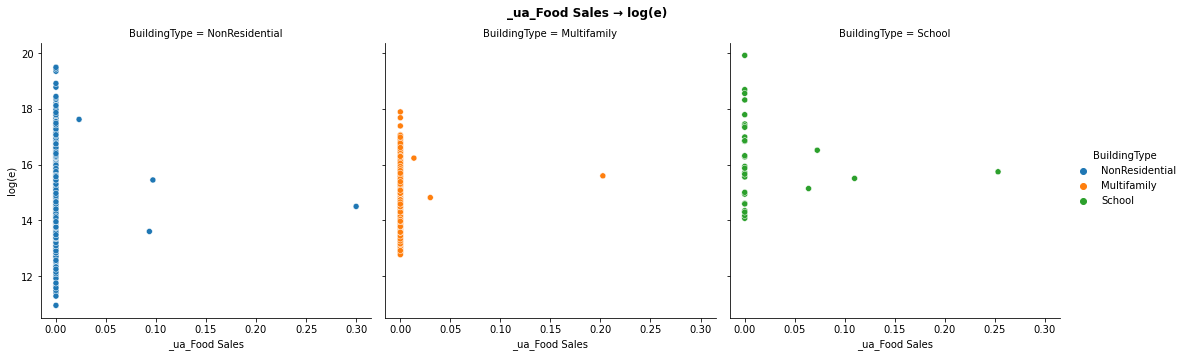

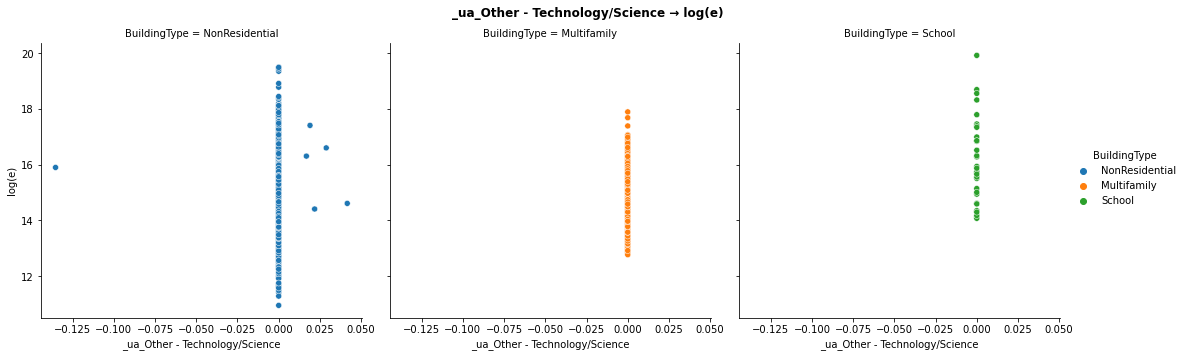

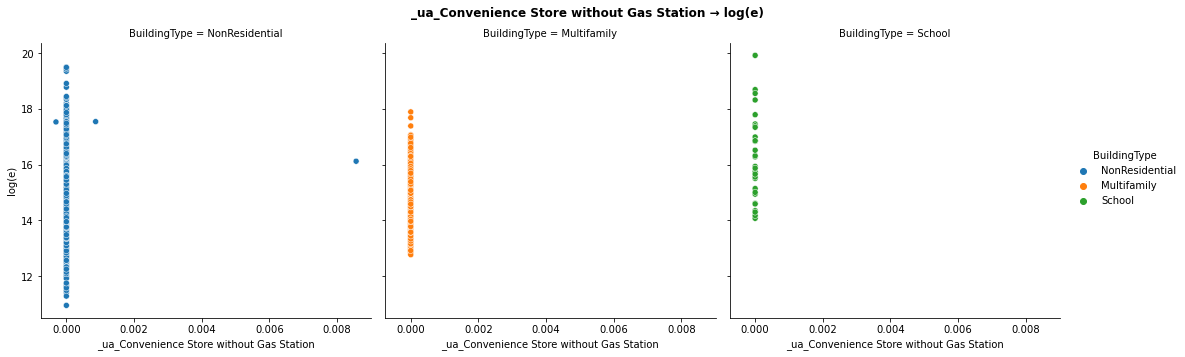

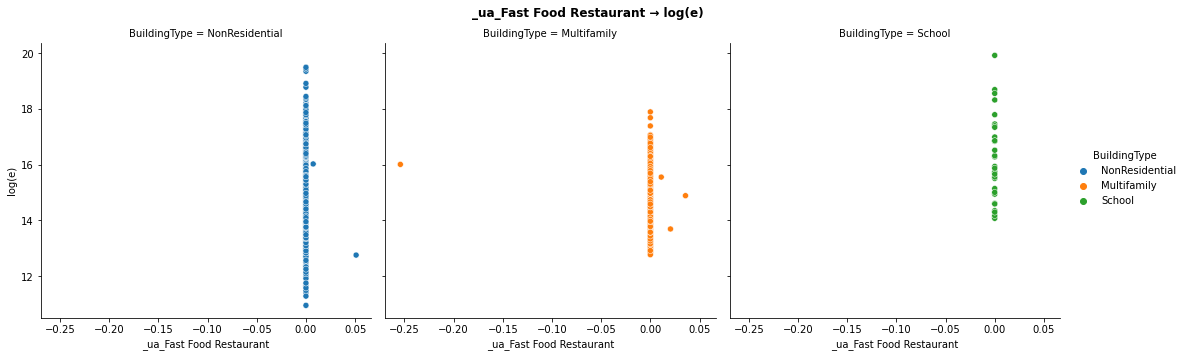

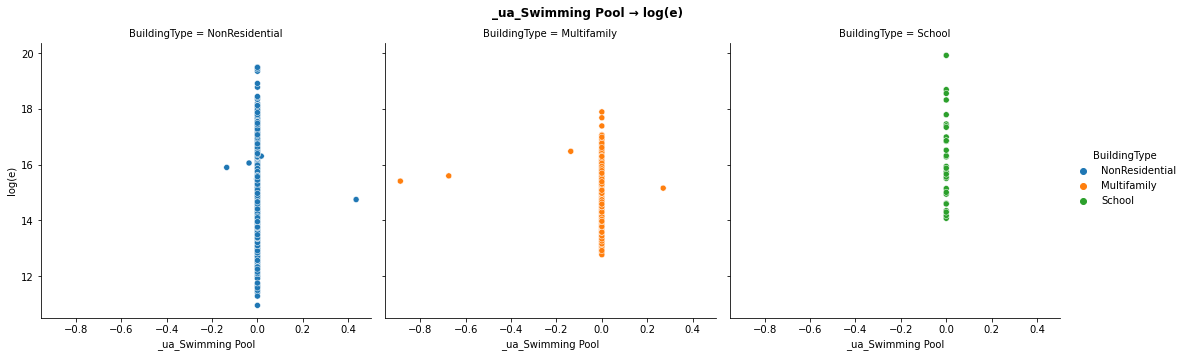

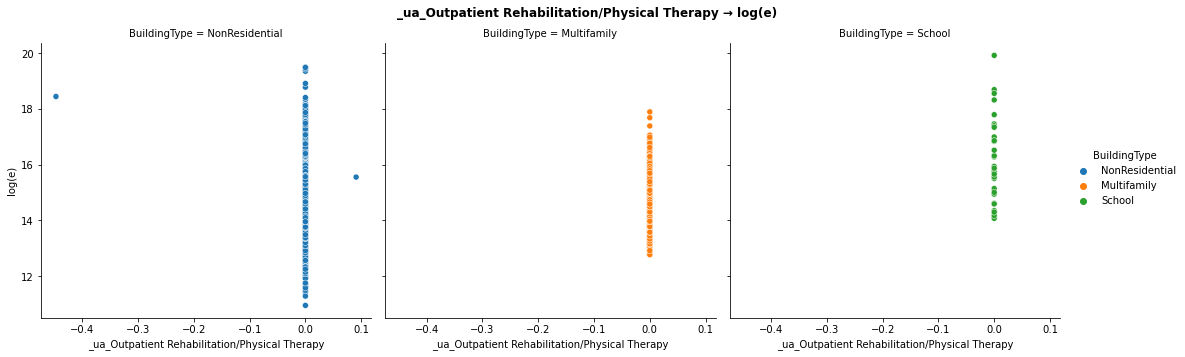

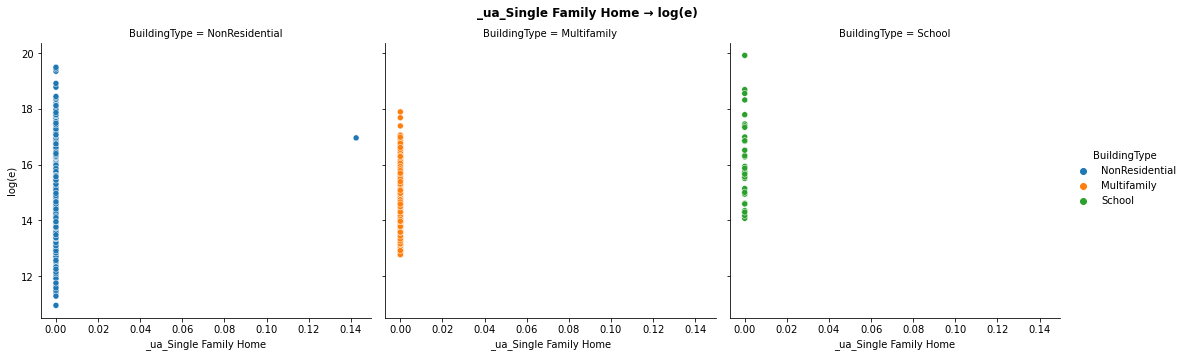

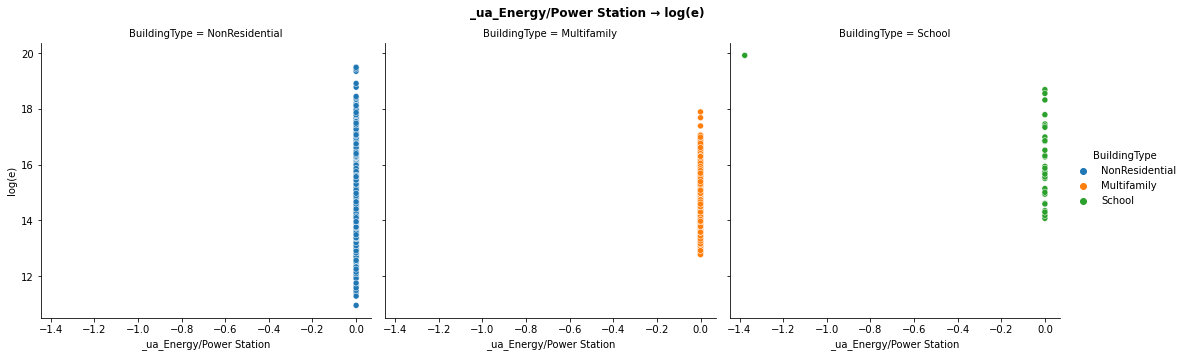

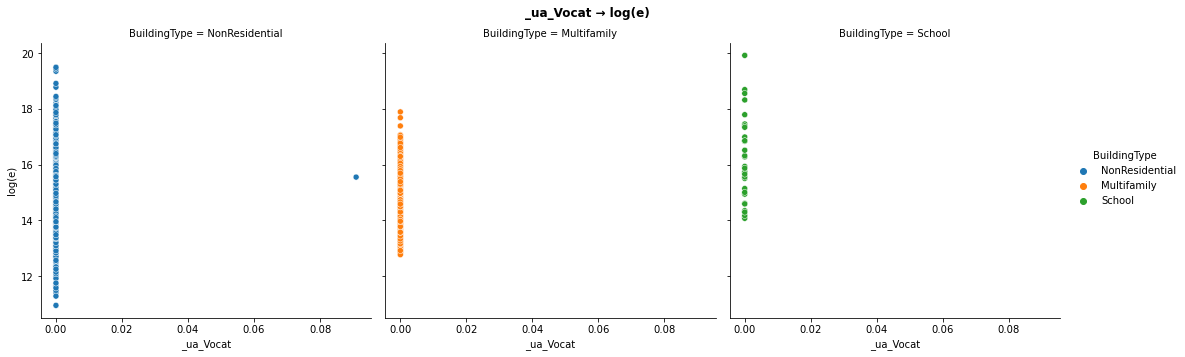

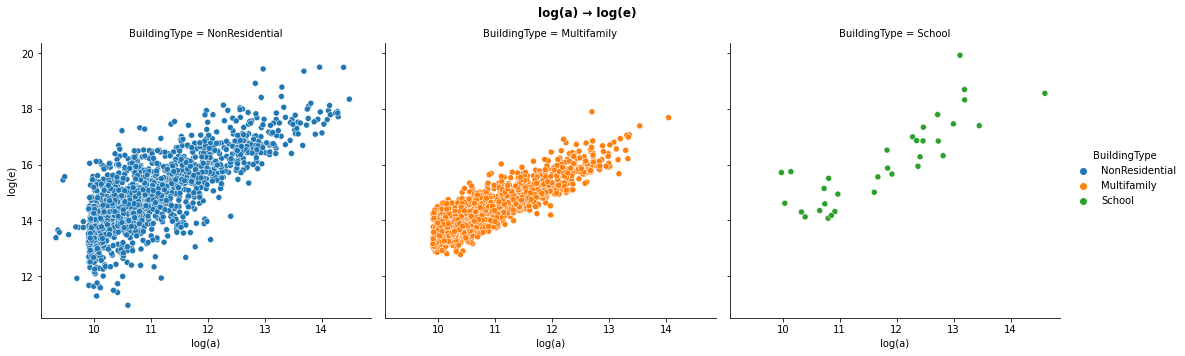

In [30]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [31]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


_ua_Multifamily Housing  _ua_Office  _ua_Parking  \
id                                                        
32                    0.000000    0.000000     0.264690   
43                    0.000000    1.529857     0.000000   
100                   0.000000    0.827762     0.476520   
234                   0.000000    0.094051     0.000000   
238                   0.000000    0.636102     0.130034   
247                   0.000000    0.208310     0.000000   
248                   0.000000    0.196675     0.000000   
264                   0.528618    0.000000     0.269342   
265                   0.698949    0.234320     0.000000   
267                   0.000000    0.000000     0.469613   
354                   0.000000    0.727196     0.176329   
355                   0.000000    0.941514     0.306953   
388                   0.000000    1.129987     0.062910   
393                   0.000000    0.507635     0.530224   
415                   0.000000    0.851766     0.168068   
432                   0.000000    0.563233     0.599620   
460                   0.000000    0.746675    -0.042037   
525                   0.000000   -0.058878     0.000000   
601                   0.342063    0.000000     0.517471   
604                   0.000000    0.862677     0.096215   
657                   0.658852    0.000000     0.745916   
772                   0.000000    0.787553     0.237632   
804                   0.000000    0.000000     1.061245   
812                   0.000000   -0.072173     0.000000   
843                   0.000000    0.000000     0.178801   
19464                 1.412625    0.044553     0.430282   
20163                 0.801160    0.000000     0.209411   
20211                 0.000000    0.089744     0.000000   
21138                 0.000000    0.858491     0.723540   
21210                 0.810424    0.034184     0.243854   
21445                 0.000000    0.922255     0.680591   
21945                 0.000000    0.000000     1.119784   
22839                 1.402677    0.000000     0.218674   
23113                 0.000000    0.000000     0.477029   
23373                 1.170681    0.016925     0.360228   
23816                 0.633062    0.000000     0.424731   
23894                 0.841384    0.190099     0.112459   
24579                 0.000000    0.432277    -0.358610   
24646                 0.000000   -0.135405     0.000000   
25708                 0.896716    0.000000     0.000000   
25932                 0.000000    0.567346     0.000000   
26331                 0.000000    0.818248     0.213028   
26555                 1.566952    0.000000     0.669627   
26994                 0.000000    0.346073     0.523911   
26997                 0.000000    0.489796     0.737609   
27059                 0.665517    0.000000     0.337774   
27100                 0.445902    0.000000     0.069831   
27922                 0.000000   -0.620638     0.000000   
30847                 0.659310    0.000000     0.275686   
32429                 0.000000   -0.179452     0.000000   
33254                 0.371284    0.000000     0.309068   
40348                 0.291245    0.000000     0.637822   
49698                 0.711573    0.000000     0.282816   
49710                 1.096916    0.000000     0.478090   
49776                 0.107954    0.546175     0.421722   
50057                 0.966192   -0.120378     0.110116   
50089                 0.984671    0.000000     0.219401   

       _ua_Non-Refrigerated Warehouse  _ua_Hotel  _ua_Other  _ua_Retail Store  \
id                                                                              
32                           0.000000   0.710101   0.000000          0.028360   
43                           0.929094   0.000000   0.000000          0.000000   
100                          0.000000   0.000000   0.047862         -0.352143   
234                          0.841983   0.000000   0.000000          0.000000   
238                          0.000000  

✔ No NA coefficient


#### Partition

In [32]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.7596213615510109
 OLS R2 score 0.3654964251023588
features : ['_ua_Multifamily Housing' '_ua_Office' '_ua_Parking'
 '_ua_Non-Refrigerated Warehouse' '_ua_Hotel' '_ua_Other'
 '_ua_Retail Store' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Senior Care Community' '_ua_College/University' '_ua_Medical Office'
 '_ua_Other - Entertainment/Public Assembly' '_ua_K-12 School'
 '_ua_Distribution Center' '_ua_Laboratory' '_ua_Worship Facility'
 '_ua_Supermarket/Grocery Store' '_ua_Residence Hall/Dormitory'
 '_ua_Other - Recreation' '_ua_Self-Storage Facility' '_ua_Restaurant'
 '_ua_Refrigerated Warehouse' '_ua_Other - Mall' '_ua_Courthouse'
 '_ua_Financial Office' '_ua_Data Center' '_ua_Strip Mall'
 '_ua_Other - Services' '_ua_Fitness Center/Health Club/Gym' '_ua_Library'
 '_ua_Lifestyle Center' '_ua_Automobile Dealership'
 '_ua_Manufacturing/Industrial Plant' '_ua_Social/Meeting Hall'
 '_ua_Urgent Care/Clinic/Other Outpatient'
 '_ua_Other - Lodging/Residential'
 '_ua_Repair 

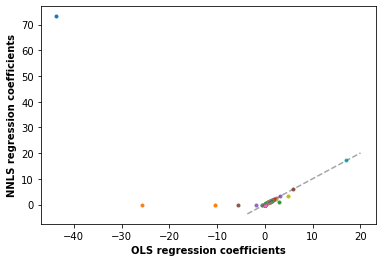

In [34]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives.

On pourra raffiner en éliminant ces variables peu pertinentes.

In [35]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.8124684328828732
SM OLS R2 score 0.3654964251025825
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     57.33
Date:                Thu, 10 Nov 2022   Prob (F-statistic):          9.98e-231
Time:                        10:56:37   Log-Likelihood:                -547.79
No. Observations:                 798   AIC:                             1210.
Df Residuals:                     741   BIC:                             1476.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------

#### Validation croisée du score OLS

La présence des surfaces relatives par usage améliore améliore les performances (0.62 contre 0.56).

En revanche, la mauvaise qualité des données introduit du bruit.

La prochaine étape, à défaut de pouvoir corriger toutes les données, c'est de retirer les jeux incohérents des données d'apprentissage.

In [36]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.69042934 0.670465   0.50674997]
mean scores : 0.6225481013361372
std scores : 0.08228628334571318


## Config 15 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Second test d'intégration.

$\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}$

$R^2_{15} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [4]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [5]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
32                            0.0                         0.0   
43                            0.0                         0.0   
100                           0.0                         0.0   
234                           0.0                         0.0   
238                           0.0                         0.0   
247                           0.0                         0.0   
248                           0.0                         0.0   
264                           0.0                         0.0   
265                           0.0                         1.0   
267                           0.0                         0.0   
354                           0.0                         0.0   
355                           0.0                         0.0   
388                           0.0                         0.0   
393                           0.0                         0.0   
415                           0.0                         0.0   
432                           0.0                         0.0   
460                           0.0                         0.0   
525                           0.0                         0.0   
601                           0.0                         0.0   
604                           0.0                         0.0   
657                           0.0                         0.0   
772                           0.0                         0.0   
804                           0.0                         0.0   
812                           0.0                         0.0   
843                           0.0                         0.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
20211                         0.0                         0.0   
21138                         0.0                         0.0   
21210                         0.0                         1.0   
21445                         0.0                         0.0   
21945                         0.0                         0.0   
22839                         0.0                         0.0   
23113                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
24579                         0.0                         0.0   
24646                         0.0                         0.0   
25708                         1.0                         0.0   
25932                         0.0                         0.0   
26331                         0.0                         0.0   
26555                         1.0                         0.0   
26994                         0.0                         0.0   
26997                         0.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
27922                         0.0                         0.0   
30847                         0.0                         1.0   
32429                         0.0                         0.0   
33254                         0.0                         0.0   
40348                         0.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
49776                         0.0                         0.0   
50057                         0.0                         0.0   
50089                         1.0                         0.0   

       ptype_Small- and Mid-Sized Office  ptype_Other  ptype_Warehouse  \
id                                                                       
32                     

✔ No NA coefficient


#### Partition

In [6]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6797323669500038
 OLS R2 score 0.4379190688742103
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'age'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Parking'
 '_ua_Non-Refrigerated Warehouse' '_ua_Hotel' '_ua_Other'
 '_ua_Retail Store' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Senior Care Community' '_ua_College/University' '_ua_Medical Office'
 '_ua_Other - Entertainment/Public Assembly' '_ua_K-12 School'
 '_ua_Distribution Center' '_ua_Lab

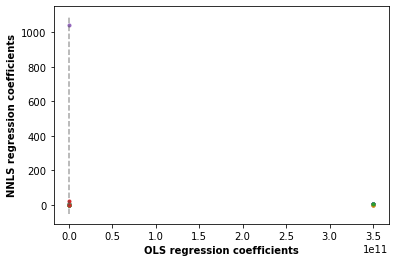

In [8]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives : on pourra raffiner en éliminant ces variables peu pertinentes.

In [9]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.8568765718673922
SM OLS R2 score 0.43761969250530885
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     52.92
Date:                Thu, 10 Nov 2022   Prob (F-statistic):          6.43e-251
Time:                        11:02:40   Log-Likelihood:                -439.96
No. Observations:                 798   AIC:                             1044.
Df Residuals:                     716   BIC:                             1428.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

#### Validation croisée du score OLS

La présence des surfaces relatives par usage améliore améliore les performances (0.62 contre 0.56).

En revanche, la mauvaise qualité des données introduit du bruit.

La propchaine étape, à défaut de pouvoir corriger toutes les données, c'est de retirer les jeux incohérents des données d'apprentissage.

In [10]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.70780974 0.70972891 0.62751866]
mean scores : 0.6816857693917308
std scores : 0.03830994146979775


## Config 16 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Second test d'intégration avec sélection et retrait de variables non pertinentes.

$\{t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a):\log(e)\}$

Cela permet de dépasser les 70 % sur de la simple OLS avec seulement 27 variables.

Les nouvelles $p$-values > 0.05 permettent d'envisager d'itérer et peut-être encore améliorer.

$R^2_{16} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{15} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [12]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [13]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
32                            0.0                         0.0   
43                            0.0                         0.0   
100                           0.0                         0.0   
234                           0.0                         0.0   
238                           0.0                         0.0   
247                           0.0                         0.0   
248                           0.0                         0.0   
264                           0.0                         0.0   
265                           0.0                         1.0   
267                           0.0                         0.0   
354                           0.0                         0.0   
355                           0.0                         0.0   
388                           0.0                         0.0   
393                           0.0                         0.0   
415                           0.0                         0.0   
432                           0.0                         0.0   
460                           0.0                         0.0   
525                           0.0                         0.0   
601                           0.0                         0.0   
604                           0.0                         0.0   
657                           0.0                         0.0   
772                           0.0                         0.0   
804                           0.0                         0.0   
812                           0.0                         0.0   
843                           0.0                         0.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
20211                         0.0                         0.0   
21138                         0.0                         0.0   
21210                         0.0                         1.0   
21445                         0.0                         0.0   
21945                         0.0                         0.0   
22839                         0.0                         0.0   
23113                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
24579                         0.0                         0.0   
24646                         0.0                         0.0   
25708                         1.0                         0.0   
25932                         0.0                         0.0   
26331                         0.0                         0.0   
26555                         1.0                         0.0   
26994                         0.0                         0.0   
26997                         0.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
27922                         0.0                         0.0   
30847                         0.0                         1.0   
32429                         0.0                         0.0   
33254                         0.0                         0.0   
40348                         0.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
49776                         0.0                         0.0   
50057                         0.0                         0.0   
50089                         1.0                         0.0   

       ptype_Small- and Mid-Sized Office  ptype_Other  ptype_Warehouse  \
id                                                                       
32                     

✔ No NA coefficient


#### Partition

In [14]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6797323669500038
 OLS R2 score 0.4379190688742103
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_Small- and Mid-Sized Office' 'ptype_Other' 'ptype_Warehouse'
 'ptype_Large Office' 'ptype_Mixed Use Property'
 'ptype_High-Rise Multifamily' 'ptype_Retail Store' 'ptype_Hotel'
 'ptype_Worship Facility' 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'age'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Parking'
 '_ua_Non-Refrigerated Warehouse' '_ua_Hotel' '_ua_Other'
 '_ua_Retail Store' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Senior Care Community' '_ua_College/University' '_ua_Medical Office'
 '_ua_Other - Entertainment/Public Assembly' '_ua_K-12 School'
 '_ua_Distribution Center' '_ua_Lab

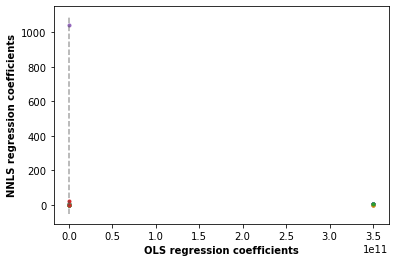

In [16]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives : on pourra raffiner en éliminant ces variables peu pertinentes.

In [17]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.8568765718673922
SM OLS R2 score 0.43761969250530885
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     52.92
Date:                Thu, 10 Nov 2022   Prob (F-statistic):          6.43e-251
Time:                        11:04:11   Log-Likelihood:                -439.96
No. Observations:                 798   AIC:                             1044.
Df Residuals:                     716   BIC:                             1428.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [71]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
def sm_ols_2(X_train, X_test, y_train, y_test):
    _X_train = sm.add_constant(X_train)
    _X_test = sm.add_constant(X_test)
    mod = sm.OLS(y_train, _X_train)
    res = mod.fit()
    y_verif_sm_ols = res.predict(_X_train)
    y_pred_sm_ols = res.predict(_X_test)
    r2_verif_sm_ols = r2_score(y_train, y_verif_sm_ols)
    print("SM OLS R2 verif", r2_verif_sm_ols)
    r2_score_sm_ols = r2_score(y_test, y_pred_sm_ols)
    print("SM OLS R2 score", r2_score_sm_ols)
    print(res.summary())
    return res

res = sm_ols_2(X_train, X_test, y_train, y_test)
print(type(res))

SM OLS R2 verif 0.8568765718673922
SM OLS R2 score 0.43761969250530885
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     52.92
Date:                Wed, 09 Nov 2022   Prob (F-statistic):          6.43e-251
Time:                        17:12:54   Log-Likelihood:                -439.96
No. Observations:                 798   AIC:                             1044.
Df Residuals:                     716   BIC:                             1428.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [72]:
import pandas as pd
def get_coefs(fit_sm_ols):
    _coefs = res.summary().tables[1]
    coefs = pd.DataFrame(_coefs.data)
    coefs.columns = list(coefs.loc[0])
    coefs = coefs.drop(index=0)
    coefs = coefs.set_index('')
    coefs = coefs.astype(float)
    return coefs

coefs = get_coefs(res)
display(coefs)

is_relevant = coefs['P>|t|'] < 0.05
display(coefs[is_relevant])
display(coefs[~is_relevant])

coef  std err       t  P>|t|  [0.025  \
                                                                            
const                              3.3837    0.372   9.106  0.000   2.654   
ptype_Low-Rise Multifamily         0.1056    0.213   0.496  0.620  -0.313   
ptype_Mid-Rise Multifamily         0.2470    0.212   1.166  0.244  -0.169   
ptype_Small- and Mid-Sized Office  0.2904    0.228   1.271  0.204  -0.158   
ptype_Other                        0.6656    0.224   2.970  0.003   0.226   
...                                   ...      ...     ...    ...     ...   
_ua_Energy/Power Station           0.0000    0.000     NaN    NaN   0.000   
_ua_Vocat                          0.0000    0.000     NaN    NaN   0.000   
star_score                        -0.0093    0.001 -12.698  0.000  -0.011   
log(n_l)                          -0.0092    0.056  -0.165  0.869  -0.118   
log(a)                             0.9975    0.030  32.898  0.000   0.938   

                                   0.975]  
                                           
const                               4.113  
ptype_Low-Rise Multifamily          0.524  
ptype_Mid-Rise Multifamily          0.663  
ptype_Small- and Mid-Sized Office   0.739  
ptype_Other                         1.106  
...                                   ...  
_ua_Energy/Power Station            0.000  
_ua_Vocat                           0.000  
star_score                         -0.008  
log(n_l)                            0.100  
log(a)                              1.057  

[95 rows x 6 columns]

coef  std err       t  \
                                                                               
const                                                3.3837    0.372   9.106   
ptype_Other                                          0.6656    0.224   2.970   
ptype_Warehouse                                      0.6662    0.331   2.010   
ptype_Hospital                                       1.7814    0.509   3.503   
_ua_Multifamily Housing                              0.6018    0.127   4.741   
_ua_Office                                           0.9255    0.196   4.731   
_ua_Other                                            0.6237    0.186   3.360   
_ua_Retail Store                                     0.9496    0.248   3.830   
_ua_Other - Entertainment/Public Assembly            0.9160    0.216   4.240   
_ua_Supermarket/Grocery Store                        2.4148    0.567   4.261   
_ua_Other - Recreation                               1.7542    0.341   5.149   
_ua_Restaurant                                       1.5345    0.442   3.471   
_ua_Other - Mall                                     2.4534    0.720   3.407   
_ua_Data Center                                      8.7313    2.917   2.994   
_ua_Lifestyle Center                                 1.0531    0.450   2.342   
_ua_Social/Meeting Hall                              0.5134    0.261   1.970   
_ua_Repair Services (Vehicle, Shoe, Locksmith, ...   1.2920    0.465   2.780   
_ua_Other/Specialty Hospital                         1.2036    0.470   2.559   
_ua_Museum                                           2.0962    0.381   5.505   
_ua_Movie Theater                                    1.0542    0.472   2.234   
_ua_Other - Public Services                          1.2740    0.456   2.795   
_ua_Personal Services (Health/Beauty, Dry Clean... -24.0782    7.304  -3.297   
_ua_Fire Station                                     0.9575    0.457   2.095   
_ua_Bar/Nightclub                                   -6.1577    2.140  -2.877   
_ua_Food Sales                                       4.4040    1.958   2.250   
star_score                                          -0.0093    0.001 -12.698   
log(a)                                               0.9975    0.030  32.898   

                                                    P>|t|  [0.025  0.975]  
                                                                           
const                                               0.000   2.654   4.113  
ptype_Other                                         0.003   0.226   1.106  
ptype_Warehouse                                     0.045   0.015   1.317  
ptype_Hospital                                      0.000   0.783   2.780  
_ua_Multifamily Housing                             0.000   0.353   0.851  
_ua_Office                                          0.000   0.541   1.309  
_ua_Other                                           0.001   0.259   0.988  
_ua_Retail Store                                    0.000   0.463   1.436  
_ua_Other - Entertainment/Public Assembly           0.000   0.492   1.340  
_ua_Supermarket/Grocery Store                       0.000   1.302   3.528  
_ua_Other - Recreation                              0.000   1.085   2.423  
_ua_Restaurant                                      0.001   0.667   2.402  
_ua_Other - Mall                                    0.001   1.039   3.867  
_ua_Data Center                                     0.003   3.005  14.457  
_ua_Lifestyle Center                                0.019   0.170   1.936  
_ua_Social/Meeting Hall                             0.049   0.002   1.025  
_ua_Repair Services (Vehicle, Shoe, Locksmith, ...  0.006   0.380   2.204  
_ua_Other/Specialty Hospital                        0.011   0.280   2.127  
_ua_Museum                                          0.000   1.349   2.844  
_ua_Movie Theater                                   0.026   0.128   1.981  
_ua_Other - Public Services                         0.005   0.

coef  std err      t  P>|t|  \
                                                                                
ptype_Low-Rise Multifamily                      0.1056    0.213  0.496  0.620   
ptype_Mid-Rise Multifamily                      0.2470    0.212  1.166  0.244   
ptype_Small- and Mid-Sized Office               0.2904    0.228  1.271  0.204   
ptype_Large Office                              0.4464    0.230  1.938  0.053   
ptype_Mixed Use Property                        0.2973    0.199  1.492  0.136   
...                                                ...      ...    ...    ...   
_ua_Outpatient Rehabilitation/Physical Therapy  0.0000    0.000    NaN    NaN   
_ua_Single Family Home                          0.0000    0.000    NaN    NaN   
_ua_Energy/Power Station                        0.0000    0.000    NaN    NaN   
_ua_Vocat                                       0.0000    0.000    NaN    NaN   
log(n_l)                                       -0.0092    0.056 -0.165  0.869   

                                                [0.025  0.975]  
                                                                
ptype_Low-Rise Multifamily                      -0.313   0.524  
ptype_Mid-Rise Multifamily                      -0.169   0.663  
ptype_Small- and Mid-Sized Office               -0.158   0.739  
ptype_Large Office                              -0.006   0.899  
ptype_Mixed Use Property                        -0.094   0.688  
...                                                ...     ...  
_ua_Outpatient Rehabilitation/Physical Therapy   0.000   0.000  
_ua_Single Family Home                           0.000   0.000  
_ua_Energy/Power Station                         0.000   0.000  
_ua_Vocat                                        0.000   0.000  
log(n_l)                                        -0.118   0.100  

[68 rows x 6 columns]

In [73]:
not_relevant_vars = list(coefs[~is_relevant].index)
print(not_relevant_vars)

['ptype_Low-Rise Multifamily', 'ptype_Mid-Rise Multifamily', 'ptype_Small- and Mid-Sized Office', 'ptype_Large Office', 'ptype_Mixed Use Property', 'ptype_High-Rise Multifamily', 'ptype_Retail Store', 'ptype_Hotel', 'ptype_Worship Facility', 'ptype_Distribution Center', 'ptype_K-12 School', 'ptype_Senior Care Community', 'ptype_Medical Office', 'ptype_Supermarket / Grocery Store', 'ptype_Self-Storage Facility', 'ptype_Residence Hall', 'ptype_University', 'ptype_Refrigerated Warehouse', 'ptype_Restaurant', 'ptype_Laboratory', 'age', '_ua_Parking', '_ua_Non-Refrigerated Warehouse', '_ua_Hotel', '_ua_Hospital (General Medical & Surgical)', '_ua_Senior Care Community', '_ua_College/University', '_ua_Medical Office', '_ua_K-12 School', '_ua_Distribution Center', '_ua_Laboratory', '_ua_Worship Facility', '_ua_Residence Hall/Dormitory', '_ua_Self-Storage Facility', '_ua_Refrigerated Warehouse', '_ua_Courthouse', '_ua_Financial Office', '_ua_Strip Mall', '_ua_Other - Services', '_ua_Fitness Ce

In [74]:
ml_data_16 = ml_data.drop(columns=not_relevant_vars)
display(ml_data_16)

ptype_Other  ptype_Warehouse  ptype_Hospital  _ua_Multifamily Housing  \
id                                                                             
1              0.0              0.0             0.0                      0.0   
2              0.0              0.0             0.0                      0.0   
3              0.0              0.0             0.0                      0.0   
5              0.0              0.0             0.0                      0.0   
8              0.0              0.0             0.0                      0.0   
...            ...              ...             ...                      ...   
50221          1.0              0.0             0.0                      0.0   
50223          1.0              0.0             0.0                      0.0   
50224          1.0              0.0             0.0                      0.0   
50225          0.0              0.0             0.0                      0.0   
50226          0.0              0.0             0.0                      0.0   

       _ua_Office  _ua_Other  _ua_Retail Store  \
id                                               
1        0.000000        0.0               0.0   
2        0.000000        0.0               0.0   
3        0.000000        0.0               0.0   
5        0.000000        0.0               0.0   
8        0.000000        0.0               0.0   
...           ...        ...               ...   
50221    0.000000        0.0               0.0   
50223    0.000000        0.0               0.0   
50224    0.000000        0.0               0.0   
50225    0.018261        0.0               0.0   
50226    0.024072        0.0               0.0   

       _ua_Other - Entertainment/Public Assembly  \
id                                                 
1                                            0.0   
2                                            0.0   
3                                            0.0   
5                                            0.0   
8                                            0.0   
...                                          ...   
50221                                        0.0   
50223                                        0.0   
50224                                        0.0   
50225                                        0.0   
50226                                        0.0   

       _ua_Supermarket/Grocery Store  _ua_Other - Recreation  ...  _ua_Museum  \
id                                                            ...               
1                                0.0                0.000000  ...         0.0   
2                                0.0                0.000000  ...         0.0   
3                                0.0                0.000000  ...         0.0   
5                                0.0                0.000000  ...         0.0   
8                                0.0                0.000000  ...         0.0   
...                              ...                     ...  ...         ...   
50221                            0.0                1.000000  ...         0.0   
50223                            0.0                1.000000  ...         0.0   
50224                            0.0                0.576347  ...         0.0   
50225                            0.0                0.468123  ...         0.0   
50226                            0.0                0.453007  ...         0.0   

       _ua_Movie Theater  _ua_Other - Public Services  \
id                                                      
1                    0.0                          0.0   
2                    0.0                          0.0   
3                    0.0                          0.0   
5                    0.0                          0.0   
8                    0.0                          0.0   
...                  ...                          ...   
50221                0.0                          0.0   
50223                0.0                          0.0   
50224         

NNLS R2 score 0.7166995371441145
 OLS R2 score 0.46933153330692445
features : ['ptype_Other' 'ptype_Warehouse' 'ptype_Hospital'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Other' '_ua_Retail Store'
 '_ua_Other - Entertainment/Public Assembly'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Recreation' '_ua_Restaurant'
 '_ua_Other - Mall' '_ua_Data Center' '_ua_Lifestyle Center'
 '_ua_Social/Meeting Hall'
 '_ua_Repair Services (Vehicle, Shoe, Locksmith, etc)'
 '_ua_Other/Specialty Hospital' '_ua_Museum' '_ua_Movie Theater'
 '_ua_Other - Public Services'
 '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)'
 '_ua_Fire Station' '_ua_Bar/Nightclub' '_ua_Food Sales' 'star_score'
 'log(a)']
intercept (ols) : [3.89405039]
intercept (nnls) : [3.15089403]
coefficients (ols) : [[ 2.25014885e-01 -4.72051393e-01  1.54819712e+00 -7.18222206e-02
   4.05468751e-01  3.17365393e-01  2.97069183e-01  6.03193965e-01
   1.73639028e+00  1.52328351e+00  1.34653262e+00  1.93684218e+00
   6.52175273e+00  

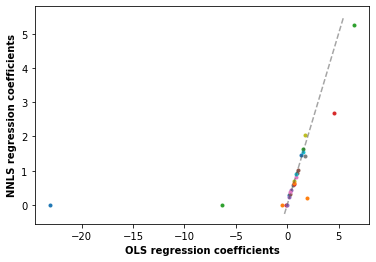

In [75]:
X, y = features_target_split(ml_data_16)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
sm_ols(X_train, X_test, y_train, y_test)

#### Validation croisée du score OLS

La présence des surfaces relatives par usage améliore améliore les performances (0.62 contre 0.56).

En revanche, la mauvaise qualité des données introduit du bruit.

La propchaine étape, à défaut de pouvoir corriger toutes les données, c'est de retirer les jeux incohérents des données d'apprentissage.

In [77]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.78142224 0.6679766  0.72383271]
mean scores : 0.7244105153763533
std scores : 0.0463157868759127


## Config 17 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p)$

Config 16 réduite au cas non résidentiel.

Même score que pour les test 16, 72 %, mais avec 17 variables !

$\{t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a):\log(e)\}$

Cela permet de dépasser les 70 % sur de la simple OLS avec seulement 27 variables.

Les nouvelles $p$-values > 0.05 permettent d'envisager d'itérer et peut-être encore améliorer.

$R^2_{17} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{16} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{16} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_{15} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$


In [87]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(r_data, config_name); # display(ml_data)

In [88]:
check_data(ml_data)

✘ Negative coefficients :


ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
265                           0.0                         1.0   
19464                         0.0                         1.0   
20163                         0.0                         0.0   
21210                         0.0                         1.0   
22839                         0.0                         0.0   
23373                         0.0                         0.0   
23816                         0.0                         1.0   
23894                         0.0                         1.0   
25708                         1.0                         0.0   
26555                         1.0                         0.0   
27059                         1.0                         0.0   
27100                         0.0                         0.0   
30847                         0.0                         1.0   
33254                         0.0                         0.0   
49698                         0.0                         1.0   
49710                         0.0                         1.0   
50057                         0.0                         0.0   
50089                         1.0                         0.0   

       ptype_High-Rise Multifamily  ptype_Senior Care Community  \
id                                                                
265                            0.0                          0.0   
19464                          0.0                          0.0   
20163                          1.0                          0.0   
21210                          0.0                          0.0   
22839                          1.0                          0.0   
23373                          1.0                          0.0   
23816                          0.0                          0.0   
23894                          0.0                          0.0   
25708                          0.0                          0.0   
26555                          0.0                          0.0   
27059                          0.0                          0.0   
27100                          0.0                          0.0   
30847                          0.0                          0.0   
33254                          0.0                          0.0   
49698                          0.0                          0.0   
49710                          0.0                          0.0   
50057                          1.0                          0.0   
50089                          0.0                          0.0   

       ptype_Mixed Use Property  ptype_Other  ptype_Residence Hall  \
id                                                                   
265                         0.0          0.0                   0.0   
19464                       0.0          0.0                   0.0   
20163                       0.0          0.0                   0.0   
21210                       0.0          0.0                   0.0   
22839                       0.0          0.0                   0.0   
23373                       0.0          0.0                   0.0   
23816                       0.0          0.0                   0.0   
23894                       0.0          0.0                   0.0   
25708                       0.0          0.0                   0.0   
26555                       0.0          0.0                   0.0   
27059                       0.0          0.0                   0.0   
27100                       0.0          0.0                   0.0   
30847                       0.0          0.0                   0.0   
33254                       1.0          0.0                   0.0   
49698                       0.0          0.0                   0.0   
49710                       0.0          0.0                   0.0   
50057                       0.0          0.0                   0.0   
50089                       0.0    

✔ No NA coefficient


In [89]:
X, y = features_target_split(ml_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

NNLS R2 score 0.8004684850784474
 OLS R2 score -4.3662924236958106e+18
features : ['ptype_Low-Rise Multifamily' 'ptype_Mid-Rise Multifamily'
 'ptype_High-Rise Multifamily' 'ptype_Senior Care Community'
 'ptype_Mixed Use Property' 'ptype_Other' 'ptype_Residence Hall'
 'ptype_Hotel' 'ptype_Small- and Mid-Sized Office' 'ptype_University'
 'age' '_ua_Multifamily Housing' '_ua_Parking' '_ua_Senior Care Community'
 '_ua_Retail Store' '_ua_Office' '_ua_Other'
 '_ua_Residence Hall/Dormitory' '_ua_Hotel' '_ua_Restaurant'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Lodging/Residential'
 '_ua_Non-Refrigerated Warehouse' '_ua_Medical Office'
 '_ua_Other - Restaurant/Bar' '_ua_College/University' '_ua_Food Service'
 '_ua_Self-Storage Facility' '_ua_Fitness Center/Health Club/Gym'
 '_ua_Museum' '_ua_Hospital (General Medical & Surgical)'
 '_ua_Social/Meeting Hall' '_ua_Bar/Nightclub'
 '_ua_Other/Specialty Hospital' '_ua_Worship Facility'
 '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)'


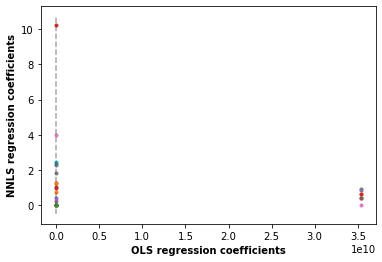

In [90]:
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
res = sm_ols_2(X_train, X_test, y_train, y_test)

In [91]:
show_ols_scores(reg_ols, X, y)

cv scores : [-2.82212303e+20  8.52566368e-01 -9.82888876e+18]
mean scores : -9.734706394552256e+19
std scores : 1.3078103645400462e+20


In [92]:
display(coefs)
coefs = get_coefs(res)
display(coefs)

is_relevant = coefs['P>|t|'] < 0.05
display(coefs[is_relevant])
display(coefs[~is_relevant])

not_relevant_vars = list(coefs[~is_relevant].index)
print(not_relevant_vars)

ml_data_17 = ml_data.drop(columns=not_relevant_vars)
display(ml_data_17)

coef  \
                                                                   
const                                               1.874900e+00   
ptype_Low-Rise Multifamily                          1.192100e+00   
ptype_Mid-Rise Multifamily                          1.506500e+00   
ptype_High-Rise Multifamily                         1.777700e+00   
ptype_Senior Care Community                         1.426500e+00   
ptype_Mixed Use Property                            1.548100e+00   
ptype_Other                                        -3.629200e+00   
ptype_Residence Hall                               -1.946800e+00   
ptype_Hotel                                        -4.521000e-12   
ptype_Small- and Mid-Sized Office                   9.824000e-12   
ptype_University                                    4.727000e-13   
age                                                 5.000000e-03   
_ua_Multifamily Housing                             6.801000e-01   
_ua_Parking                                         2.182000e-01   
_ua_Senior Care Community                           9.342000e-01   
_ua_Retail Store                                    5.663000e-01   
_ua_Office                                          1.326800e+00   
_ua_Other                                           5.315500e+00   
_ua_Residence Hall/Dormitory                        4.656500e+00   
_ua_Hotel                                           3.358000e-14   
_ua_Restaurant                                      2.543300e+00   
_ua_Supermarket/Grocery Store                       4.729500e+00   
_ua_Other - Lodging/Residential                     5.916200e+00   
_ua_Non-Refrigerated Warehouse                      3.996000e-14   
_ua_Medical Office                                  8.718300e+00   
_ua_Other - Restaurant/Bar                         -3.345200e+00   
_ua_College/University                              6.327000e-15   
_ua_Food Service                                    4.099300e+00   
_ua_Self-Storage Facility                           2.380600e+00   
_ua_Fitness Center/Health Club/Gym                 -2.934300e+01   
_ua_Museum                                         -5.317000e-14   
_ua_Hospital (General Medical & Surgical)          -4.654000e-14   
_ua_Social/Meeting Hall                            -3.652800e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -1.442890e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                            3.628270e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.357000e-01   
_ua_Lifestyle Center                               -1.902600e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -4.505300e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
star_score                                         -6.600000e-03   
log(n_l)                                           -2.238000e-01   
log(a)                                              1.020200e+00   

                                                         std err       t  \
                                                                           
const                          

coef  \
                                                                   
const                                               1.874900e+00   
ptype_Low-Rise Multifamily                          1.192100e+00   
ptype_Mid-Rise Multifamily                          1.506500e+00   
ptype_High-Rise Multifamily                         1.777700e+00   
ptype_Senior Care Community                         1.426500e+00   
ptype_Mixed Use Property                            1.548100e+00   
ptype_Other                                        -3.629200e+00   
ptype_Residence Hall                               -1.946800e+00   
ptype_Hotel                                        -4.521000e-12   
ptype_Small- and Mid-Sized Office                   9.824000e-12   
ptype_University                                    4.727000e-13   
age                                                 5.000000e-03   
_ua_Multifamily Housing                             6.801000e-01   
_ua_Parking                                         2.182000e-01   
_ua_Senior Care Community                           9.342000e-01   
_ua_Retail Store                                    5.663000e-01   
_ua_Office                                          1.326800e+00   
_ua_Other                                           5.315500e+00   
_ua_Residence Hall/Dormitory                        4.656500e+00   
_ua_Hotel                                           3.358000e-14   
_ua_Restaurant                                      2.543300e+00   
_ua_Supermarket/Grocery Store                       4.729500e+00   
_ua_Other - Lodging/Residential                     5.916200e+00   
_ua_Non-Refrigerated Warehouse                      3.996000e-14   
_ua_Medical Office                                  8.718300e+00   
_ua_Other - Restaurant/Bar                         -3.345200e+00   
_ua_College/University                              6.327000e-15   
_ua_Food Service                                    4.099300e+00   
_ua_Self-Storage Facility                           2.380600e+00   
_ua_Fitness Center/Health Club/Gym                 -2.934300e+01   
_ua_Museum                                         -5.317000e-14   
_ua_Hospital (General Medical & Surgical)          -4.654000e-14   
_ua_Social/Meeting Hall                            -3.652800e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -1.442890e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                            3.628270e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.357000e-01   
_ua_Lifestyle Center                               -1.902600e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -4.505300e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   
star_score                                         -6.600000e-03   
log(n_l)                                           -2.238000e-01   
log(a)                                              1.020200e+00   

                                                         std err       t  \
                                                                           
const                          

coef  std err       t  P>|t|  [0.025  \
                                                                          
const                            1.8749    0.546   3.434  0.001   0.801   
ptype_Low-Rise Multifamily       1.1921    0.500   2.383  0.018   0.209   
ptype_Mid-Rise Multifamily       1.5065    0.505   2.986  0.003   0.514   
ptype_High-Rise Multifamily      1.7777    0.519   3.424  0.001   0.757   
ptype_Senior Care Community      1.4265    0.537   2.658  0.008   0.371   
ptype_Mixed Use Property         1.5481    0.434   3.570  0.000   0.695   
ptype_Other                     -3.6292    1.326  -2.736  0.007  -6.237   
age                              0.0050    0.001   9.461  0.000   0.004   
_ua_Multifamily Housing          0.6801    0.082   8.322  0.000   0.519   
_ua_Parking                      0.2182    0.109   2.002  0.046   0.004   
_ua_Senior Care Community        0.9342    0.245   3.809  0.000   0.452   
_ua_Office                       1.3268    0.335   3.961  0.000   0.668   
_ua_Other                        5.3155    1.622   3.277  0.001   2.126   
_ua_Restaurant                   2.5433    0.618   4.116  0.000   1.328   
_ua_Other - Lodging/Residential  5.9162    1.439   4.113  0.000   3.088   
_ua_Self-Storage Facility        2.3806    0.941   2.531  0.012   0.531   
star_score                      -0.0066    0.001 -10.577  0.000  -0.008   
log(n_l)                        -0.2238    0.077  -2.914  0.004  -0.375   
log(a)                           1.0202    0.026  39.468  0.000   0.969   

                                 0.975]  
                                         
const                             2.948  
ptype_Low-Rise Multifamily        2.176  
ptype_Mid-Rise Multifamily        2.499  
ptype_High-Rise Multifamily       2.799  
ptype_Senior Care Community       2.482  
ptype_Mixed Use Property          2.401  
ptype_Other                      -1.021  
age                               0.006  
_ua_Multifamily Housing           0.841  
_ua_Parking                       0.432  
_ua_Senior Care Community         1.417  
_ua_Office                        1.985  
_ua_Other                         8.504  
_ua_Restaurant                    3.758  
_ua_Other - Lodging/Residential   8.745  
_ua_Self-Storage Facility         4.230  
star_score                       -0.005  
log(n_l)                         -0.073  
log(a)                            1.071

coef  \
                                                                   
ptype_Residence Hall                               -1.946800e+00   
ptype_Hotel                                        -4.521000e-12   
ptype_Small- and Mid-Sized Office                   9.824000e-12   
ptype_University                                    4.727000e-13   
_ua_Retail Store                                    5.663000e-01   
_ua_Residence Hall/Dormitory                        4.656500e+00   
_ua_Hotel                                           3.358000e-14   
_ua_Supermarket/Grocery Store                       4.729500e+00   
_ua_Non-Refrigerated Warehouse                      3.996000e-14   
_ua_Medical Office                                  8.718300e+00   
_ua_Other - Restaurant/Bar                         -3.345200e+00   
_ua_College/University                              6.327000e-15   
_ua_Food Service                                    4.099300e+00   
_ua_Fitness Center/Health Club/Gym                 -2.934300e+01   
_ua_Museum                                         -5.317000e-14   
_ua_Hospital (General Medical & Surgical)          -4.654000e-14   
_ua_Social/Meeting Hall                            -3.652800e+00   
_ua_Bar/Nightclub                                   0.000000e+00   
_ua_Other/Specialty Hospital                        0.000000e+00   
_ua_Worship Facility                                0.000000e+00   
_ua_Personal Services (Health/Beauty, Dry Clean... -1.442890e+01   
_ua_Food Sales                                      0.000000e+00   
_ua_Financial Office                                0.000000e+00   
_ua_Bank Branch                                     0.000000e+00   
_ua_Strip Mall                                      0.000000e+00   
_ua_Fast Food Restaurant                            3.628270e+01   
_ua_Other - Entertainment/Public Assembly           0.000000e+00   
_ua_Other - Public Services                         0.000000e+00   
_ua_K-12 School                                     0.000000e+00   
_ua_Swimming Pool                                   1.357000e-01   
_ua_Lifestyle Center                               -1.902600e+00   
_ua_Urgent Care/Clinic/Other Outpatient             0.000000e+00   
_ua_Other - Recreation                              0.000000e+00   
_ua_Performing Arts                                -4.505300e+00   
_ua_Other - Education                               0.000000e+00   
_ua_Pre-school/Daycare                              0.000000e+00   

                                                         std err      t  \
                                                                          
ptype_Residence Hall                                3.000000e+00 -0.649   
ptype_Hotel                                         5.200000e-12 -0.869   
ptype_Small- and Mid-Sized Office                   7.880000e-12  1.246   
ptype_University                                    8.140000e-13  0.581   
_ua_Retail Store                                    3.180000e-01  1.782   
_ua_Residence Hall/Dormitory                        3.446000e+00  1.351   
_ua_Hotel                                           2.510000e-14  1.339   
_ua_Supermarket/Grocery Store                       2.855000e+00  1.657   
_ua_Non-Refrigerated Warehouse                      2.700000e-14  1.481   
_ua_Medical Office                                  4.515000e+00  1.931   
_ua_Other - Restaurant/Bar                          4.161000e+00 -0.804   
_ua_College/University                              5.530000e-15  1.144   
_ua_Food Service                                    2.441000e+00  1.680   
_ua_Fitness Center/Health Club/Gym                  2.195200e+01 -1.337   
_ua_Museum                                          3.680000e-14 -1.446   
_ua_Hospital (General Medical & Surgical)           3.100000e-14 -1.503   
_ua_Social/Meeting Hall                             3.315000e+00 -1.102   
_ua_Bar/Nightclub                                 

['ptype_Residence Hall', 'ptype_Hotel', 'ptype_Small- and Mid-Sized Office', 'ptype_University', '_ua_Retail Store', '_ua_Residence Hall/Dormitory', '_ua_Hotel', '_ua_Supermarket/Grocery Store', '_ua_Non-Refrigerated Warehouse', '_ua_Medical Office', '_ua_Other - Restaurant/Bar', '_ua_College/University', '_ua_Food Service', '_ua_Fitness Center/Health Club/Gym', '_ua_Museum', '_ua_Hospital (General Medical & Surgical)', '_ua_Social/Meeting Hall', '_ua_Bar/Nightclub', '_ua_Other/Specialty Hospital', '_ua_Worship Facility', '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)', '_ua_Food Sales', '_ua_Financial Office', '_ua_Bank Branch', '_ua_Strip Mall', '_ua_Fast Food Restaurant', '_ua_Other - Entertainment/Public Assembly', '_ua_Other - Public Services', '_ua_K-12 School', '_ua_Swimming Pool', '_ua_Lifestyle Center', '_ua_Urgent Care/Clinic/Other Outpatient', '_ua_Other - Recreation', '_ua_Performing Arts', '_ua_Other - Education', '_ua_Pre-school/Daycare']


ptype_Low-Rise Multifamily  ptype_Mid-Rise Multifamily  \
id                                                              
13                            0.0                         1.0   
265                           0.0                         1.0   
280                           0.0                         1.0   
296                           1.0                         0.0   
297                           0.0                         1.0   
...                           ...                         ...   
50090                         0.0                         1.0   
50092                         0.0                         0.0   
50093                         0.0                         1.0   
50095                         0.0                         1.0   
50098                         1.0                         0.0   

       ptype_High-Rise Multifamily  ptype_Senior Care Community  \
id                                                                
13                             0.0                          0.0   
265                            0.0                          0.0   
280                            0.0                          0.0   
296                            0.0                          0.0   
297                            0.0                          0.0   
...                            ...                          ...   
50090                          0.0                          0.0   
50092                          0.0                          0.0   
50093                          0.0                          0.0   
50095                          0.0                          0.0   
50098                          0.0                          0.0   

       ptype_Mixed Use Property  ptype_Other  age  _ua_Multifamily Housing  \
id                                                                           
13                          0.0          0.0  106                 0.881027   
265                         0.0          0.0   13                 0.698949   
280                         0.0          0.0  107                 0.968716   
296                         0.0          0.0   99                 1.000000   
297                         0.0          0.0    7                 0.769636   
...                         ...          ...  ...                      ...   
50090                       0.0          0.0    1                 1.116193   
50092                       0.0          0.0    1                 0.000000   
50093                       0.0          0.0    1                 0.910675   
50095                       0.0          0.0    1                 0.808226   
50098                       0.0          0.0    2                 0.872567   

       _ua_Parking  _ua_Senior Care Community  _ua_Office  _ua_Other  \
id                                                                     
13        0.000000                        0.0     0.00000        0.0   
265       0.000000                        0.0     0.23432        0.0   
280       0.000000                        0.0     0.00000        0.0   
296       0.000000                        0.0     0.00000        0.0   
297       0.000000                        0.0     0.00000        0.0   
...            ...                        ...         ...        ...   
50090     0.000000                        0.0     0.00000        0.0   
50092     0.000000                        0.0     0.00000        0.0   
50093     0.094439                        0.0     0.00000        0.0   
50095     0.214845                        0.0     0.00000        0.0   
50098     0.000000                        0.0     0.00000        0.0   

       _ua_Restaurant  _ua_Other - Lodging/Residential  \
id                                                       
13                0.0                         0.000000   
265               0.0                         0.109887   
280               0.0                         0.000000   
296               0.0                         0

NNLS R2 score 0.7166995371441145
 OLS R2 score 0.46933153330692445
features : ['ptype_Other' 'ptype_Warehouse' 'ptype_Hospital'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Other' '_ua_Retail Store'
 '_ua_Other - Entertainment/Public Assembly'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Recreation' '_ua_Restaurant'
 '_ua_Other - Mall' '_ua_Data Center' '_ua_Lifestyle Center'
 '_ua_Social/Meeting Hall'
 '_ua_Repair Services (Vehicle, Shoe, Locksmith, etc)'
 '_ua_Other/Specialty Hospital' '_ua_Museum' '_ua_Movie Theater'
 '_ua_Other - Public Services'
 '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)'
 '_ua_Fire Station' '_ua_Bar/Nightclub' '_ua_Food Sales' 'star_score'
 'log(a)']
intercept (ols) : [3.89405039]
intercept (nnls) : [3.15089403]
coefficients (ols) : [[ 2.25014885e-01 -4.72051393e-01  1.54819712e+00 -7.18222206e-02
   4.05468751e-01  3.17365393e-01  2.97069183e-01  6.03193965e-01
   1.73639028e+00  1.52328351e+00  1.34653262e+00  1.93684218e+00
   6.52175273e+00  

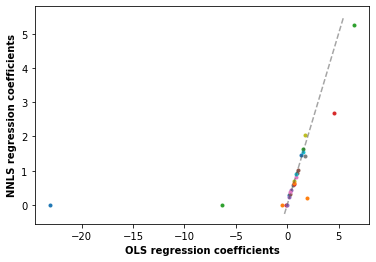

In [93]:
X, y = features_target_split(ml_data_16)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
sm_ols(X_train, X_test, y_train, y_test)
show_ols_scores(reg_ols, X, y)

## Config 18 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p, t_B)$

Config avec $t_b$ non abstrait ($t_B$) réduite au cas non résidentiel.

$\{t_B, t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a):\log(e)\}$

On atteint :
$R^2_{18} \left(\{t_B, t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a):\log(e)\}\right)$
* $\mu = 0.7423857181398302$
* $\sigma = 0.04437758463300786$

Pour comparaison :

$R^2_{17} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7244105153763533$
* $\sigma = 0.0463157868759127$

$R^2_4 \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [5]:
config_name = "{t_B, t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

btype_NonResidential  btype_Multifamily LR (1-4)  \
id                                                        
1                       1.0                         0.0   
2                       1.0                         0.0   
3                       1.0                         0.0   
5                       1.0                         0.0   
8                       1.0                         0.0   
...                     ...                         ...   
50221                   0.0                         0.0   
50223                   0.0                         0.0   
50224                   0.0                         0.0   
50225                   0.0                         0.0   
50226                   0.0                         0.0   

       btype_Multifamily MR (5-9)  btype_Multifamily HR (10+)  \
id                                                              
1                             0.0                         0.0   
2                             0.0                         0.0   
3                             0.0                         0.0   
5                             0.0                         0.0   
8                             0.0                         0.0   
...                           ...                         ...   
50221                         0.0                         0.0   
50223                         0.0                         0.0   
50224                         0.0                         0.0   
50225                         0.0                         0.0   
50226                         0.0                         0.0   

       btype_Nonresidential COS  btype_Campus  btype_SPS-District K-12  \
id                                                                       
1                           0.0           0.0                      0.0   
2                           0.0           0.0                      0.0   
3                           0.0           0.0                      0.0   
5                           0.0           0.0                      0.0   
8                           0.0           0.0                      0.0   
...                         ...           ...                      ...   
50221                       1.0           0.0                      0.0   
50223                       1.0           0.0                      0.0   
50224                       1.0           0.0                      0.0   
50225                       1.0           0.0                      0.0   
50226                       1.0           0.0                      0.0   

       btype_Nonresidential WA  ptype_Low-Rise Multifamily  \
id                                                           
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
5                          0.0                         0.0   
8                          0.0                         0.0   
...                        ...                         ...   
50221                      0.0                         0.0   
50223                      0.0                         0.0   
50224                      0.0                         0.0   
50225                      0.0                         0.0   
50226                      0.0                         0.0   

       ptype_Mid-Rise Multifamily  ...  _ua_Fast Food Restaurant  \
id                                 ...                             
1                             0.0  ...                       0.0   
2                             0.0  ...                       0.0   
3                             0.0  ...                       0.0   
5                             0.0  ...                       0.0   
8                             0.0  ...                       0.0   
...                           ...  ...                       ...   
50221                         0.0  ...                       0.0   
50223      

#### Visualisation

Trop de variables pour la visualisation.

#### Vérifications

In [6]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


btype_NonResidential  btype_Multifamily LR (1-4)  \
id                                                        
32                      1.0                         0.0   
43                      0.0                         0.0   
100                     1.0                         0.0   
234                     0.0                         0.0   
238                     0.0                         0.0   
247                     0.0                         0.0   
248                     0.0                         0.0   
264                     1.0                         0.0   
265                     0.0                         0.0   
267                     1.0                         0.0   
354                     1.0                         0.0   
355                     1.0                         0.0   
388                     1.0                         0.0   
393                     1.0                         0.0   
415                     1.0                         0.0   
432                     0.0                         0.0   
460                     1.0                         0.0   
525                     1.0                         0.0   
601                     1.0                         0.0   
604                     1.0                         0.0   
657                     1.0                         0.0   
772                     1.0                         0.0   
804                     1.0                         0.0   
812                     1.0                         0.0   
843                     1.0                         0.0   
19464                   0.0                         0.0   
20163                   0.0                         0.0   
20211                   1.0                         0.0   
21138                   1.0                         0.0   
21210                   0.0                         0.0   
21445                   1.0                         0.0   
21945                   1.0                         0.0   
22839                   0.0                         0.0   
23113                   1.0                         0.0   
23373                   0.0                         0.0   
23816                   0.0                         0.0   
23894                   0.0                         0.0   
24579                   1.0                         0.0   
24646                   0.0                         0.0   
25708                   0.0                         1.0   
25932                   1.0                         0.0   
26331                   1.0                         0.0   
26555                   0.0                         1.0   
26994                   1.0                         0.0   
26997                   1.0                         0.0   
27059                   0.0                         1.0   
27100                   0.0                         0.0   
27922                   1.0                         0.0   
30847                   0.0                         0.0   
32429                   1.0                         0.0   
33254                   0.0                         1.0   
40348                   1.0                         0.0   
49698                   0.0                         0.0   
49710                   0.0                         0.0   
49776                   1.0                         0.0   
50057                   0.0                         0.0   
50089                   0.0                         1.0   

       btype_Multifamily MR (5-9)  btype_Multifamily HR (10+)  \
id                                                              
32                            0.0                         0.0   
43                            0.0                         0.0   
100                           0.0                         0.0   
234                           0.0                         0.0   
238                           0.0                         0.0   
247                           0.0                         0.0   
248  

✔ No NA coefficient


#### Partition

In [7]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### OLS, NNLS

NNLS R2 score 0.6766615002984442
 OLS R2 score 0.44168814383083543
features : ['btype_NonResidential' 'btype_Multifamily LR (1-4)'
 'btype_Multifamily MR (5-9)' 'btype_Multifamily HR (10+)'
 'btype_Nonresidential COS' 'btype_Campus' 'btype_SPS-District K-12'
 'btype_Nonresidential WA' 'ptype_Low-Rise Multifamily'
 'ptype_Mid-Rise Multifamily' 'ptype_Small- and Mid-Sized Office'
 'ptype_Other' 'ptype_Warehouse' 'ptype_Large Office'
 'ptype_Mixed Use Property' 'ptype_High-Rise Multifamily'
 'ptype_Retail Store' 'ptype_Hotel' 'ptype_Worship Facility'
 'ptype_Distribution Center' 'ptype_K-12 School'
 'ptype_Senior Care Community' 'ptype_Medical Office'
 'ptype_Supermarket / Grocery Store' 'ptype_Self-Storage Facility'
 'ptype_Residence Hall' 'ptype_University' 'ptype_Refrigerated Warehouse'
 'ptype_Restaurant' 'ptype_Laboratory' 'ptype_Hospital' 'age'
 '_ua_Multifamily Housing' '_ua_Office' '_ua_Parking'
 '_ua_Non-Refrigerated Warehouse' '_ua_Hotel' '_ua_Other'
 '_ua_Retail Store' '_ua_Hos

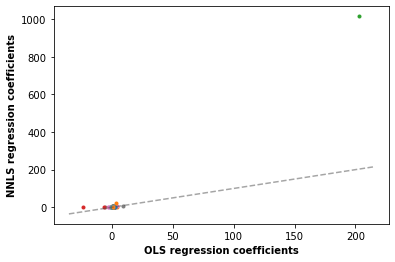

In [8]:
from seattle_commons import ols_nnls_competition, show_ols_nnls_results
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)

#### StatsModels' OLS

Certaines $p$-values > 0.05 désignent des variables non contributrives : on pourra raffiner en éliminant ces variables peu pertinentes.

In [9]:
from seattle_commons import sm_ols
sm_ols(X_train, X_test, y_train, y_test)

SM OLS R2 verif 0.8582899776071329
SM OLS R2 score 0.4415461092155555
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     50.07
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          3.92e-248
Time:                        14:12:38   Log-Likelihood:                -436.00
No. Observations:                 798   AIC:                             1046.
Df Residuals:                     711   BIC:                             1453.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [10]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
def sm_ols_2(X_train, X_test, y_train, y_test):
    _X_train = sm.add_constant(X_train)
    _X_test = sm.add_constant(X_test)
    mod = sm.OLS(y_train, _X_train)
    res = mod.fit()
    y_verif_sm_ols = res.predict(_X_train)
    y_pred_sm_ols = res.predict(_X_test)
    r2_verif_sm_ols = r2_score(y_train, y_verif_sm_ols)
    print("SM OLS R2 verif", r2_verif_sm_ols)
    r2_score_sm_ols = r2_score(y_test, y_pred_sm_ols)
    print("SM OLS R2 score", r2_score_sm_ols)
    print(res.summary())
    return res

res = sm_ols_2(X_train, X_test, y_train, y_test)
print(type(res))

SM OLS R2 verif 0.8582899776071329
SM OLS R2 score 0.4415461092155555
                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     50.07
Date:                Mon, 14 Nov 2022   Prob (F-statistic):          3.92e-248
Time:                        14:12:56   Log-Likelihood:                -436.00
No. Observations:                 798   AIC:                             1046.
Df Residuals:                     711   BIC:                             1453.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [11]:
import pandas as pd
def get_coefs(fit_sm_ols):
    _coefs = res.summary().tables[1]
    coefs = pd.DataFrame(_coefs.data)
    coefs.columns = list(coefs.loc[0])
    coefs = coefs.drop(index=0)
    coefs = coefs.set_index('')
    coefs = coefs.astype(float)
    return coefs

coefs = get_coefs(res)
display(coefs)

is_relevant = coefs['P>|t|'] < 0.05
display(coefs[is_relevant])
display(coefs[~is_relevant])

coef  std err       t  P>|t|  [0.025  0.975]
                                                                          
const                       3.0527    0.328   9.319  0.000   2.410   3.696
btype_NonResidential        0.3938    0.104   3.796  0.000   0.190   0.597
btype_Multifamily LR (1-4)  0.1901    0.184   1.035  0.301  -0.171   0.551
btype_Multifamily MR (5-9)  0.3083    0.215   1.433  0.152  -0.114   0.731
btype_Multifamily HR (10+)  0.3129    0.112   2.788  0.005   0.093   0.533
...                            ...      ...     ...    ...     ...     ...
_ua_Energy/Power Station    0.0000    0.000     NaN    NaN   0.000   0.000
_ua_Vocat                   0.0000    0.000     NaN    NaN   0.000   0.000
star_score                 -0.0092    0.001 -12.498  0.000  -0.011  -0.008
log(n_l)                   -0.0023    0.056  -0.041  0.967  -0.112   0.108
log(a)                      0.9926    0.030  32.645  0.000   0.933   1.052

[103 rows x 6 columns]

coef  std err       t  \
                                                                               
const                                                3.0527    0.328   9.319   
btype_NonResidential                                 0.3938    0.104   3.796   
btype_Multifamily HR (10+)                           0.3129    0.112   2.788   
btype_Nonresidential COS                             0.5932    0.153   3.888   
btype_Campus                                         0.9047    0.247   3.658   
ptype_Other                                          0.6745    0.233   2.892   
ptype_Warehouse                                      0.6876    0.336   2.045   
ptype_High-Rise Multifamily                          0.3129    0.112   2.788   
ptype_Hospital                                       1.7669    0.512   3.450   
_ua_Multifamily Housing                              0.6095    0.127   4.785   
_ua_Office                                           0.8822    0.198   4.456   
_ua_Other                                            0.5419    0.190   2.858   
_ua_Retail Store                                     0.9230    0.249   3.713   
_ua_Senior Care Community                            1.7431    0.807   2.161   
_ua_Other - Entertainment/Public Assembly            0.8089    0.224   3.617   
_ua_Supermarket/Grocery Store                        2.3657    0.568   4.165   
_ua_Other - Recreation                               1.6107    0.349   4.620   
_ua_Restaurant                                       1.5017    0.443   3.389   
_ua_Other - Mall                                     2.3975    0.720   3.331   
_ua_Data Center                                      8.9088    2.938   3.032   
_ua_Lifestyle Center                                 1.0192    0.450   2.267   
_ua_Repair Services (Vehicle, Shoe, Locksmith, ...   1.0660    0.483   2.206   
_ua_Other/Specialty Hospital                         1.1659    0.470   2.480   
_ua_Museum                                           1.9640    0.387   5.074   
_ua_Movie Theater                                    1.0217    0.472   2.166   
_ua_Other - Public Services                          1.2430    0.455   2.729   
_ua_Personal Services (Health/Beauty, Dry Clean... -23.9102    7.294  -3.278   
_ua_Bar/Nightclub                                   -5.2338    2.175  -2.407   
star_score                                          -0.0092    0.001 -12.498   
log(a)                                               0.9926    0.030  32.645   

                                                    P>|t|  [0.025  0.975]  
                                                                           
const                                               0.000   2.410   3.696  
btype_NonResidential                                0.000   0.190   0.597  
btype_Multifamily HR (10+)                          0.005   0.093   0.533  
btype_Nonresidential COS                            0.000   0.294   0.893  
btype_Campus                                        0.000   0.419   1.390  
ptype_Other                                         0.004   0.217   1.132  
ptype_Warehouse                                     0.041   0.028   1.348  
ptype_High-Rise Multifamily                         0.005   0.093   0.533  
ptype_Hospital                                      0.001   0.761   2.772  
_ua_Multifamily Housing                             0.000   0.359   0.860  
_ua_Office                                          0.000   0.494   1.271  
_ua_Other                                           0.004   0.170   0.914  
_ua_Retail Store                                    0.000   0.435   1.411  
_ua_Senior Care Community                           0.031   0.160   3.326  
_ua_Other - Entertainment/Public Assembly           0.000   0.370   1.248  
_ua_Supermarket/Grocery Store                       0.000   1.251   3.481  
_ua_Other - Recreation                              0.000   0.926   2.295  
_ua_Restaurant                                    

coef       std err  \
                                                                             
btype_Multifamily LR (1-4)                      1.901000e-01  1.840000e-01   
btype_Multifamily MR (5-9)                      3.083000e-01  2.150000e-01   
btype_SPS-District K-12                         3.495000e-01  3.110000e-01   
btype_Nonresidential WA                         2.487000e-09  9.800000e-09   
ptype_Low-Rise Multifamily                      2.731000e-01  2.760000e-01   
...                                                      ...           ...   
_ua_Outpatient Rehabilitation/Physical Therapy  0.000000e+00  0.000000e+00   
_ua_Single Family Home                          0.000000e+00  0.000000e+00   
_ua_Energy/Power Station                        0.000000e+00  0.000000e+00   
_ua_Vocat                                       0.000000e+00  0.000000e+00   
log(n_l)                                       -2.300000e-03  5.600000e-02   

                                                    t  P>|t|        [0.025  \
                                                                             
btype_Multifamily LR (1-4)                      1.035  0.301 -1.710000e-01   
btype_Multifamily MR (5-9)                      1.433  0.152 -1.140000e-01   
btype_SPS-District K-12                         1.124  0.262 -2.610000e-01   
btype_Nonresidential WA                         0.254  0.800 -1.680000e-08   
ptype_Low-Rise Multifamily                      0.990  0.322 -2.680000e-01   
...                                               ...    ...           ...   
_ua_Outpatient Rehabilitation/Physical Therapy    NaN    NaN  0.000000e+00   
_ua_Single Family Home                            NaN    NaN  0.000000e+00   
_ua_Energy/Power Station                          NaN    NaN  0.000000e+00   
_ua_Vocat                                         NaN    NaN  0.000000e+00   
log(n_l)                                       -0.041  0.967 -1.120000e-01   

                                                      0.975]  
                                                              
btype_Multifamily LR (1-4)                      5.510000e-01  
btype_Multifamily MR (5-9)                      7.310000e-01  
btype_SPS-District K-12                         9.600000e-01  
btype_Nonresidential WA                         2.170000e-08  
ptype_Low-Rise Multifamily                      8.150000e-01  
...                                                      ...  
_ua_Outpatient Rehabilitation/Physical Therapy  0.000000e+00  
_ua_Single Family Home                          0.000000e+00  
_ua_Energy/Power Station                        0.000000e+00  
_ua_Vocat                                       0.000000e+00  
log(n_l)                                        1.080000e-01  

[73 rows x 6 columns]

In [12]:
not_relevant_vars = list(coefs[~is_relevant].index)
print(not_relevant_vars)

['btype_Multifamily LR (1-4)', 'btype_Multifamily MR (5-9)', 'btype_SPS-District K-12', 'btype_Nonresidential WA', 'ptype_Low-Rise Multifamily', 'ptype_Mid-Rise Multifamily', 'ptype_Small- and Mid-Sized Office', 'ptype_Large Office', 'ptype_Mixed Use Property', 'ptype_Retail Store', 'ptype_Hotel', 'ptype_Worship Facility', 'ptype_Distribution Center', 'ptype_K-12 School', 'ptype_Senior Care Community', 'ptype_Medical Office', 'ptype_Supermarket / Grocery Store', 'ptype_Self-Storage Facility', 'ptype_Residence Hall', 'ptype_University', 'ptype_Refrigerated Warehouse', 'ptype_Restaurant', 'ptype_Laboratory', 'age', '_ua_Parking', '_ua_Non-Refrigerated Warehouse', '_ua_Hotel', '_ua_Hospital (General Medical & Surgical)', '_ua_College/University', '_ua_Medical Office', '_ua_K-12 School', '_ua_Distribution Center', '_ua_Laboratory', '_ua_Worship Facility', '_ua_Residence Hall/Dormitory', '_ua_Self-Storage Facility', '_ua_Refrigerated Warehouse', '_ua_Courthouse', '_ua_Financial Office', '_u

In [13]:
ml_data = ml_data.drop(columns=not_relevant_vars)
display(ml_data)

btype_NonResidential  btype_Multifamily HR (10+)  \
id                                                        
1                       1.0                         0.0   
2                       1.0                         0.0   
3                       1.0                         0.0   
5                       1.0                         0.0   
8                       1.0                         0.0   
...                     ...                         ...   
50221                   0.0                         0.0   
50223                   0.0                         0.0   
50224                   0.0                         0.0   
50225                   0.0                         0.0   
50226                   0.0                         0.0   

       btype_Nonresidential COS  btype_Campus  ptype_Other  ptype_Warehouse  \
id                                                                            
1                           0.0           0.0          0.0              0.0   
2                           0.0           0.0          0.0              0.0   
3                           0.0           0.0          0.0              0.0   
5                           0.0           0.0          0.0              0.0   
8                           0.0           0.0          0.0              0.0   
...                         ...           ...          ...              ...   
50221                       1.0           0.0          1.0              0.0   
50223                       1.0           0.0          1.0              0.0   
50224                       1.0           0.0          1.0              0.0   
50225                       1.0           0.0          0.0              0.0   
50226                       1.0           0.0          0.0              0.0   

       ptype_High-Rise Multifamily  ptype_Hospital  _ua_Multifamily Housing  \
id                                                                            
1                              0.0             0.0                      0.0   
2                              0.0             0.0                      0.0   
3                              0.0             0.0                      0.0   
5                              0.0             0.0                      0.0   
8                              0.0             0.0                      0.0   
...                            ...             ...                      ...   
50221                          0.0             0.0                      0.0   
50223                          0.0             0.0                      0.0   
50224                          0.0             0.0                      0.0   
50225                          0.0             0.0                      0.0   
50226                          0.0             0.0                      0.0   

       _ua_Office  ...  _ua_Repair Services (Vehicle, Shoe, Locksmith, etc)  \
id                 ...                                                        
1        0.000000  ...                                                0.0     
2        0.000000  ...                                                0.0     
3        0.000000  ...                                                0.0     
5        0.000000  ...                                                0.0     
8        0.000000  ...                                                0.0     
...           ...  ...                                                ...     
50221    0.000000  ...                                                0.0     
50223    0.000000  ...                                                0.0     
50224    0.000000  ...                                                0.0     
50225    0.018261  ...                                                0.0     
50226    0.024072  ...                                                0.0     

       _ua_Other/Specialty Hospital  _ua_Museum  _ua_Movie Theater  \
id                                                                   
1              

NNLS R2 score 0.737498363392592
 OLS R2 score 0.5030844766640482
features : ['btype_NonResidential' 'btype_Multifamily HR (10+)'
 'btype_Nonresidential COS' 'btype_Campus' 'ptype_Other' 'ptype_Warehouse'
 'ptype_High-Rise Multifamily' 'ptype_Hospital' '_ua_Multifamily Housing'
 '_ua_Office' '_ua_Other' '_ua_Retail Store' '_ua_Senior Care Community'
 '_ua_Other - Entertainment/Public Assembly'
 '_ua_Supermarket/Grocery Store' '_ua_Other - Recreation' '_ua_Restaurant'
 '_ua_Other - Mall' '_ua_Data Center' '_ua_Lifestyle Center'
 '_ua_Repair Services (Vehicle, Shoe, Locksmith, etc)'
 '_ua_Other/Specialty Hospital' '_ua_Museum' '_ua_Movie Theater'
 '_ua_Other - Public Services'
 '_ua_Personal Services (Health/Beauty, Dry Cleaning, etc)'
 '_ua_Bar/Nightclub' 'star_score' 'log(a)']
intercept (ols) : [3.55859667]
intercept (nnls) : [3.0557758]
coefficients (ols) : [[ 3.79961771e-01  3.04228670e-02  6.31907384e-01  1.04826295e+00
   2.10710682e-01 -4.98852853e-01  3.04228670e-02  1.52526660e+0

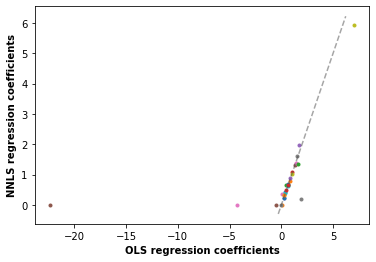

In [14]:
X, y = features_target_split(ml_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
reg_ols, reg_nnls = ols_nnls_competition(X_train, X_test, y_train, y_test)
show_ols_nnls_results(reg_ols, reg_nnls)
sm_ols(X_train, X_test, y_train, y_test)

#### Validation croisée du score OLS

La présence des surfaces relatives par usage améliore améliore les performances (0.62 contre 0.56).

En revanche, la mauvaise qualité des données introduit du bruit.

La propchaine étape, à défaut de pouvoir corriger toutes les données, c'est de retirer les jeux incohérents des données d'apprentissage.

In [15]:
from seattle_commons import show_ols_scores
show_ols_scores(reg_ols, X, y)

cv scores : [0.79206538 0.68433439 0.75075738]
mean scores : 0.7423857181398302
std scores : 0.04437758463300786
